# Higgs Analysis:

>This notebook contains work performed on coffea-casa cloud server. 
> Work in progress

In [1]:
from datetime import datetime
import pytz

ist = pytz.timezone('Asia/Kolkata')

print(f"Last modified: {datetime.now(ist).strftime('%d %B %Y, %H:%M')} IST")


Last modified: 10 February 2026, 15:11 IST


# Imports 

In [2]:
import os
import sys
import time
import gc
import psutil
import json
from pathlib import Path

# Data processing
import uproot
import awkward as ak
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import mplhep as hep

# Numerical computing
import vector
import hist
from hist import Hist
from tqdm import tqdm

# Parallel processing 
import dask
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
import coffea
from coffea_casa import CoffeaCasaCluster
from dask.distributed import progress

# others
!pip install prettytable
from prettytable import PrettyTable

vector.register_awkward()

print(" All imports loaded")

  Using cached prettytable-3.17.0-py3-none-any.whl.metadata (34 kB)
Using cached prettytable-3.17.0-py3-none-any.whl (34 kB)
 All imports loaded


# All Directories and path

In [3]:
# BASE PATHS
HOME_DIR = Path(os.environ.get("HOME", "/home/cms-jovyan"))
PROJECT_NAME = "H-to-WW-NanoAOD-analysis"

# DERIVED PATHS
PROJECT_DIR = HOME_DIR / PROJECT_NAME
DATASETS_DIR = PROJECT_DIR / "Datasets"
DATA_DIR = DATASETS_DIR / "DATA"
MC_DIR = DATASETS_DIR / "MC_samples"
AUX_DIR = PROJECT_DIR / "Auxillary_files"
OUTPUT_DIR = PROJECT_DIR / "Plots" / "stacked"
 
# JSON FILES
GOLDEN_JSON_PATH = AUX_DIR / "Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt"

# RUN PERIODS
RUN_PERIODS_2016 = {
    'Run2016G': {'run_min': 278820, 'run_max': 280385},
    'Run2016H': {'run_min': 280919, 'run_max': 284044}
}
 
# PRINT CONFIGURATION
print(f"HOME_DIR:         {HOME_DIR}")
print(f"PROJECT_DIR:     {PROJECT_DIR}")
print(f"DATA_DIR:        {DATA_DIR}")
print(f"MC_DIR:          {MC_DIR}")
print(f"AUX_DIR:         {AUX_DIR}")
print(f"OUTPUT_DIR:      {OUTPUT_DIR}")
print(f"GOLDEN_JSON:      {GOLDEN_JSON_PATH}")
print(f"JSON exists:     {GOLDEN_JSON_PATH.exists()}")

HOME_DIR:         /home/cms-jovyan
PROJECT_DIR:     /home/cms-jovyan/H-to-WW-NanoAOD-analysis
DATA_DIR:        /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Datasets/DATA
MC_DIR:          /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Datasets/MC_samples
AUX_DIR:         /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Auxillary_files
OUTPUT_DIR:      /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Plots/stacked
GOLDEN_JSON:      /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Auxillary_files/Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt
JSON exists:     True


In [4]:
# Sample mapping 
SAMPLE_MAPPING = {
    'data': 'Data',
    'higgs':  'ggH_HWW',
    'dytoll': 'DY_to_Tau_Tau',
    'top': 'Top_antitop',
    'fakes': 'Fakes',
    'vz': 'Diboson',
    'ggww':  'ggWW',
    'ww': 'WW',
    'vg': 'VG'
}

def load_urls_from_file(filepath, max_files=None):
    """Load XRootD URLs from text file"""
    urls = []
    if not os.path.exists(filepath):
        return urls
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line and line.startswith('root://'):
                urls.append(line)
                if max_files and len(urls) >= max_files:
                    break
    return urls

def load_all_files(data_dir, mc_dir, max_per_sample=None):
    """Load all file URLs from directories"""
    
    files_dict = {}
    
    for directory in [data_dir, mc_dir]:
        if not os.path.exists(directory):
            continue
        for filename in os.listdir(directory):
            if not filename.endswith(('.txt')):
                continue
            filepath = os.path.join(directory, filename)
            filename_lower = filename.lower().replace('.txt', '')
            # Find label
            label = None
            for pattern, sample_label in SAMPLE_MAPPING.items():
                if pattern in filename_lower:
                    label = sample_label
                    break          
            if not label:
                print(f"   Unknown file: {filename} - skipping")
                continue
            
            # Load URLs
            urls = load_urls_from_file(filepath, max_per_sample)
            
            if urls:
                if label in files_dict:
                    files_dict[label].extend(urls)
                else:
                    files_dict[label] = urls
    
    return files_dict

files = load_all_files(DATA_DIR, MC_DIR, max_per_sample=1)  # TESTING
# files = load_all_files(DATA_DIR, MC_DIR)  # FULL 

print("\n" + "="*70)
print("FILES TO PROCESS")
print("="*70)
total = 0
for label, urls in files.items():
    print(f"{label:20s}: {len(urls):4d} files")
    total += len(urls)
print("_"*70)
print(f"{'TOTAL':20s}: {total:4d} files")
print("="*70)


FILES TO PROCESS
Data                :    1 files
VG                  :    1 files
ggH_HWW             :    1 files
WW                  :    1 files
Fakes               :    1 files
Diboson             :    1 files
DY_to_Tau_Tau       :    1 files
ggWW                :    1 files
Top_antitop         :    1 files
______________________________________________________________________
TOTAL               :    9 files


In [5]:
SAMPLES = {
    "Fakes":          {"color": "#B3B3B3", "is_signal": False, "stack_order": 1},
    
    "VG":             {"color": "#FFCC00", "is_signal": False, "stack_order": 2},
    "Diboson":        {"color": "#A6CEE3", "is_signal": False, "stack_order": 3},
    
    "DY_to_Tau_Tau":  {"color": "#33A02C", "is_signal": False, "stack_order": 4},
    "Top_antitop":    {"color": "#FF7F00", "is_signal": False, "stack_order": 5},
    
    "ggWW":           {"color": "#6BAED6", "is_signal": False, "stack_order": 6},
    "WW":             {"color": "#1F78B4", "is_signal": False, "stack_order": 7},
    
    "ggH_HWW":        {"color": "#E41A1C", "is_signal": True,  "stack_order": 8},
    
    "Data":           {"color": "#000000", "is_signal": False, "stack_order": -1},
}

# Helper dictionaries
colour = {name: props["color"] for name, props in SAMPLES.items()}
stack_order = {name: props["stack_order"] for name, props in SAMPLES.items() if props["stack_order"] >= 0}

In [6]:
colour

{'Fakes': '#B3B3B3',
 'VG': '#FFCC00',
 'Diboson': '#A6CEE3',
 'DY_to_Tau_Tau': '#33A02C',
 'Top_antitop': '#FF7F00',
 'ggWW': '#6BAED6',
 'WW': '#1F78B4',
 'ggH_HWW': '#E41A1C',
 'Data': '#000000'}

In [7]:
stack_order

{'Fakes': 1,
 'VG': 2,
 'Diboson': 3,
 'DY_to_Tau_Tau': 4,
 'Top_antitop': 5,
 'ggWW': 6,
 'WW': 7,
 'ggH_HWW': 8}

# JSON validation functions

In [8]:
def load_golden_json(json_input, run_periods=None):
    """
    Load golden JSON from either a file path (str) or a dict.
    """
    if isinstance(json_input, str):
        with open(json_input, 'r') as f:
            golden_json = json.load(f)
    elif isinstance(json_input, dict):
        golden_json = json_input
    else:
        raise TypeError(f"Expected str or dict, got {type(json_input)}")
    
    valid_lumis = {}
    for run_str, lumi_ranges in golden_json.items():
        run = int(run_str)
        
        # Filter by run periods 
        if run_periods is not None: 
            in_period = any(
                period['run_min'] <= run <= period['run_max']
                for period in run_periods.values()
            )
            if not in_period:
                continue
        
        valid_lumis[run] = [tuple(lr) for lr in lumi_ranges]
    
    return valid_lumis

def apply_json_mask(arrays, json_input, run_periods=None):

    valid_lumis = load_golden_json(json_input, run_periods)    
    runs = ak.to_numpy(arrays.run)
    lumis = ak.to_numpy(arrays.luminosityBlock)
    mask = np. zeros(len(runs), dtype=bool)
    
    for run, lumi_ranges in valid_lumis.items():
        run_mask = (runs == run)
        if not np.any(run_mask):
            continue
        # Check lumi sections 
        run_lumis = lumis[run_mask]
        run_lumi_mask = np.zeros(len(run_lumis), dtype=bool)
        for lumi_start, lumi_end in lumi_ranges: 
            run_lumi_mask |= (run_lumis >= lumi_start) & (run_lumis <= lumi_end)
        mask[run_mask] = run_lumi_mask
    
    return ak.Array(mask)

# Loading branches to use 

In [9]:
# Batch_size = 1_250_000
def load_events(file_url, batch_size=1_250_000, timeout=600, max_retries=3, retry_wait=10, is_data = False):

    columns = [
        "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
        "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
        
        "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
        "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
        "PuppiMET_pt", "PuppiMET_phi",
        
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        "Jet_btagDeepFlavB", "nJet", "Jet_jetId", "Jet_puId",
    ]

    if is_data:
        columns.extend(["run","luminosityBlock"])
    else: columns.append("genWeight")
        
    for attempt in range(max_retries):
        try:
            
            with uproot.open(file_url, timeout=timeout) as f:
                tree = f['Events']
                
                
                for arrays in tree.iterate(columns, step_size=batch_size, library="ak"):
                    yield arrays
                
                return
                
        except (TimeoutError, OSError, IOError, ConnectionError) as e:
            error_type = type(e).__name__
            file_name = file_url.split('/')[-1]
            
            if attempt < max_retries - 1:
                print(f"      {error_type} on {file_name}")
                print(f"       Retry {attempt+1}/{max_retries-1} in {retry_wait}s...")
                time.sleep(retry_wait)
            else:
                print(f"     FAILED after {max_retries} attempts: {file_name}")
                print(f"       Error: {str(e)[:100]}")
                raise
                
        except Exception as e:
            
            file_name = file_url.split('/')[-1]
            print(f"     Unexpected error on {file_name}: {str(e)[:100]}")
            raise

# Helper functions

In [10]:
def wrap_angle_to_pi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def create_lepton_vector(lepton):
    """Create 4-vector from lepton properties """
    return vector.array({
        "pt": lepton.pt,
        "eta": lepton.eta,
        "phi": lepton.phi,
        "mass": lepton.mass
    })

# Event Selection

## Pre-Selection

### Selecting tight leptons (Electrons and Muon)

In [11]:
def select_tight_leptons(arrays):
    """Apply tight ID and isolation cuts to leptons"""
    # Define selection masks
    tight_electron_mask = arrays.Electron_mvaFall17V2Iso_WP90 == 1
    tight_muon_mask = (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15)
    
    # Create structured arrays for selected leptons
    tight_electrons = ak.zip({
        "pt": arrays.Electron_pt[tight_electron_mask],
        "eta": arrays.Electron_eta[tight_electron_mask],
        "phi": arrays.Electron_phi[tight_electron_mask],
        "mass": arrays.Electron_mass[tight_electron_mask],
        "charge": arrays.Electron_charge[tight_electron_mask],
        "flavor": ak.ones_like(arrays.Electron_pt[tight_electron_mask]) * 11
    })
    
    tight_muons = ak.zip({
        "pt": arrays.Muon_pt[tight_muon_mask],
        "eta": arrays.Muon_eta[tight_muon_mask],
        "phi": arrays.Muon_phi[tight_muon_mask],
        "mass": arrays.Muon_mass[tight_muon_mask],
        "charge": arrays.Muon_charge[tight_muon_mask],
        "flavor": ak.ones_like(arrays.Muon_pt[tight_muon_mask]) * 13
    })
    
    # Combine into single collection
    tight_leptons = ak.concatenate([tight_electrons, tight_muons], axis=1)
    
    return tight_leptons, tight_electron_mask, tight_muon_mask

### Selecting Electron and Muon candidates

In [12]:
def select_e_mu_events(tight_leptons, met_arrays, leading_pt_cut=25, subleading_pt_cut=13):
    """Select events with exactly 1 electron and 1 muon"""
    # Sort by pT
    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
    # Require exactly 2 leptons
    mask_2lep = ak.num(sorted_leptons) == 2
    # mask_loose_veto = ak.num(loose_leptons)
    events_2lep = sorted_leptons[mask_2lep]
    met_2lep = met_arrays[mask_2lep]
    
    if len(events_2lep) == 0:
        return None, None, {}, None
    # Get leading and subleading
    leading = events_2lep[:, 0]
    subleading = events_2lep[:, 1]
    # Pre-Selection criteria
    mask_1e1mu = ((leading.flavor == 11) & (subleading.flavor == 13)) | \
                 ((leading.flavor == 13) & (subleading.flavor == 11))
    mask_opposite_charge = leading.charge * subleading.charge < 0
    mask_pt = (leading.pt > leading_pt_cut) & (subleading.pt > subleading_pt_cut)
    eta_leading = ((leading.flavor == 11) & (abs(leading.eta) < 2.5)) | \
                       ((leading.flavor == 13) & (abs(leading.eta) < 2.4))
    eta_subleading = ((subleading.flavor == 11) & (abs(subleading.eta) < 2.5)) | \
                          ((subleading.flavor == 13) & (abs(subleading.eta) < 2.4))
    mask_eta = eta_leading & eta_subleading
    
    # Final selection
    final_mask = mask_1e1mu & mask_opposite_charge & mask_pt & mask_eta
    
    # Store cutflow information
    cutflow = {
        'events_2lep': len(leading),
        'events_1e1mu': ak.sum(mask_1e1mu),
        'events_opposite_charge': ak.sum(mask_1e1mu & mask_opposite_charge),
        'events_final': ak.sum(final_mask)
    }
    
    return leading[final_mask], subleading[final_mask], cutflow, met_2lep[final_mask]

## Counting jets and 0/1/2 Jet categorisation

In [13]:
def count_jets(arrays, jet_pt_threshold=30, tight_leptons=None):
    # Step 1: Create Jet object from individual arrays
    jets = ak.zip({
        "pt": arrays.Jet_pt,
        "eta": arrays.Jet_eta,
        "phi": arrays.Jet_phi,
        "mass": arrays.Jet_mass,
        "jetId": arrays.Jet_jetId,
        "btagDeepFlavB": arrays.Jet_btagDeepFlavB,
        "puId": arrays.Jet_puId 
    })
    # Step 2: Good jet selection
    pu_id_mask = (jets.pt > 50) | ((jets.pt <= 50) & (jets.puId >= 4))
    good_mask = (jets.jetId >= 2) & (abs(jets.eta) < 4.7) & pu_id_mask
    # Step 3: Lepton cleaning
    if tight_leptons is not None and ak.max(ak.num(tight_leptons)) > 0:
        # Delta R calculation
        jets_eta = jets.eta[:, :, None]
        jets_phi = jets.phi[:, :, None]
        leps_eta = tight_leptons.eta[:, None, :]
        leps_phi = tight_leptons.phi[:, None, :]
        
        deta = jets_eta - leps_eta
        dphi = (jets_phi - leps_phi + np.pi) % (2 * np.pi) - np.pi
        dr = np.sqrt(deta**2 + dphi**2)
        
        min_dr = ak.min(dr, axis=-1)
        
        min_dr = ak.fill_none(min_dr, 999.0)
        good_mask = good_mask & (min_dr > 0.4)
    
    good_jets = jets[good_mask]
    
    # Step 4: Sort by pT
    sorted_jets = good_jets[ak.argsort(good_jets.pt, axis=1, ascending=False)]
    lead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt), 0)
    sublead_jet_pt = ak.fill_none(ak.firsts(sorted_jets[:, 1:].pt), 0)
    # Step 5: Category masks based on jet count
    isZeroJet = (lead_jet_pt < jet_pt_threshold)
    isOneJet = (lead_jet_pt >= jet_pt_threshold) & (sublead_jet_pt < jet_pt_threshold)
    isTwoJet = (sublead_jet_pt >= jet_pt_threshold) # At least 2 jets
    
    n_jets = ak.sum(sorted_jets.pt >= jet_pt_threshold, axis=1)
    
    return n_jets, good_mask, sorted_jets, isZeroJet, isOneJet, isTwoJet

## bjet categorization

In [14]:
def get_bjet_categories(arrays, btag_threshold=0.2217, eta_max=2.5):
    """
    Get different b-jet categories needed for SR/CR selection.
    """
    # Base b-jet selection 
    base_bjet_mask = (
        (arrays.Jet_jetId >= 2) &
        (abs(arrays.Jet_eta) < eta_max) &
        (arrays.Jet_btagDeepFlavB > btag_threshold)
    )
    # Different pT categories
    bjets_20 = base_bjet_mask & (arrays.Jet_pt > 20)
    bjets_20_30 = base_bjet_mask & (arrays.Jet_pt > 20) & (arrays.Jet_pt <= 30)
    bjets_30 = base_bjet_mask & (arrays.Jet_pt > 30)
    # Count per event
    n_bjets_20 = ak.sum(bjets_20, axis=1)
    n_bjets_20_30 = ak.sum(bjets_20_30, axis=1) 
    n_bjets_30 = ak.sum(bjets_30, axis=1)
    return {
        # For Signal Regions 
        'passes_bjet_veto': n_bjets_20 == 0,  
        # For Control Regions
        'has_btag_20_30': n_bjets_20_30 > 0,  # Top CR 0-jet
        'has_btag_30': n_bjets_30 > 0,        # Top CR 1-jet, 2-jet
        # Counts
        'n_bjets_20': n_bjets_20,
        'n_bjets_20_30': n_bjets_20_30,
        'n_bjets_30': n_bjets_30
    }

def apply_bjet_selections(arrays):
    bjet_info = get_bjet_categories(arrays)
    # For Signal Regions
    sr_bjet_veto = bjet_info['passes_bjet_veto']
    # For Control Regions
    cr_top_0jet = bjet_info['has_btag_20_30']
    cr_top_1jet_2jet = bjet_info['has_btag_30']
    return sr_bjet_veto, bjet_info

## Global Cuts


In [15]:
def apply_global_cuts(leading, subleading, met, mt_higgs, mt_l2_met,ptlls,masses):
    """Apply global selection cuts"""
    # Global cuts
    mask_met_pt = met.pt > 20
    mask_ptll  = ptlls > 30
    mask_mll = masses > 12 
    # Combine all masks
    global_mask =  mask_met_pt & mask_ptll & mask_mll
    return global_mask, {
        'pass_met_pt': ak.sum(mask_met_pt),
        'pass_ptll': ak.sum(mask_ptll),
        'pass_mll': ak.sum(mask_mll),
        'pass_global': ak.sum(global_mask)
    }

## Signal regions

In [16]:
def apply_signal_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                           mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                           bjet_veto_mask, mjj=None):
    """Apply Signal Region selections for all jet categories."""
    sr_specific_cuts = (
                        ( met.pt > 20) &
                        ( ptlls > 30) &
                       ( masses > 12)  &
                        (mt_higgs >60) &
                        (mt_l2_met >30) &
                        bjet_veto_mask        
                        )
    sr_base =  sr_specific_cuts
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    sr_regions = {
        'SR_0jet': sr_base & isZeroJet,
        'SR_1jet': sr_base & isOneJet,
        'SR_2jet': sr_base & isTwoJet & mjj_window
    }
    return sr_regions

## control region

In [17]:
def apply_control_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                            mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                            bjet_info, mjj=None):
    """Apply Control Region selections for all jet categories."""
    cr_base = (
        (met.pt > 20) &
        (ptlls > 30) &
        (mt_l2_met > 30)    &
        (masses > 12)
    )
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    cr_regions = {}
    # === TOP CONTROL REGIONS ===
    cr_top_base = cr_base & (masses > 50)
    cr_regions['CR_top_0jet'] = (
        cr_top_base & 
        isZeroJet & 
        bjet_info['has_btag_20_30']  # 20 < pT < 30 GeV b-jets for 0-jet
    )
    cr_regions['CR_top_1jet'] = (
        cr_top_base & 
        isOneJet & 
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 1-jet
    )
    cr_regions['CR_top_2jet'] = (
        cr_top_base & 
        isTwoJet & 
        mjj_window &
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 2-jet
    )
    # === TAU-TAU CONTROL REGIONS ===
    cr_tau_base = (
        cr_base & 
        (mt_higgs < 60) & 
        (masses > 40) & 
        (masses < 80) &
        bjet_info['passes_bjet_veto']  
    )
    cr_regions['CR_tau_0jet'] = cr_tau_base & isZeroJet
    cr_regions['CR_tau_1jet'] = cr_tau_base & isOneJet  
    cr_regions['CR_tau_2jet'] = cr_tau_base & isTwoJet & mjj_window
    return cr_regions

---
# Calculations 

## Calculating  kinematic variables 
- Invariant mass of dilepton(electron and muon) system
- Transverse momentum of dilepton system
- Azimuathal seperation between dileptons
- Transverse mass of Higgs
- Transvers mass of subleading lepton and $E^T_{miss}$ 
  

In [18]:
def cal_kinematic_var(leading, subleading, met):
    # Create vectors
    lepton_1 = create_lepton_vector(leading)
    lepton_2 = create_lepton_vector(subleading)
    dilepton = lepton_1 + lepton_2
    #  Basic Variables
    masses = dilepton.mass
    ptll = dilepton.pt
    dphi = wrap_angle_to_pi(leading.phi - subleading.phi)
    # Higgs Transverse Mass 
    dll_et = np.sqrt(dilepton.pt**2 + dilepton.mass**2)
    mt_higgs_dphi = wrap_angle_to_pi(dilepton.phi - met.phi)
    term_1 = masses**2
    term_2 = 2 * (dll_et * met.pt - dilepton.pt * met.pt * np.cos(mt_higgs_dphi))
    mt_higgs = np.sqrt(term_1 + term_2)
    # Lepton 2 Transverse Mass
    mt_l2_met_dphi = wrap_angle_to_pi(subleading.phi - met.phi)
    mt_l2_met = np.sqrt(2 * subleading.pt * met.pt * (1 - np.cos(mt_l2_met_dphi)))

    return masses, ptll, dphi, mt_higgs, mt_l2_met

## Calculating Invriant mass of jets and applying $m_{jj}$

In [19]:
def calculate_mjj(jets):
    # Get number of jets per event
    n_jets = ak.num(jets)
    # Initialize mjj with zeros for all events
    mjj = ak.zeros_like(n_jets, dtype=float)
    # Create mask for events with at least 2 jets
    has_two_jets = n_jets >= 2
    # Only proceed if there are events with 2+ jets
    if ak.any(has_two_jets):
        # Use padding to safely access indices
        jets_padded = ak.pad_none(jets, 2, axis=1)
        # Create 4-vectors for jets
        jet_vectors = ak.zip({
            "pt": ak.fill_none(jets_padded.pt, 0.0),
            "eta": ak.fill_none(jets_padded.eta, 0.0),
            "phi": ak.fill_none(jets_padded.phi, 0.0),
            "mass": ak.fill_none(jets_padded.mass, 0.0)
        }, with_name="Momentum4D")
        # Get first two jets
        jet1 = jet_vectors[:, 0]
        jet2 = jet_vectors[:, 1]
        # Calculate invariant mass using vector addition
        dijet = jet1 + jet2
        mjj_calculated = dijet.mass
        # Apply only where we have 2+ jets
        mjj = ak.where(has_two_jets, mjj_calculated, 0.0)
    
    return mjj

def apply_mjj_window(mjj):
    return (mjj < 65) | ((mjj > 105) & (mjj < 120))

# Histogram Initialization

In [20]:
variables_to_plots = {
        'mass': hist.axis.Regular(20, 0, 200, name="mass", label="m_ll [GeV]"),
        'met': hist.axis.Regular(20, 0, 200, name="met", label="MET [GeV]"),
        'dphi': hist.axis.Regular(20, 0, np.pi, name="dphi", label="dphi(l,l)"),
        'ptll': hist.axis.Regular(20, 0, 200, name="ptll", label="p_T^ll [GeV]"),
        'mt_higgs': hist.axis.Regular(20, 0, 300, name="mt_higgs", label="m_T^H [GeV]"),
        'mt_l2_met': hist.axis.Regular(20, 0, 200, name="mt_l2_met", label="m_T(l2,MET) [GeV]"),
        'mjj': hist.axis.Regular(20, 0, 500, name="mjj", label="m_jj [GeV]"),
        'leading_pt': hist.axis.Regular(20, 0, 200, name="leading_pt", label="Leading lepton p_T [GeV]"),
        'subleading_pt': hist.axis.Regular(20, 0, 200, name="subleading_pt", label="Subleading lepton p_T [GeV]"),
    }
stage_names = [
        'before_cuts', 'global', '0jet', '1jet', '2jet',
        'SR_0jet', 'SR_1jet', 'SR_2jet',
        'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
        'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
    ]

def initialize_stage_histograms():
    """Initialize histograms for all selection stages"""
    stage_histograms = {}
    for stage in stage_names:
        stage_histograms[stage] = {
            var_name: Hist(axis) for var_name, axis in variables_to_plots.items()
        }
    return stage_histograms

# Initialize for all samples
hist_data = {}
for label in ['Data', 'ggH_HWW', 'DY_to_Tau_Tau', 'Top_antitop', 'Fakes', 
              'Diboson', 'ggWW', 'WW', 'VG']:
    hist_data[label] = initialize_stage_histograms()

print("Histogram storage initialized")

Histogram storage initialized


# Setting up Dask client

In [21]:
client = Client("tls://localhost:8786")
client

<Client: 'tls://192.168.202.61:8786' processes=1 threads=1, memory=2.89 GiB>

# Sample Configuration: X-sec and Luminosity 

In [22]:
# Luminosity for 2016 UltraLegacy  (pb^-1)
LUMINOSITY = 16_150.0 

sample_info_detailed = {
    # --- DRELL-YAN ---
    "DYJetsToLL_M-50":      { "xsec": 6189.39, "sum_genWeight": 82448537.0 },
    # --- TOP QUARK ---
    "TTTo2L2Nu":            { "xsec": 87.31, "sum_genWeight": 3140127171.4748 },
    "ST_t-channel_top":     { "xsec": 44.33, "sum_genWeight": 6703802049.126 },
    "ST_t-channel_antitop": { "xsec": 26.38, "sum_genWeight": 1522100315.652 },
    "ST_tW_top":            { "xsec": 35.60, "sum_genWeight": 20635251.1008 },
    "ST_tW_antitop":        { "xsec": 35.60, "sum_genWeight": 27306324.658 },
    "ST_s-channel":         { "xsec": 3.36,  "sum_genWeight": 19429336.179 },
    # --- FAKES ---
    "WJetsToLNu":           { "xsec": 61526.7, "sum_genWeight": 9697410121705.164 },
    "TTToSemiLeptonic":     { "xsec": 364.35,  "sum_genWeight": 43548253725.284 },
    # --- V+GAMMA ---
    "ZGToLLG":              { "xsec": 58.83,   "sum_genWeight": 3106465270.711 },
    "WGToLNuG":             { "xsec": 405.271, "sum_genWeight": 3353413.0 },
    # --- DIBOSON ---
    "WZTo3LNu":             { "xsec": 4.42965, "sum_genWeight": 4077550.6318 },
    "WZTo2Q2L":             { "xsec": 5.595,   "sum_genWeight": 129756627.882 },
    "ZZ":                   { "xsec": 16.523,  "sum_genWeight": 1151000.0 },
    # --- SIGNAL & IRREDUCIBLE ---
    "GluGluToWW":           { "xsec": 0.06387, "sum_genWeight": 17662000.0 },
    "WWTo2L2Nu":            { "xsec": 12.178,  "sum_genWeight": 32147079.595 },
    "Higgs":                { "xsec": 1.0315,  "sum_genWeight": 63281816.82 }
}

# Processing

## Processing function

In [23]:
# import time
# import gc
# import json
# import awkward as ak
# import numpy as np
# import uproot
# import vector

def make_processor(golden_json_data, sample_info_detailed, luminosity, run_periods):

    def get_sample_key(filename):
        fn = filename
        # Data Check
        if any(x in fn for x in ["Run2016", "SingleMuon", "DoubleEG", "MuonEG"]): return None
        # MC Matching Logic
        if "DYJetsToLL" in fn:         return "DYJetsToLL_M-50"
        if "TTTo2L2Nu" in fn:          return "TTTo2L2Nu"
        if "ST_t-channel_top" in fn:   return "ST_t-channel_top"
        if "ST_t-channel_antitop" in fn: return "ST_t-channel_antitop"
        if "ST_tW_antitop" in fn:      return "ST_tW_antitop"
        if "ST_tW_top" in fn:          return "ST_tW_top"
        if "ST_s-channel" in fn:       return "ST_s-channel"
        if "WJetsToLNu" in fn:         return "WJetsToLNu"
        if "TTToSemiLeptonic" in fn:   return "TTToSemiLeptonic"
        if "ZGToLLG" in fn:            return "ZGToLLG"
        if "WGToLNuG" in fn:           return "WGToLNuG"
        if "WZTo3LNu" in fn:           return "WZTo3LNu"
        if "WZTo2Q2L" in fn:           return "WZTo2Q2L"
        if "ZZ" in fn:                 return "ZZ"
        if "GluGluToWW" in fn:         return "GluGluToWW"
        if "WWTo2L2Nu" in fn:          return "WWTo2L2Nu"
        if "GluGluHToWW" in fn or "Higgs" in fn: return "Higgs"
        
        return "Unknown" 

    # WORKER FUNCTION 
    def processing_file(label, file_url, file_idx):
        import uproot
        import awkward as ak
        import numpy as np
        import vector
        import time
        
        vector.register_awkward()
        
        file_name = file_url.split('/')[-1] 
        is_data = (label == 'Data')
        
        specific_sample_key = get_sample_key(file_url)

        cutflow_stages = [
            'total', 'after_json', 'e_mu_preselection', 'global_cuts',
            '0jet', '1jet', '2jet',
            'SR_0jet', 'SR_1jet', 'SR_2jet',
            'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
            'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
        ]

        empty_cutflow = {stage: 0 for stage in cutflow_stages}
        
        # Helper function 
        def fill_histograms(stage_name, mask, event_weights, 
                           masses_np, met_np, dphis_np, ptlls_np,
                           mt_higgs_np, mt_l2_met_np, mjj_np,
                           leading_pt_np, subleading_pt_np):
            mask_np = ak.to_numpy(mask) if not isinstance(mask, np.ndarray) else mask
            n_events = np.sum(mask_np)
            
            if n_events == 0:
                return
            
            weights_masked = ak.to_numpy(event_weights[mask_np])
            
            stage_histograms[stage_name]['mass'].fill(masses_np[mask_np], weight=weights_masked)
            stage_histograms[stage_name]['met'].fill(met_np[mask_np], weight=weights_masked)
            stage_histograms[stage_name]['dphi'].fill(dphis_np[mask_np], weight=weights_masked)
            stage_histograms[stage_name]['ptll'].fill(ptlls_np[mask_np], weight=weights_masked)
            stage_histograms[stage_name]['mt_higgs'].fill(mt_higgs_np[mask_np], weight=weights_masked)
            stage_histograms[stage_name]['mt_l2_met'].fill(mt_l2_met_np[mask_np], weight=weights_masked)
            stage_histograms[stage_name]['mjj'].fill(mjj_np[mask_np], weight=weights_masked)
            stage_histograms[stage_name]['leading_pt'].fill(leading_pt_np[mask_np], weight=weights_masked)
            stage_histograms[stage_name]['subleading_pt'].fill(subleading_pt_np[mask_np], weight=weights_masked)
        
        try:
            stage_histograms = initialize_stage_histograms()
            cutflow = empty_cutflow.copy()
            weighted_cutflow = {stage: 0.0 for stage in cutflow_stages}
            
            max_file_retries = 3
            
            for file_attempt in range(max_file_retries):
                try:
                    for arrays in load_events(file_url, batch_size=1_250_000, is_data=is_data):
                        
                        cutflow['total'] += len(arrays)

                        # SCALING PART 
                        if is_data:
                            event_weights = ak.ones_like(arrays.PuppiMET_pt, dtype=float)
                        
                        elif specific_sample_key in sample_info_detailed:
                            # 1. Get info for this SPECIFIC file
                            info = sample_info_detailed[specific_sample_key]
                            
                            # 2. Calculate factor: (xsec * L) / sum_genWeight
                            scale_factor = (info['xsec'] * luminosity) / info['sum_genWeight']
                            
                            # 3. Apply to genWeight
                            event_weights = arrays.genWeight * scale_factor
                        
                        else:
                            # print(f"Warning: Key '{specific_sample_key}' not found for {file_name}")
                            event_weights = ak.zeros_like(arrays.PuppiMET_pt, dtype=float)
                        
                        weighted_cutflow['total'] += float(ak.sum(event_weights))
                        
                        # Apply JSON mask for Data
                        if is_data and golden_json_data is not None:
                            try:
                                json_mask = apply_json_mask(arrays, golden_json_data, run_periods=run_periods)
                                n_events_after = int(ak.sum(json_mask))
                                cutflow['after_json'] += n_events_after
                                weighted_cutflow['after_json'] += float(ak.sum(event_weights[json_mask]))

                                if n_events_after == 0:
                                    continue

                                arrays = arrays[json_mask]
                                event_weights = event_weights[json_mask]
                            except Exception as e: 
                                print(f"Warning: JSON mask failed for {file_name}: {e}")
                        
                        # Get tight leptons
                        tight_leptons, _, _ = select_tight_leptons(arrays)
                        met = ak.zip({"pt": arrays.PuppiMET_pt, "phi": arrays.PuppiMET_phi})
                        
                        # Apply e-mu selection
                        leading, subleading, emu_cutflow, met_selected = select_e_mu_events(tight_leptons, met)
                        
                        if leading is None or len(leading) == 0:
                            continue

                        sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
                        has_2lep = ak.num(sorted_leptons) == 2
                        events_2lep = sorted_leptons[has_2lep]
                        
                        if len(events_2lep) == 0:
                            continue
                        
                        lead_all = events_2lep[:, 0]
                        sublead_all = events_2lep[:, 1]
                        
                        mask_1e1mu = ((lead_all.flavor == 11) & (sublead_all.flavor == 13)) | \
                                     ((lead_all.flavor == 13) & (sublead_all.flavor == 11))
                        mask_charge = lead_all.charge * sublead_all.charge < 0
                        mask_pt = (lead_all.pt > 25) & (sublead_all.pt > 13)
                        # mask_eta = (abs(lead_all.eta)<2.5) & (abs(sublead_all.eta) < 2.5)
                        eta_leading = ((lead_all.flavor == 11) & (abs(lead_all.eta) < 2.5)) | \
                                      ((lead_all.flavor == 13) & (abs(lead_all.eta) < 2.4))

                        eta_subleading = ((sublead_all.flavor == 11) & (abs(sublead_all.eta) < 2.5)) | \
                                         ((sublead_all.flavor == 13) & (abs(sublead_all.eta) < 2.4))
                        
                        mask_eta = eta_leading & eta_subleading
                        
                        emu_mask_2lep = mask_1e1mu & mask_charge & mask_pt & mask_eta
                        
                        indices_2lep = ak.where(has_2lep)[0]
                        indices_selected = ak.to_numpy(indices_2lep[emu_mask_2lep])
                        
                        emu_mask_full = np.zeros(len(has_2lep), dtype=bool)
                        emu_mask_full[indices_selected] = True
                        
                        # Apply mask to weights
                        event_weights = event_weights[emu_mask_full]
                        
                        cutflow['e_mu_preselection'] += len(leading)
                        weighted_cutflow['e_mu_preselection'] += float(ak.sum(event_weights))
                        
                        # Calculate kinematic variables
                        masses, ptlls, dphis, mt_higgs, mt_l2_met = cal_kinematic_var(
                            leading, subleading, met_selected
                        )
                        
                        # Convert to numpy 
                        weights_np = ak.to_numpy(event_weights)
                        masses_np = ak.to_numpy(masses)
                        met_np = ak.to_numpy(met_selected.pt)
                        dphis_np = ak.to_numpy(dphis)
                        ptlls_np = ak.to_numpy(ptlls)
                        mt_higgs_np = ak.to_numpy(mt_higgs)
                        mt_l2_met_np = ak.to_numpy(mt_l2_met)
                        leading_pt_np = ak.to_numpy(leading.pt)
                        subleading_pt_np = ak.to_numpy(subleading.pt)
                        mjj_before_np = np.zeros_like(masses_np) 
                        
                        # Fill before_cuts histograms
                        all_true = np.ones(len(masses_np), dtype=bool)
                        fill_histograms(
                            'before_cuts', all_true, event_weights,
                            masses_np, met_np, dphis_np, ptlls_np,
                            mt_higgs_np, mt_l2_met_np, mjj_before_np,
                            leading_pt_np, subleading_pt_np
                        )
                        
                        # Global cuts and jet counting
                        indices_emu = indices_selected
                        
                        n_jets_full, _, sorted_jets_full, isZeroJet_full, isOneJet_full, isTwoJet_full = count_jets(
                            arrays, tight_leptons=tight_leptons
                        )
                        
                        mjj_full = calculate_mjj(sorted_jets_full)
                        mjj_selected = ak.fill_none(mjj_full[indices_emu], 0.0)
                        mjj_np = ak.to_numpy(mjj_selected)
                        
                        global_cut_mask, _ = apply_global_cuts(
                            leading, subleading, met_selected, mt_higgs, mt_l2_met, ptlls, masses
                        )
                        bjet_veto_full, bjet_info_full = apply_bjet_selections(arrays)
                        bjet_veto_selected = bjet_veto_full[indices_emu]
                        bjet_info_selected = {
                            key: value[indices_emu] for key, value in bjet_info_full.items()
                        }
                        
                        global_mask_selected = global_cut_mask & bjet_veto_selected
                        global_mask_np = ak.to_numpy(global_mask_selected)
                        
                        cutflow['global_cuts'] += int(np.sum(global_mask_np))
                        weighted_cutflow['global_cuts'] += float(ak.sum(event_weights[global_mask_np]))
                        
                        if np.sum(global_mask_np) == 0:
                            continue
                        
                        # Fill global histograms
                        fill_histograms(
                            'global', global_mask_np, event_weights,
                            masses_np, met_np, dphis_np, ptlls_np,
                            mt_higgs_np, mt_l2_met_np, mjj_np,
                            leading_pt_np, subleading_pt_np
                        )
                        
                        # Jet categories
                        isZeroJet_np = ak.to_numpy(isZeroJet_full[indices_emu])
                        isOneJet_np = ak.to_numpy(isOneJet_full[indices_emu])
                        isTwoJet_np = ak.to_numpy(isTwoJet_full[indices_emu])

                        jet_categories = [
                            ('0jet', isZeroJet_np),
                            ('1jet', isOneJet_np),
                            ('2jet', isTwoJet_np)
                        ]
                        
                        for jet_name, jet_mask in jet_categories:
                            mask = global_mask_np & jet_mask
                            n_events = int(np.sum(mask))
                            cutflow[jet_name] += n_events
                            weighted_cutflow[jet_name] += float(np.sum(weights_np[mask]))
                            
                            fill_histograms(
                                jet_name, mask, event_weights,
                                masses_np, met_np, dphis_np, ptlls_np,
                                mt_higgs_np, mt_l2_met_np, mjj_np,
                                leading_pt_np, subleading_pt_np
                            )
                        
                        # Signal and Control Regions
                        sr_regions = apply_signal_region_cuts(
                            leading, subleading, met_selected, masses, ptlls, mt_higgs,
                            mt_l2_met, isZeroJet_full[indices_emu], isOneJet_full[indices_emu],
                            isTwoJet_full[indices_emu], bjet_veto_selected, mjj_selected
                        )
                        
                        cr_regions = apply_control_region_cuts(
                            leading, subleading, met_selected, masses, ptlls, mt_higgs,
                            mt_l2_met, isZeroJet_full[indices_emu], isOneJet_full[indices_emu],
                            isTwoJet_full[indices_emu], bjet_info_selected, mjj_selected
                        )
                        
                        all_regions = {**sr_regions, **cr_regions}
                        
                        for region_name, region_mask in all_regions.items():
                            region_mask_np = ak.to_numpy(region_mask)
                            n_events = int(np.sum(region_mask_np))
                            cutflow[region_name] += n_events
                            weighted_cutflow[region_name] += float(np.sum(weights_np[region_mask_np]))
                            
                            fill_histograms(
                                region_name, region_mask_np, event_weights,
                                masses_np, met_np, dphis_np, ptlls_np,
                                mt_higgs_np, mt_l2_met_np, mjj_np,
                                leading_pt_np, subleading_pt_np
                            )
                    
                    # Return results
                    return label, stage_histograms, cutflow, weighted_cutflow, None
                    
                except (OSError, IOError, ValueError) as e:
                    if file_attempt < max_file_retries - 1:
                        print(f"  {label}/{file_name}: {type(e).__name__} - Retry {file_attempt+1}/{max_file_retries}")
                        time.sleep(3)
                        continue
                    else: 
                        error_msg = f"{file_name}: {type(e).__name__} after {max_file_retries} attempts - {str(e)[:100]}"
                        return label, initialize_stage_histograms(), empty_cutflow, {s: 0.0 for s in cutflow_stages}, error_msg
                
                except Exception as e:
                    error_msg = f"{file_name}: {type(e).__name__} - {str(e)[:100]}"
                    return label, initialize_stage_histograms(), empty_cutflow, {s: 0.0 for s in cutflow_stages}, error_msg
            
            return label, stage_histograms, cutflow, weighted_cutflow, None
            
        except Exception as e:
            import traceback
            error_msg = f"{file_name}: Unexpected error - {str(e)[:100]}"
            return label, initialize_stage_histograms(), empty_cutflow, {s: 0.0 for s in cutflow_stages}, error_msg

    return processing_file

In [24]:
# # MAIN PROCESSING 
# import time
# import os
# import gc
# import json
# from dask.distributed import progress

print("\n" + "="*70)
print("PROCESSING START!! ")
print("="*70)

#  LOAD CONFIGURATION 
golden_json_data = None
if GOLDEN_JSON_PATH.exists():
    print(f"Reading Golden JSON: {GOLDEN_JSON_PATH.name}")
    with open(GOLDEN_JSON_PATH, 'r') as f:
        golden_json_data = json.load(f)
    print(f"  Loaded {len(golden_json_data)} runs into memory\n")
else:
    print(f"WARNING: Golden JSON not found at {GOLDEN_JSON_PATH}")

# System Info
cpu_cores = os.cpu_count()
total_files = sum(len(urls) for urls in files.values())
print(f"System Info:")
print(f"  Total files: {total_files}")
print(f"  Samples: {len(files)}")
print(f"  Dashboard: {client.dashboard_link}")
print("="*70)

#  CREATE THE WORKER FUNCTION
processing_task = make_processor(
    golden_json_data=golden_json_data,
    sample_info_detailed=sample_info_detailed, 
    luminosity=LUMINOSITY,                     
    run_periods=RUN_PERIODS_2016
)

arg_labels = []
arg_urls = []
arg_indices = []

print("Preparing file lists...")

for label, urls in files.items():
    is_data = (label == 'Data')
    
    if is_data:
        if golden_json_data is not None:
             print(f"  {label}: Validation enabled ({len(urls)} files)")
    
    # Build the flat lists for mapping
    for file_idx, file_url in enumerate(urls):
        arg_labels.append(label)
        arg_urls.append(file_url)
        arg_indices.append(file_idx)

# SUBMIT TASKS
start_time = time.perf_counter()

print(f"\nSubmitting {len(arg_urls)} files to the cluster...")

futures = client.map(
    processing_task, 
    arg_labels, 
    arg_urls, 
    arg_indices,
    retries=1  
)

#  MONITOR AND GATHER
print("Processing files...")
progress(futures)

# Gather results 
results = client.gather(futures)

elapsed = time.perf_counter() - start_time

print("\n" + "="*70)
print("File processing complete. Merging results...")
print("="*70)

#  MERGE RESULTS
hist_data_final = {}
cutflow_final = {}
weighted_cutflow_final = {}  

# Initialize storage
for label in files.keys():
    
    hist_data_final[label] = initialize_stage_histograms()
    
    cutflow_final[label] = {stage: 0 for stage in [
        'total','after_json', 'e_mu_preselection', 'global_cuts',
        '0jet', '1jet', '2jet',
        'SR_0jet', 'SR_1jet', 'SR_2jet',
        'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
        'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
    ]}
    weighted_cutflow_final[label] = {stage: 0.0 for stage in [
        'total','after_json', 'e_mu_preselection', 'global_cuts',
        '0jet', '1jet', '2jet',
        'SR_0jet', 'SR_1jet', 'SR_2jet',
        'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
        'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
    ]}

error_count = 0

for task_idx, result in enumerate(results):
    label, stage_histograms, cutflow, weighted_cutflow, error = result
    
    if error:
        error_count += 1
        file_url = arg_urls[task_idx]
        file_name = file_url.split('/')[-1]
        print(f" ERROR in {label}/{file_name}")
        print(f"    Reason: {error}")
        continue

    #  raw cutflow
    for stage, count in cutflow.items():
        cutflow_final[label][stage] += count
    
    #  weighted cutflow
    for stage, weighted_count in weighted_cutflow.items():
        weighted_cutflow_final[label][stage] += weighted_count
    
    #  histograms
    for stage_name, hists in stage_histograms.items():
        for var_name, hist_obj in hists.items():
            hist_data_final[label][stage_name][var_name] += hist_obj

#  FINAL REPORT
print("\n" + "="*70)
print("FINAL EVENT COUNTS BY SAMPLE")
print("="*70)

total_events = 0
for label in files.keys():
    events = cutflow_final[label]['total']
    total_events += events
    print(f"{label:20s}: {events:>12,} events")

print("_"*70)
print(f"{'TOTAL':20s}: {total_events:>12,} events")
print("="*70)

if error_count > 0:
    print(f"\n {error_count} file(s) failed during processing")

print(f"\n Processing completed in {elapsed:.1f}s ({elapsed/60:.1f} min)")
print(f"    Average: {elapsed/len(futures):.2f}s per file")
if elapsed > 0:
    print(f"    Throughput: {total_events/elapsed:,.0f} events/sec")
print("="*70 + "\n")

# Cleanup
del futures, results, arg_urls, arg_labels, arg_indices
gc.collect()


PROCESSING START!! 
Reading Golden JSON: Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt
  Loaded 393 runs into memory

System Info:
  Total files: 9
  Samples: 9
  Dashboard: /user/anujraghav.physics@gmail.com/proxy/8787/status
Preparing file lists...
  Data: Validation enabled (1 files)

Submitting 9 files to the cluster...
Processing files...

File processing complete. Merging results...

FINAL EVENT COUNTS BY SAMPLE
Data                :    2,238,235 events
VG                  :        2,125 events
ggH_HWW             :        2,000 events
WW                  :       15,000 events
Fakes               :    1,233,000 events
Diboson             :       15,000 events
DY_to_Tau_Tau       :    1,434,319 events
ggWW                :       68,000 events
Top_antitop         :      861,000 events
______________________________________________________________________
TOTAL               :    5,868,679 events

 Processing completed in 161.9s (2.7 min)
    Average: 17.99s per file
  

0

## Closing Dask Client

In [26]:
client.close()

In [29]:
del client

---
# Outputs

## Cutflow

In [25]:
# PRINT CUTFLOW TABLES
# from prettytable import PrettyTable

def print_cutflow(cutflow_final, weighted_cutflow_final):
    
    # 1. Define Stages 
    stage_info = [
        ('total', 'Total (Raw)'),
        # ('after_json', 'After JSON'),
        ('e_mu_preselection', 'e-μ Preselect'),
        ('global_cuts', 'Global Cuts'),
        ('0jet', '0-jet'),
        ('1jet', '1-jet'),
        ('2jet', '2-jet'),
        ('SR_0jet', 'SR 0j'),
        ('SR_1jet', 'SR 1j'),
        ('SR_2jet', 'SR 2j'),
        ('CR_top_0jet', 'CR Top 0j'),
        ('CR_top_1jet', 'CR Top 1j'),
        ('CR_top_2jet', 'CR Top 2j'),
        ('CR_tau_0jet', 'CR Tau 0j'),
        ('CR_tau_1jet', 'CR Tau 1j'),
        ('CR_tau_2jet', 'CR Tau 2j'),
    ]
    
    #  Define Sample Order
    sample_order = [
        'Data',
        'ggH_HWW',       
        'WW',            
        'Top_antitop',   
        'DY_to_Tau_Tau', 
        'Fakes',         
        'ggWW',          
        'Diboson',       
        'VG',            
    ]
    
    mc_samples = [s for s in sample_order if s != 'Data']
    
    # TABLE 1: RAW COUNTS 
    table = PrettyTable()
    stage_names = [s[1] for s in stage_info]
    table.field_names = ['Sample'] + stage_names
    
    table.align['Sample'] = 'l'
    for s in stage_names: table.align[s] = 'r'
    
    for sample in sample_order:
        if sample not in cutflow_final: continue
            
        row = [sample]
        for stage_key, _ in stage_info:
            # For Data 'Total', use 'after_json' to represent starting events
            if sample == 'Data' and stage_key == 'total':
                count = cutflow_final[sample].get('after_json', 0)
            else:
                count = cutflow_final[sample].get(stage_key, 0)
            row.append(f"{count:,}")
        table.add_row(row)

    # Separator
    table.add_row(['-'*15] + ['-'*12]*len(stage_names))
    
    # Total MC Row
    total_row = ['TOTAL (MC)']
    for stage_key, _ in stage_info:
        total = sum(cutflow_final[s].get(stage_key, 0) for s in mc_samples if s in cutflow_final)
        total_row.append(f"{total:,}")
    table.add_row(total_row)

    print("\n" + "="*120)
    print("CUTFLOW: RAW EVENTS (Unweighted)")
    print("="*120)
    print(table)
    print("\n")


    # TABLE 2: WEIGHTED YIELDS 
    if weighted_cutflow_final:
        table_w = PrettyTable()
        table_w.field_names = ['Sample'] + stage_names
        
        table_w.align['Sample'] = 'l'
        for s in stage_names: table_w.align[s] = 'r'
        
        for sample in sample_order:
            if sample not in weighted_cutflow_final: continue
                
            row = [sample]
            for stage_key, _ in stage_info:
                # For Data, Weighted == Raw
                if sample == 'Data' and stage_key == 'total':
                    val = weighted_cutflow_final[sample].get('after_json', 0.0)
                else:
                    val = weighted_cutflow_final[sample].get(stage_key, 0.0)
                
                # Formatting: Integers for Data, Floats for MC
                if sample == 'Data':
                    row.append(f"{int(val):,}")
                else:
                    row.append(f"{val:,.1f}")
            table_w.add_row(row)

        # Separator
        table_w.add_row(['-'*15] + ['-'*12]*len(stage_names))
        
        # Total MC Row
        total_w_row = ['TOTAL (MC)']
        for stage_key, _ in stage_info:
            total = sum(weighted_cutflow_final[s].get(stage_key, 0.0) for s in mc_samples if s in weighted_cutflow_final)
            total_w_row.append(f"{total:,.1f}")
        table_w.add_row(total_w_row)

        print("\n" + "="*120)
        print("CUTFLOW: WEIGHTED YIELDS (Scaled to L = 16.1 fb⁻¹)")
        print("="*120)
        print(table_w)
        print("\n")

# Execute
print_cutflow(cutflow_final, weighted_cutflow_final)


CUTFLOW: RAW EVENTS (Unweighted)
+-----------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| Sample          |  Total (Raw) | e-μ Preselect |  Global Cuts |        0-jet |        1-jet |        2-jet |        SR 0j |        SR 1j |        SR 2j |    CR Top 0j |    CR Top 1j |    CR Top 2j |    CR Tau 0j |    CR Tau 1j |    CR Tau 2j |
+-----------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| Data            |    2,237,659 |         9,622 |        1,312 |          447 |          450 |          415 |          358 |          321 |           47 |           68 |          490 |          198 |            0 |            0

> Image in case the table is messed up 

![cutflow image](Cutflow_updated.png)


# Plots

## Superimposed plots

In [26]:
# Set CMS style
hep.style.use("CMS")

VAR_LABELS = {
    'mass': r'$m_{e\mu}$ [GeV]',
    'met': r'$E_{\mathrm{T}}^{\mathrm{miss}}$ [GeV]',
    'ptll': r'$p_{\mathrm{T}}^{\ell\ell}$ [GeV]',
    'dphi': r'$\Delta\phi(e,\mu)$',
    'mt_higgs': r'$m_{\mathrm{T}}^{H}$ [GeV]',
    'mt_l2_met': r'$m_{\mathrm{T}}(\ell_2, E_{\mathrm{T}}^{\mathrm{miss}})$',
    'mjj': r'$m_{jj}$ [GeV]',
    'leading_pt': r'$p_{\mathrm{T}}^{\mathrm{lead}}$ [GeV]',
    'subleading_pt': r'$p_{\mathrm{T}}^{\mathrm{sub}}$ [GeV]',
}

def plot_stage_comparison(variable, var_props, hist_data_all):
    """
    Create comparison plot across selection stages using mplhep.
    Plots are normalized to unit area (density) for shape comparison.
    """
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    # stage titles
    stage_labels = [r'Pre-Selection ', r'Global cuts', r'0-jet', r'1-jet', r'$\geq$2-jet']
    
    # Create figure
    fig, axes = plt.subplots(1, 5, figsize=(30, 7)) 
    
    var_map = {
        'mass': 'mass', 'met': 'met', 'dphi': 'dphi', 'ptll': 'ptll',
        'mt_higgs': 'mt_higgs', 'mt_l2_met': 'mt_l2_met', 'mjj': 'mjj'
    }
    
    hist_key = var_map.get(variable, variable)
    
    xlabel = VAR_LABELS.get(variable, variable)
    
    xlim = (var_props.edges[0], var_props.edges[-1]) if hasattr(var_props, 'edges') else None

    # --- LOOP OVER STAGES ---
    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        has_data = False
        
        # --- LOOP OVER SAMPLES ---
        for sample in files.keys():
            if sample not in hist_data_all: continue
            if stage not in hist_data_all[sample]: continue
            if hist_key not in hist_data_all[sample][stage]: continue
            
            # Get histogram object
            hist = hist_data_all[sample][stage][hist_key]
            
            try:
                if hasattr(hist, 'to_numpy'):
                    values, edges = hist.to_numpy()
                else:
                    values = hist.values()
                    edges = hist.axes[0].edges
            except:
                continue

            total = np.sum(values)
            if total == 0: continue
            
            has_data = True

            # --- CALCULATE DENSITY ---
            bin_widths = np.diff(edges)
            integral = np.sum(values * bin_widths)
            
            if integral > 0:
                density = values / integral
            else:
                density = values
            
            # --- PLOT ---
            is_sig = SAMPLES[sample].get("is_signal", False)
            
            # 1. DATA (Black Points)
            if "DATA" in sample.upper():
                continue
                # yerr = np.sqrt(values) / integral
                
                # hep.histplot(density, bins=edges, yerr=yerr,
                #              histtype='errorbar', color='black', label=sample,
                #              marker='o', markersize=4, ax=ax)
            
            # 2. MC (Lines)
            else:
                lw = 2 if is_sig else 1
                zord = 10 if is_sig else 1
                
                hep.histplot(density, bins=edges, 
                             histtype='step', 
                             linewidth=lw,
                             label=sample,
                             color=SAMPLES[sample]["color"],
                             ax=ax, zorder=zord)

        # --- STYLING ---
        if has_data:
            # 1. CMS Label on ALL plots
            hep.cms.label(ax=ax, loc=0, data=True, label="Open Data", 
                          lumi=16.1, fontsize=16)
            ax.set_title(stage_label, pad=20, fontsize=18, fontweight='bold')
            ax.set_xlabel(xlabel, fontsize=18) 
            # Y-label only on first plot
            if idx == 0:
                ax.set_ylabel(r"Random Units", fontsize=18)
            if xlim: 
                ax.set_xlim(xlim)
            # Grid
            ax.grid(True, linestyle=':', alpha=0.5)
            
            # 3. Legend on ALL plots
            ax.legend(loc='upper right', fontsize=12, frameon=False)

    plt.tight_layout()
    return fig


Plotting mass...


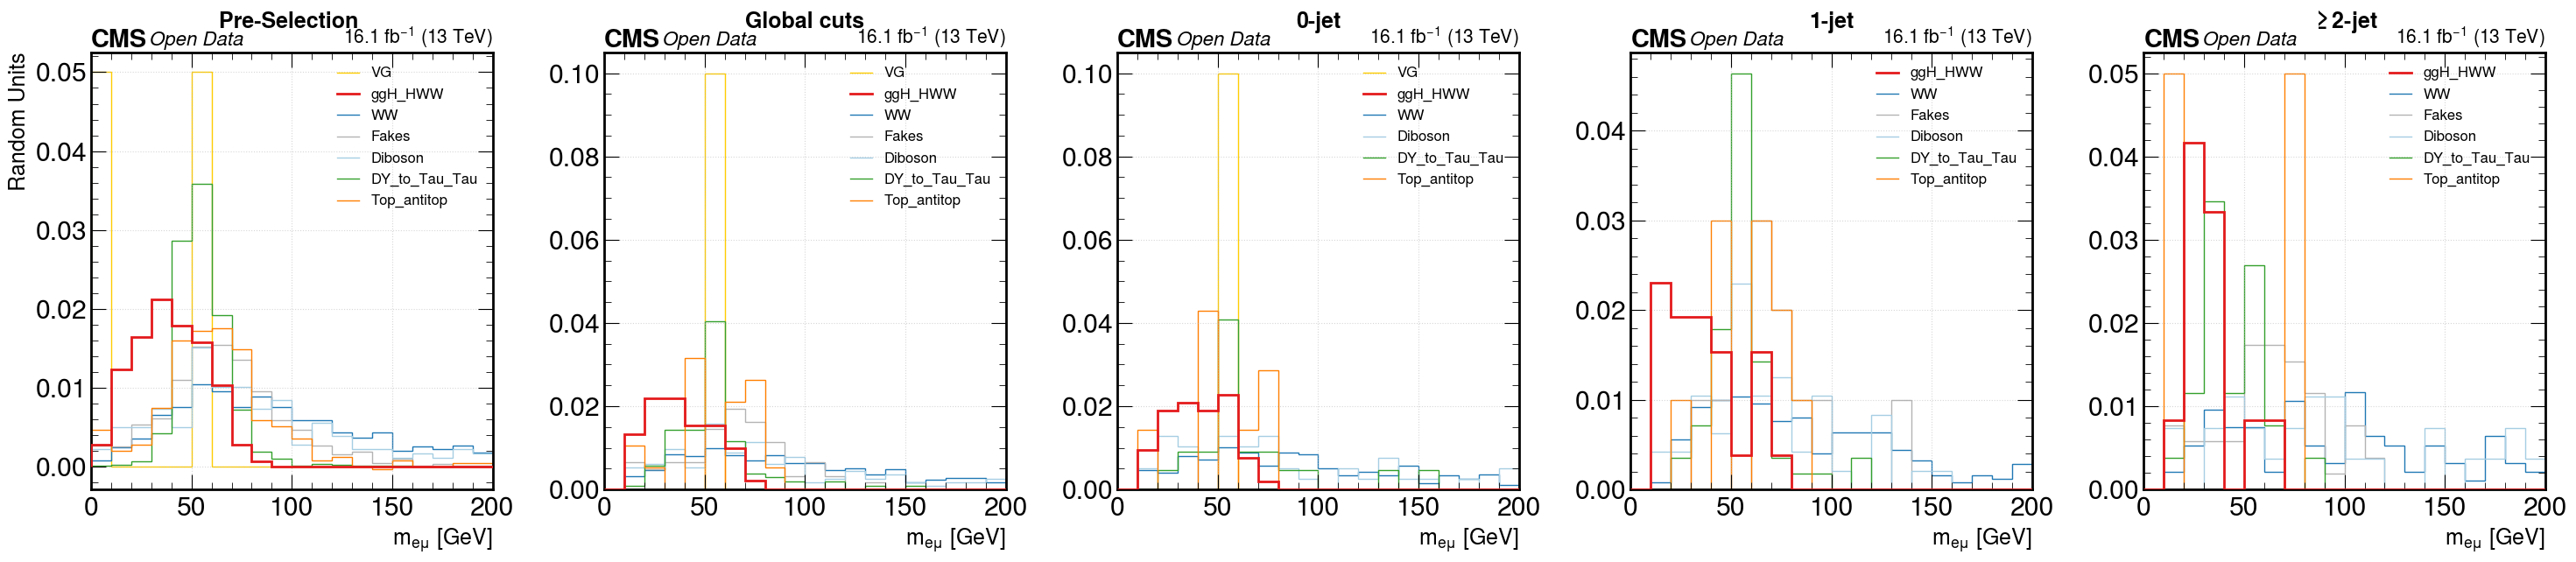


Plotting met...


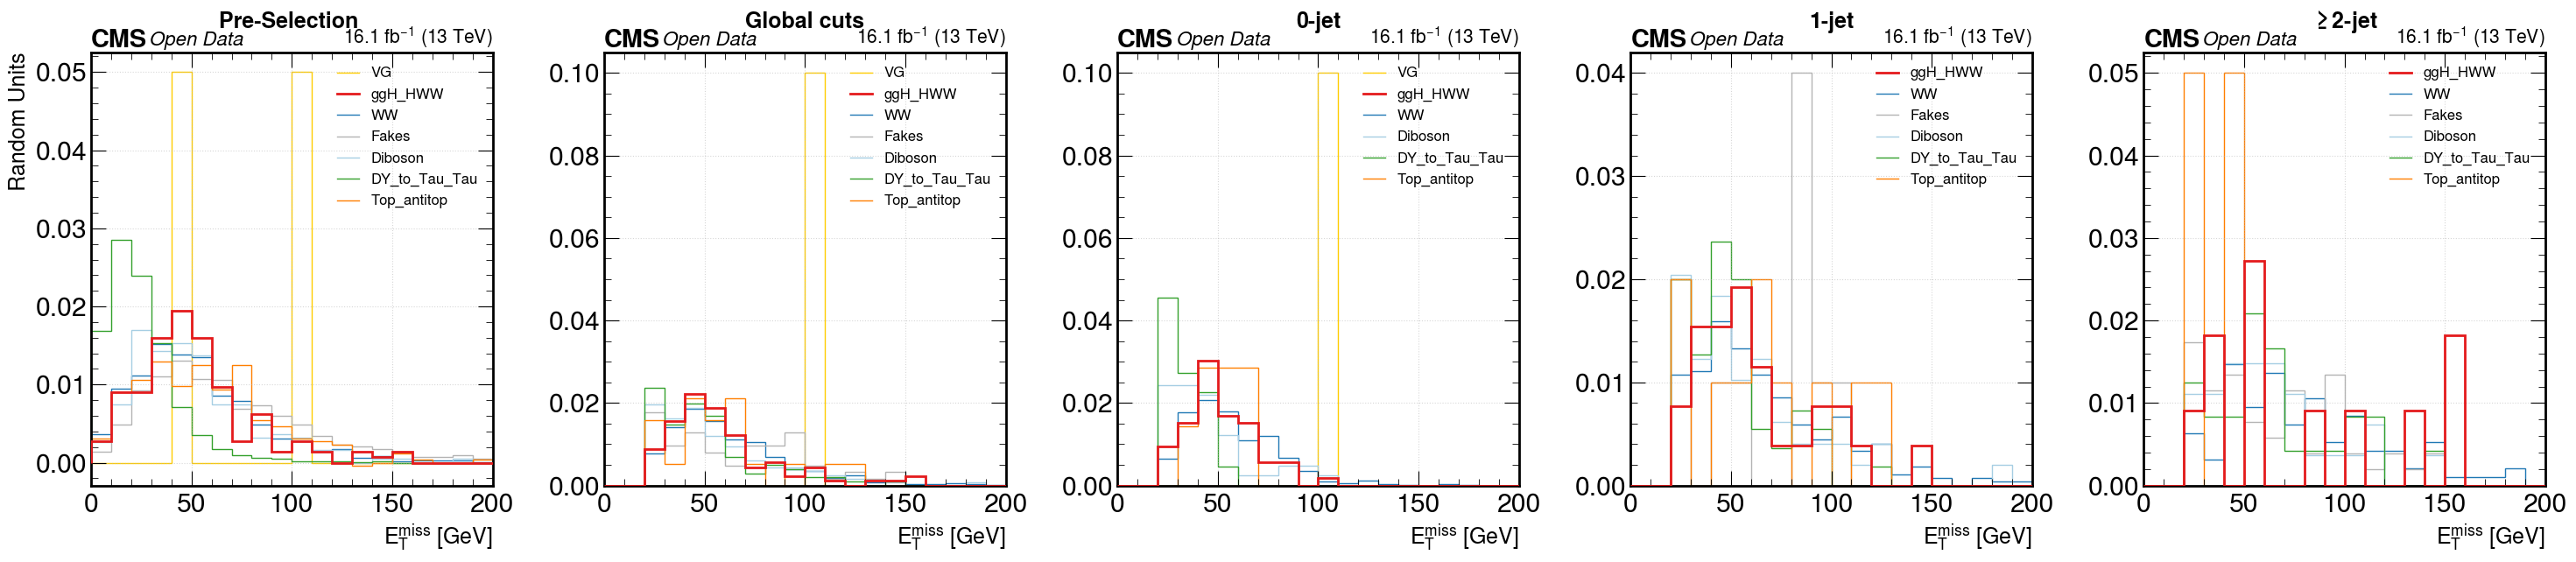


Plotting dphi...


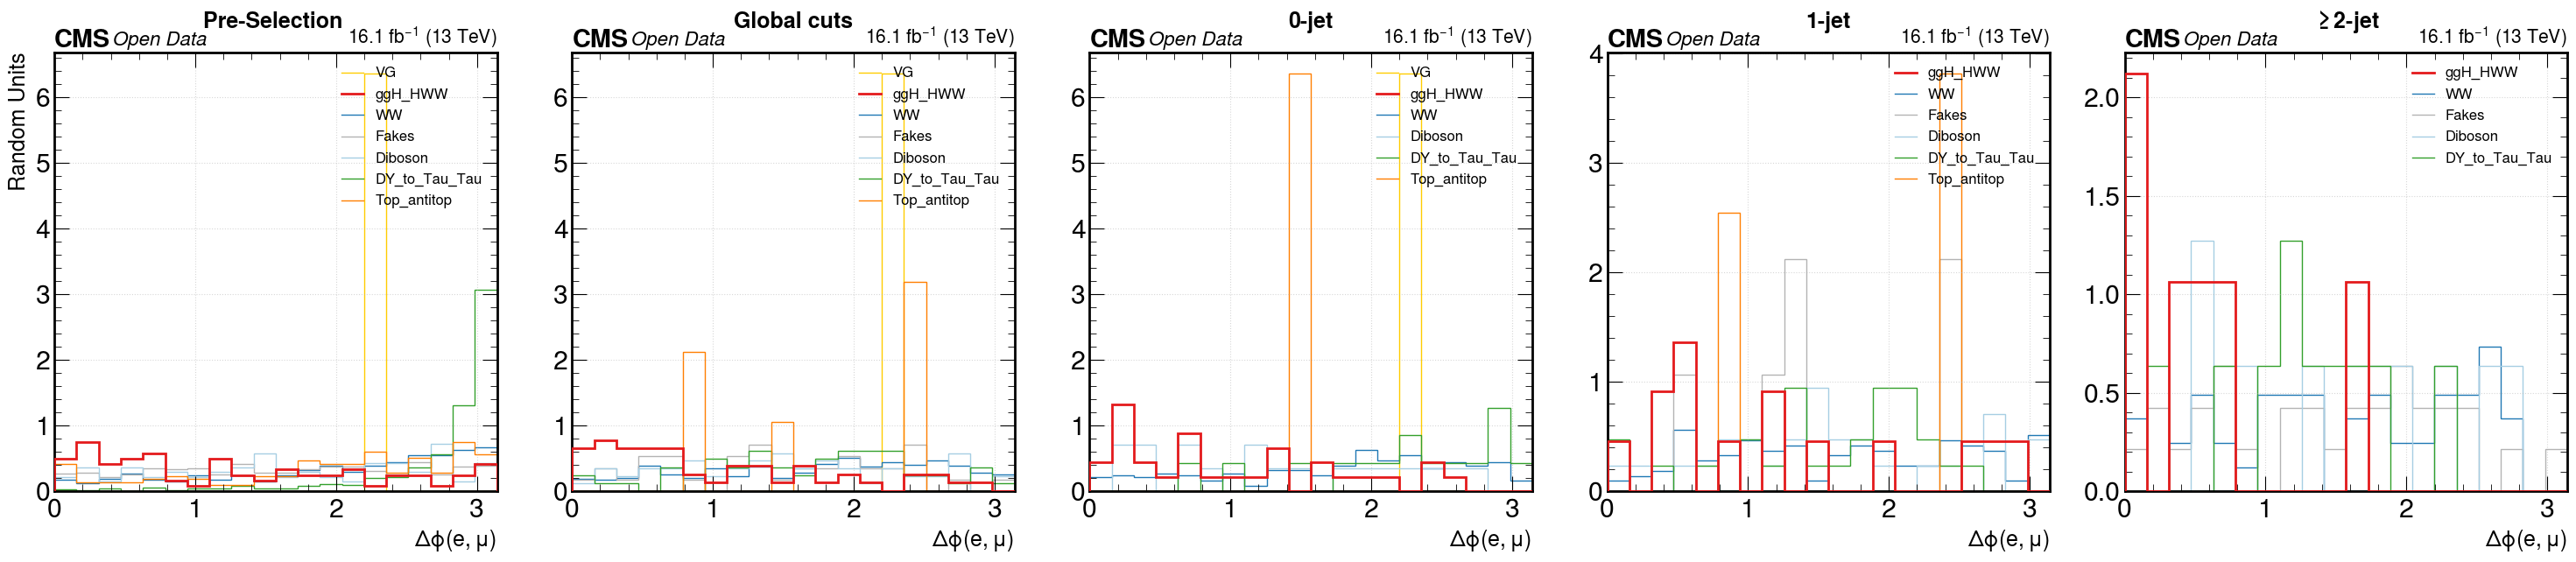


Plotting ptll...


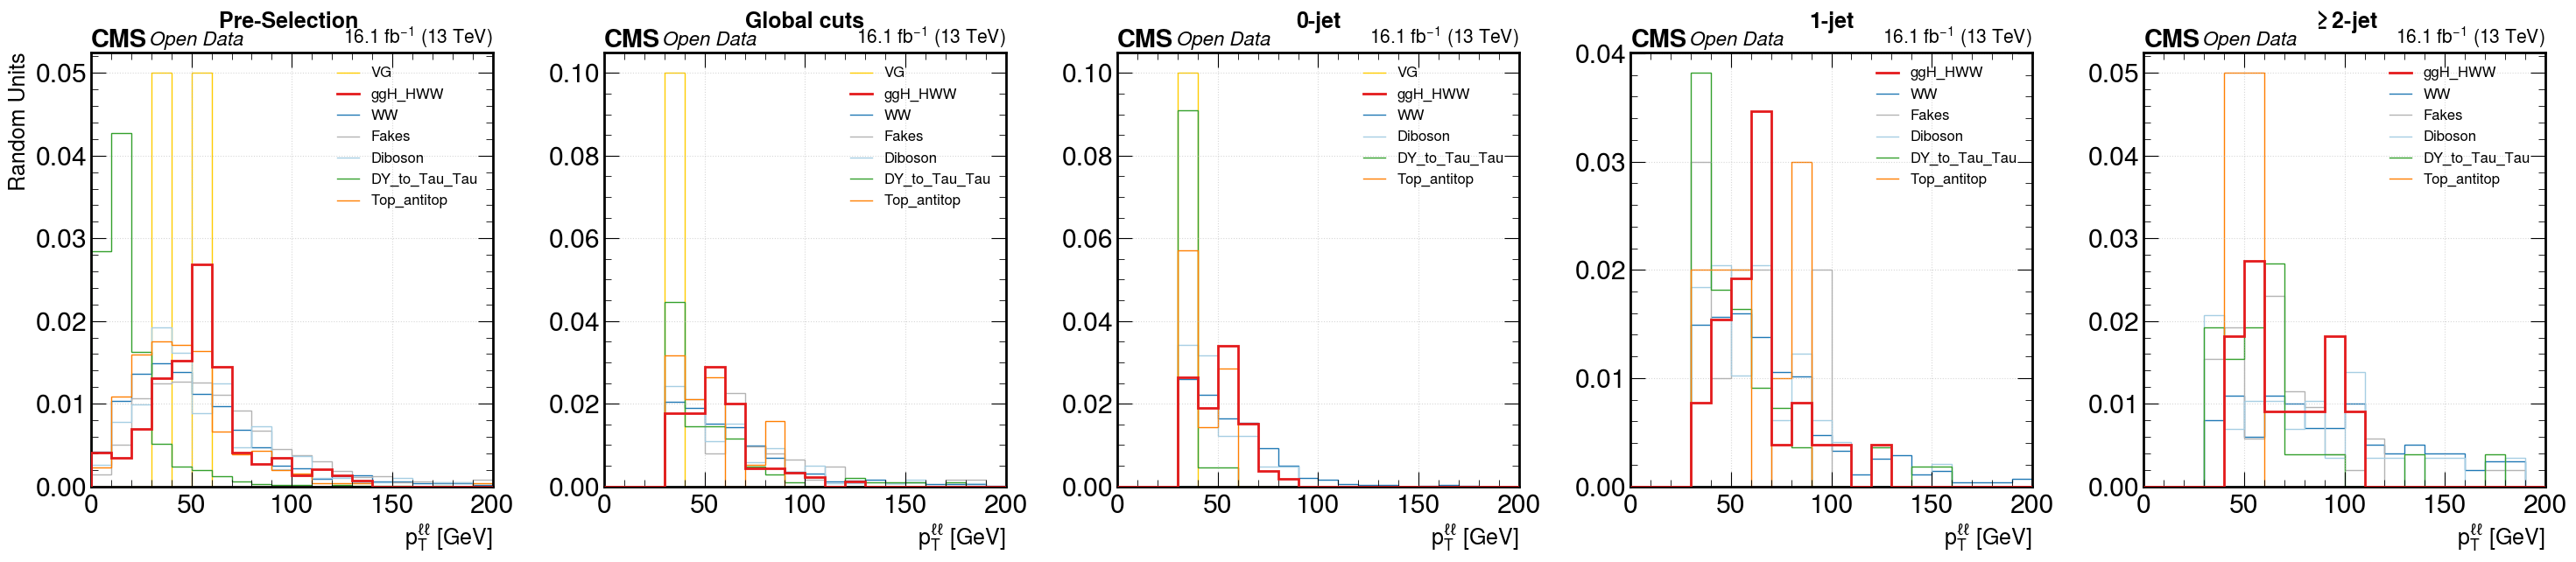


Plotting mt_higgs...


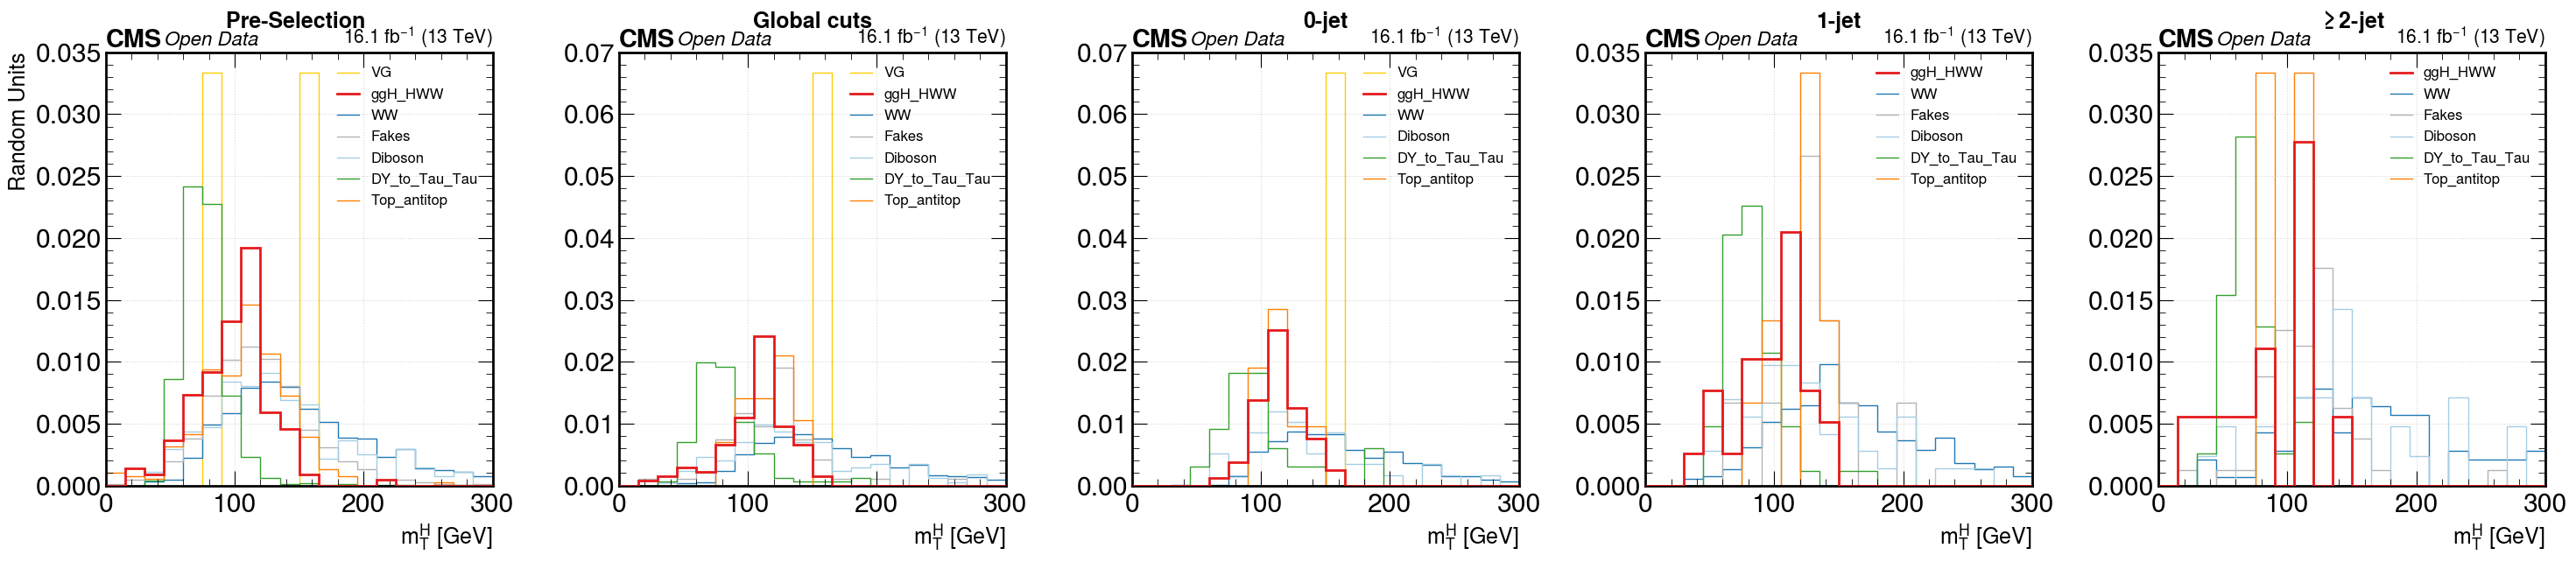


Plotting mt_l2_met...


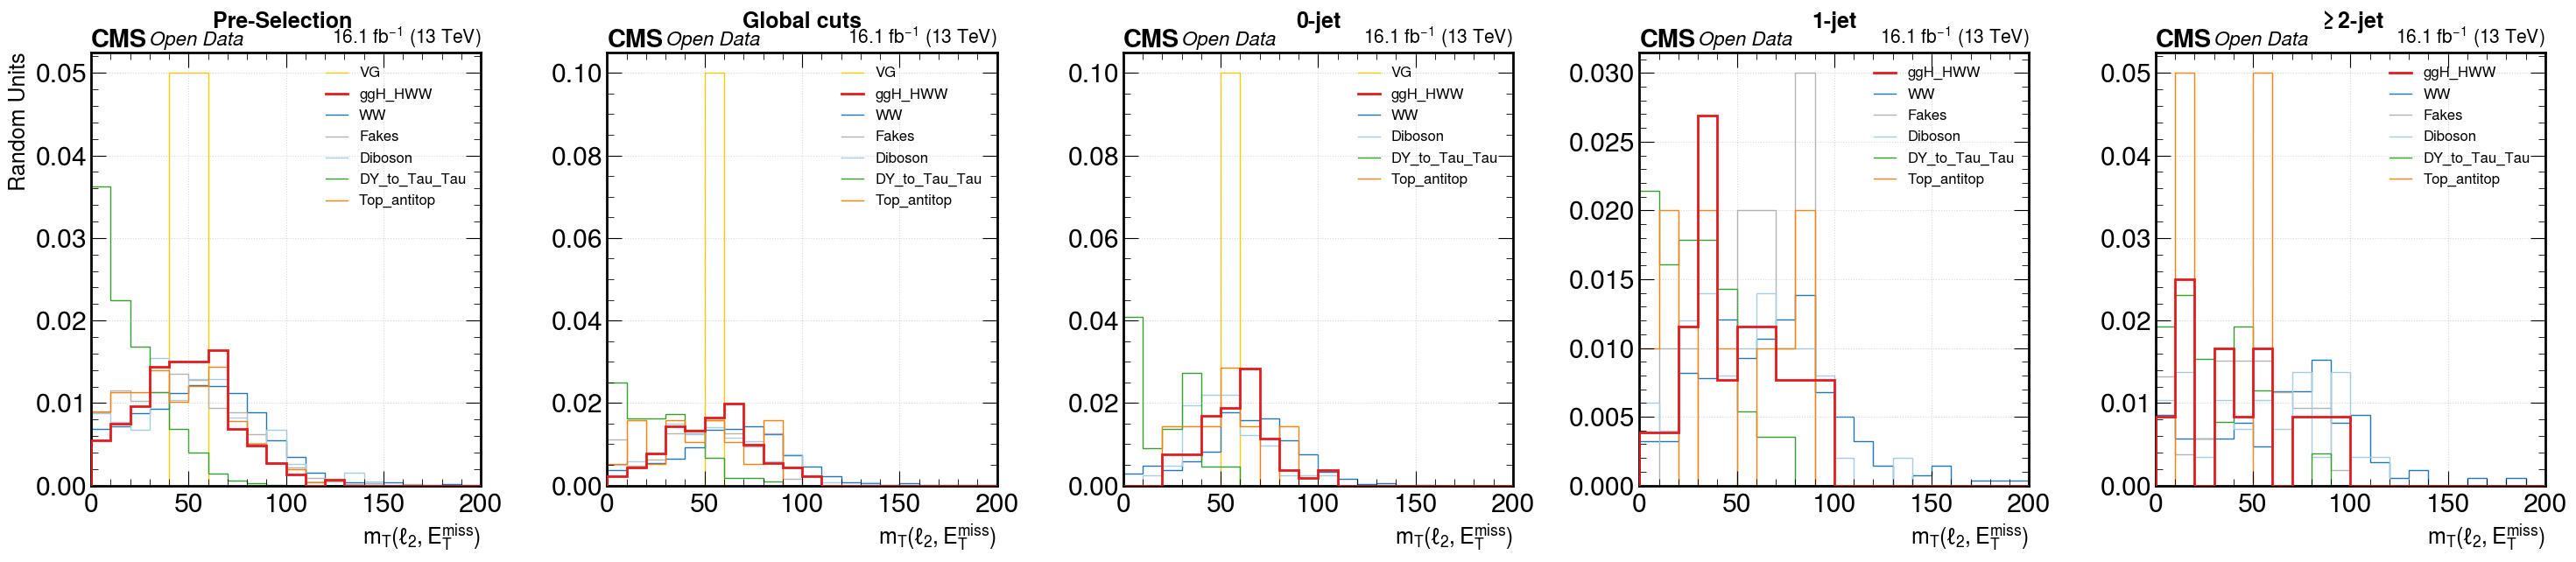


Plotting mjj...


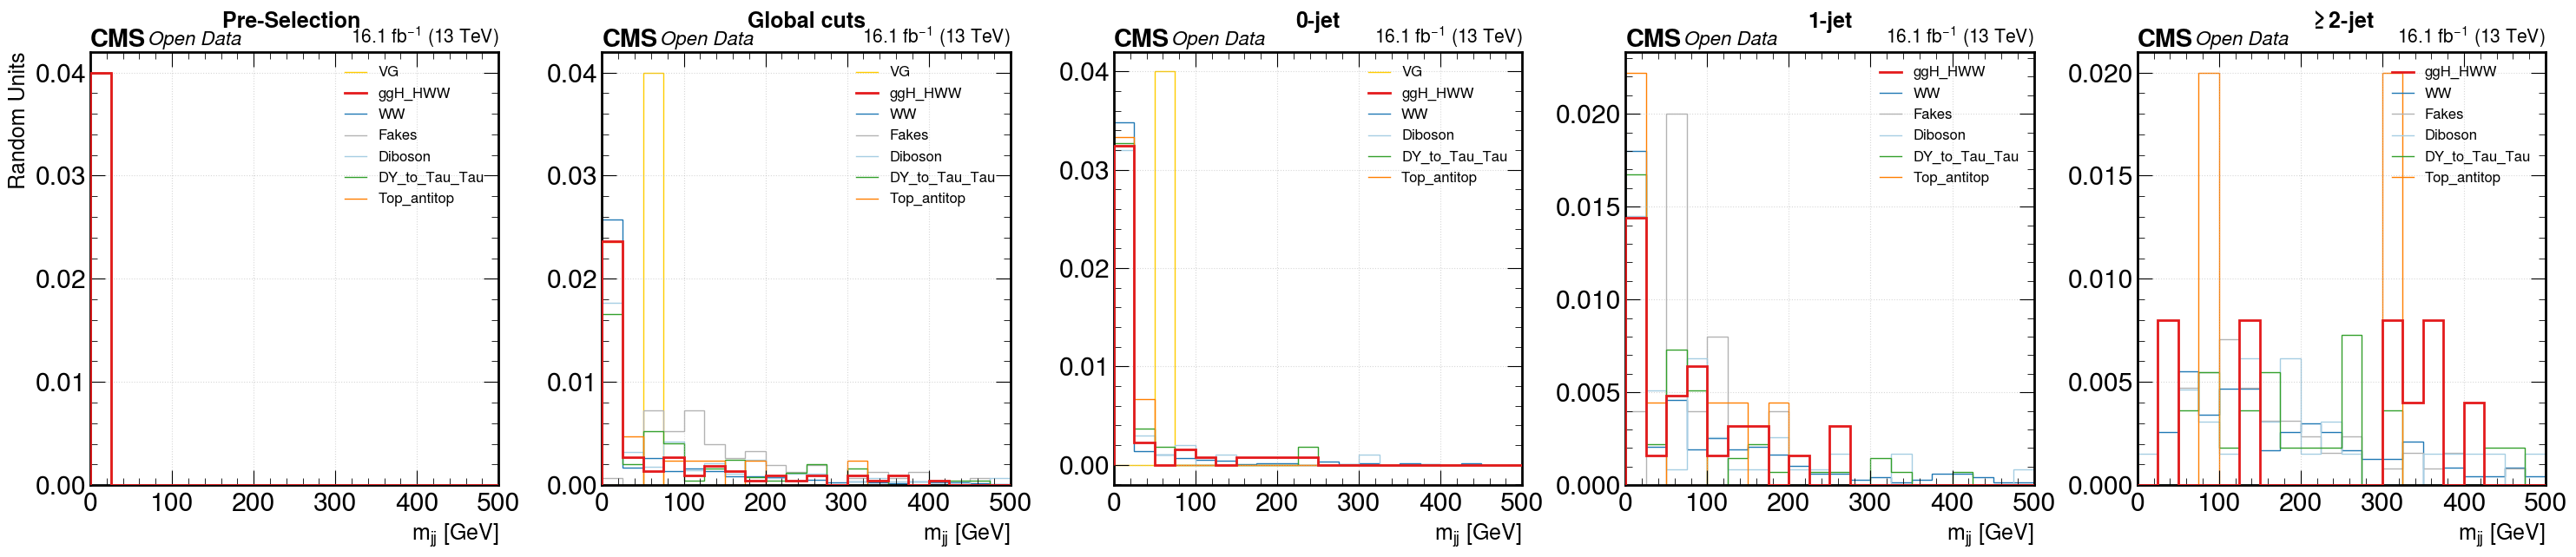


Plotting leading_pt...


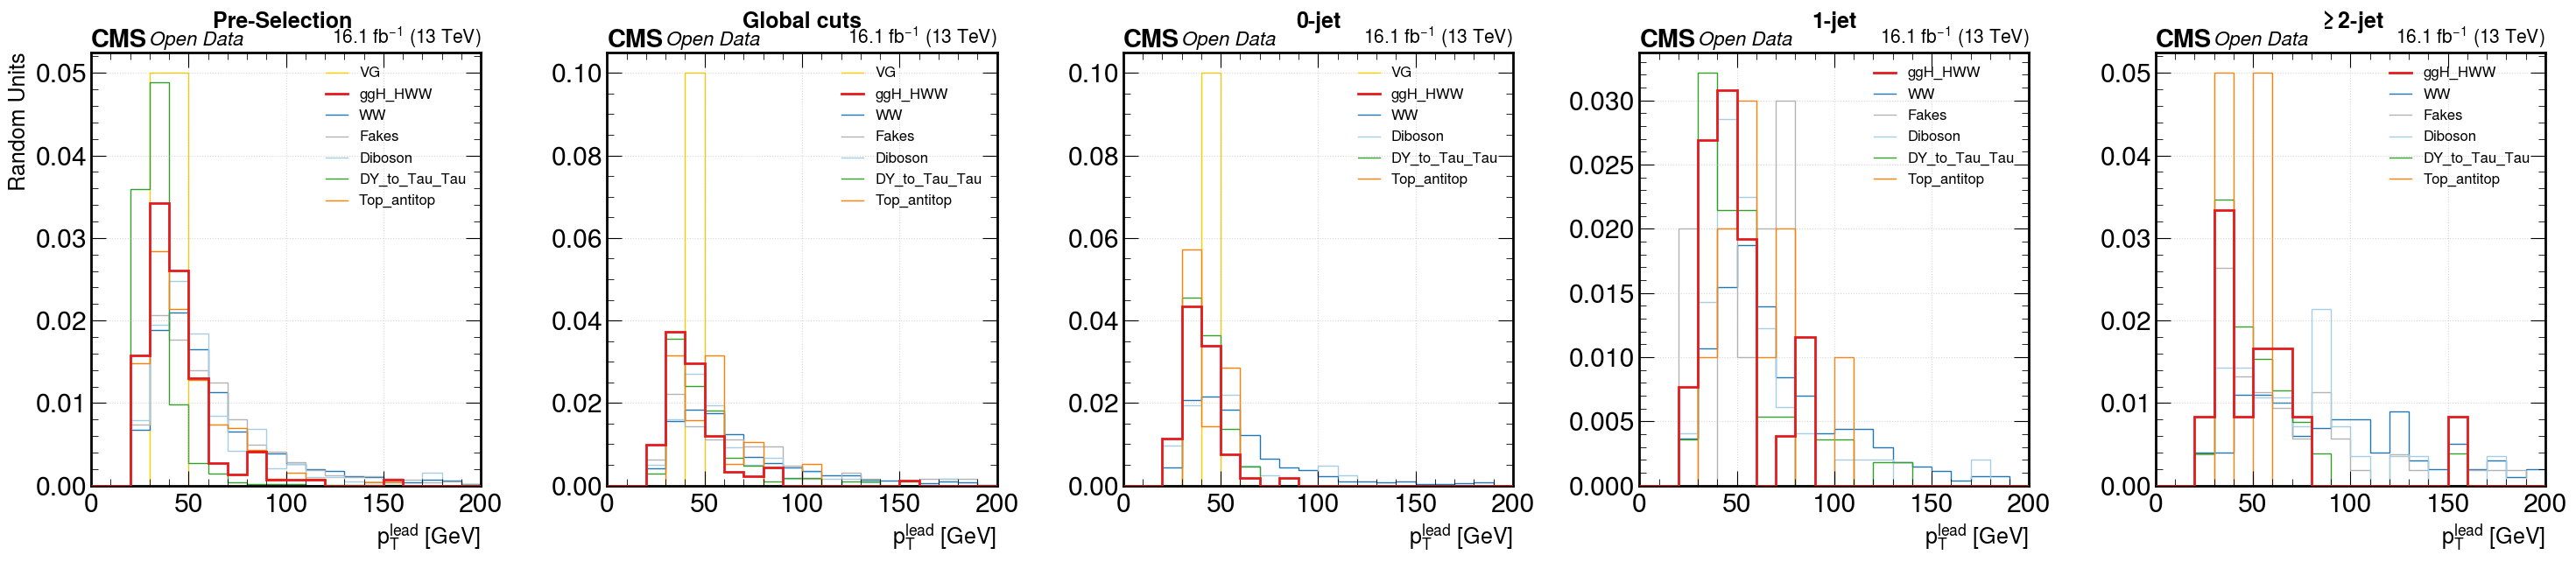


Plotting subleading_pt...


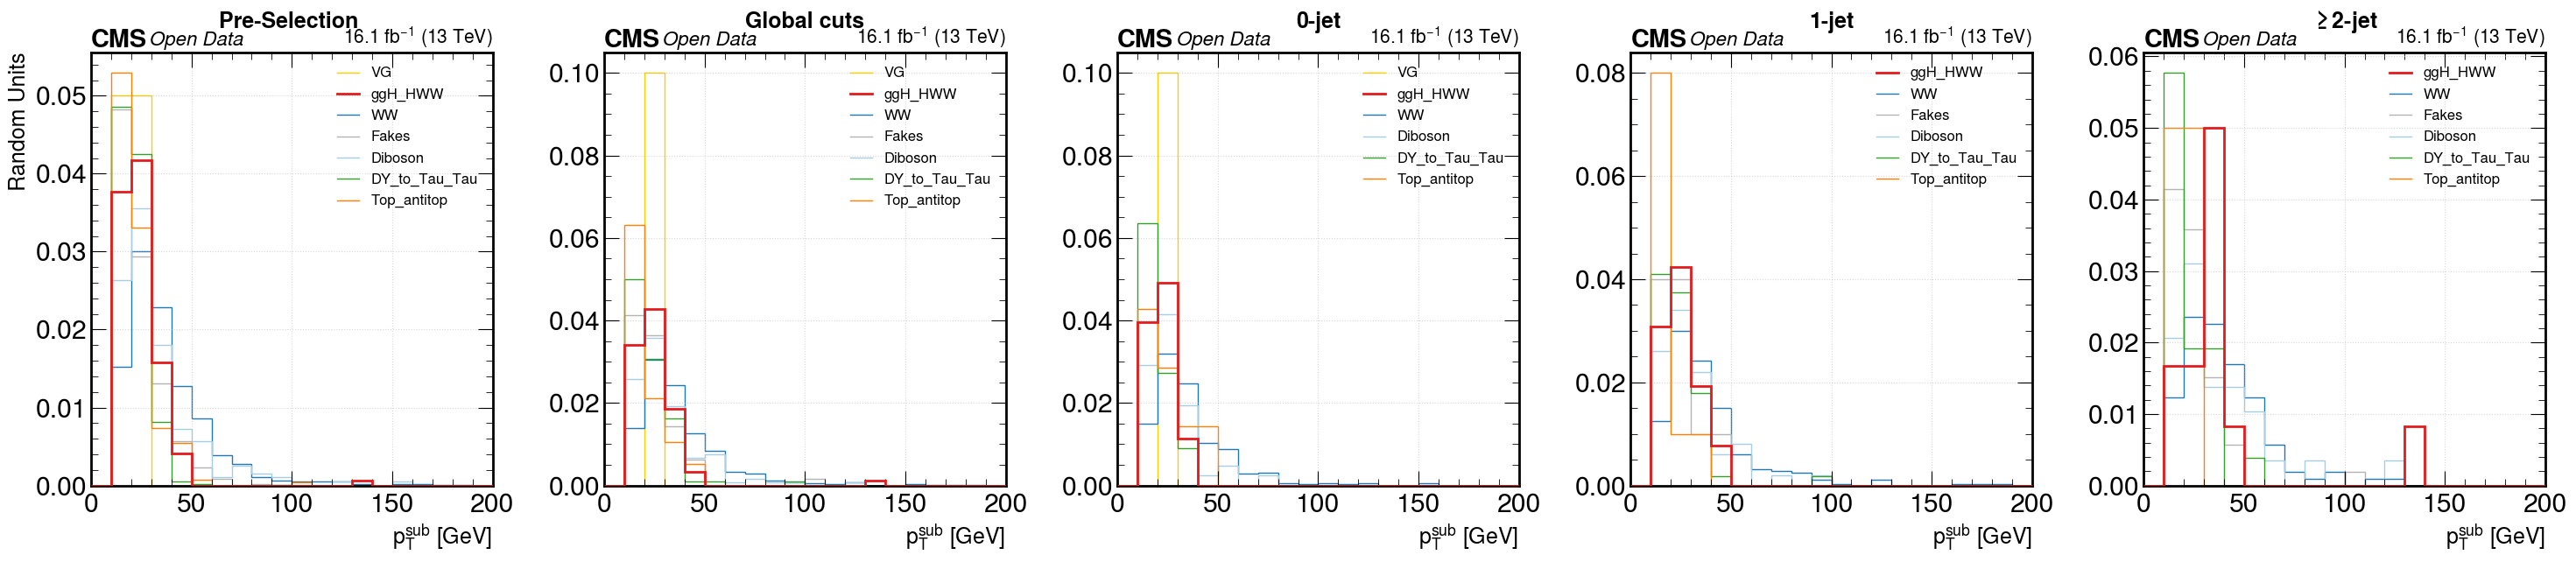

In [27]:
# Plot all variables
for var_name, var_props in variables_to_plots.items():
    print(f"\nPlotting {var_name}...")
    fig = plot_stage_comparison(var_name, var_props, hist_data_final)
    plt.show()

## Stacked plots

### Plot Settings

In [28]:
PLOT_SETTINGS = {
    # GROUP 1: SIGNAL REGION 
    "Signal_Region": {
        "plot_data": False, 
        "stages": [('SR_0jet', 'SR 0j'), ('SR_1jet', 'SR 1j'), ('SR_2jet', 'SR 2j')],
        "variables": {
            "mass":          {"log": True,  "xlim": (12, 200),  "ylim": (0.01, 5000)},
            "ptll":          {"log": True,  "xlim": (30, 200),  "ylim": (0.01, 5000)},
            "met":           {"log": True,  "xlim": (20, 200),  "ylim": (0.01, 5000)},
            "mt_higgs":      {"log": True,  "xlim": (60, 300),  "ylim": None},
            "mt_l2_met":     {"log": True,  "xlim": (30, 140),  "ylim": None},
            "mjj":           {"log": True,  "xlim": (0, 500),   "ylim": None}, 
            "dphi":          {"log": True,  "xlim": (0, 3.14),  "ylim": (0.01, 1000)},
            "leading_pt":    {"log": True,  "xlim": (25, 200),  "ylim": None},
            "subleading_pt": {"log": True,  "xlim": (10, 200),  "ylim": None},
        }
    },

    # GROUP 2: TOP CONTROL REGION 
    "Control_Region_Top": {
        "plot_data": True,
        "stages": [('CR_top_0jet', 'Top 0j'), ('CR_top_1jet', 'Top 1j'), ('CR_top_2jet', 'Top 2j')],
        "variables": {
            "mass":          {"log": True, "xlim": (50, 200),  "ylim": (1, 5000)},
            "ptll":          {"log": True, "xlim": (30, 200),  "ylim": (1, 2000)},
            "met":           {"log": True, "xlim": (20, 200),  "ylim": None},
            "mt_higgs":      {"log": True, "xlim": (60, 300),  "ylim": (1, 5000)},
            "mt_l2_met":     {"log": True, "xlim": (30, 150),  "ylim": None},
            "mjj":           {"log": True, "xlim": (0, 500),   "ylim": None},
            "dphi":          {"log": True, "xlim": (0, 3.14),  "ylim": (1, 1000)},
            "leading_pt":    {"log": True, "xlim": (25, 200),  "ylim": None},
            "subleading_pt": {"log": True, "xlim": (10, 200),  "ylim": None},
        }
    },

    # GROUP 3: TAU CONTROL REGION 
    "Control_Region_Tau": {
        "plot_data": True,
        "stages": [('CR_tau_0jet', r'DY-$\tau\tau$ 0j'), ('CR_tau_1jet', r'DY-$\tau\tau$ 1j'), ('CR_tau_2jet', r'DY-$\tau\tau$ 2j')],
        "variables": {
            "mass":          {"log": True, "xlim": (40, 60),   "ylim": (0.01, 1000)},
            "ptll":          {"log": True, "xlim": (30, 100),  "ylim": (0.01, 1000)},
            "met":           {"log": True, "xlim": (20, 100),   "ylim": (0.01, 1000)},
            "mt_higgs":      {"log": True, "xlim": (0, 60),    "ylim": (0.01, 1000)},
            "mt_l2_met":     {"log": True, "xlim": (30, 50),   "ylim": (0.01, 1000)},
            "mjj":           {"log": True, "xlim": (0, 500),   "ylim": None},
            "dphi":          {"log": True, "xlim": (1.5, 3.14),  "ylim": (0.01, 1000)},
            "leading_pt":    {"log": True, "xlim": (30, 80),  "ylim": (0.01, 1000)},
            "subleading_pt": {"log": True, "xlim": (10, 30),   "ylim": None},
        }
    }
}

# VAR_LABELS = {
#     'mass': r'$m_{e\mu}$ [GeV]',
#     'met': r'$E_{\mathrm{T}}^{\mathrm{miss}}$ [GeV]',
#     'ptll': r'$p_{\mathrm{T}}^{\ell\ell}$ [GeV]',
#     'dphi': r'$\Delta\phi(e,\mu)$',
#     'mt_higgs': r'$m_{\mathrm{T}}^{H}$ [GeV]',
#     'mt_l2_met': r'$m_{\mathrm{T}}(\ell_2, E_{\mathrm{T}}^{\mathrm{miss}})$',
#     'mjj': r'$m_{jj}$ [GeV]',
#     'leading_pt': r'$p_{\mathrm{T}}^{\mathrm{lead}}$ [GeV]',
#     'subleading_pt': r'$p_{\mathrm{T}}^{\mathrm{sub}}$ [GeV]',
# }

## Helper Function

In [29]:
def get_histogram_data(hist_data_all, sample, stage, variable):
    
    try:
        h = hist_data_all[sample][stage][variable]
        if hasattr(h, 'to_numpy'): return h.to_numpy()
        elif hasattr(h, 'values'): return h.values(), h.axes[0].edges
        else: return None, None
    except (KeyError, AttributeError): return None, None

## Plotting

Plotting mass in Signal_Region...
Saved: plots_mplhep/CMS_Signal_Region_mass.png


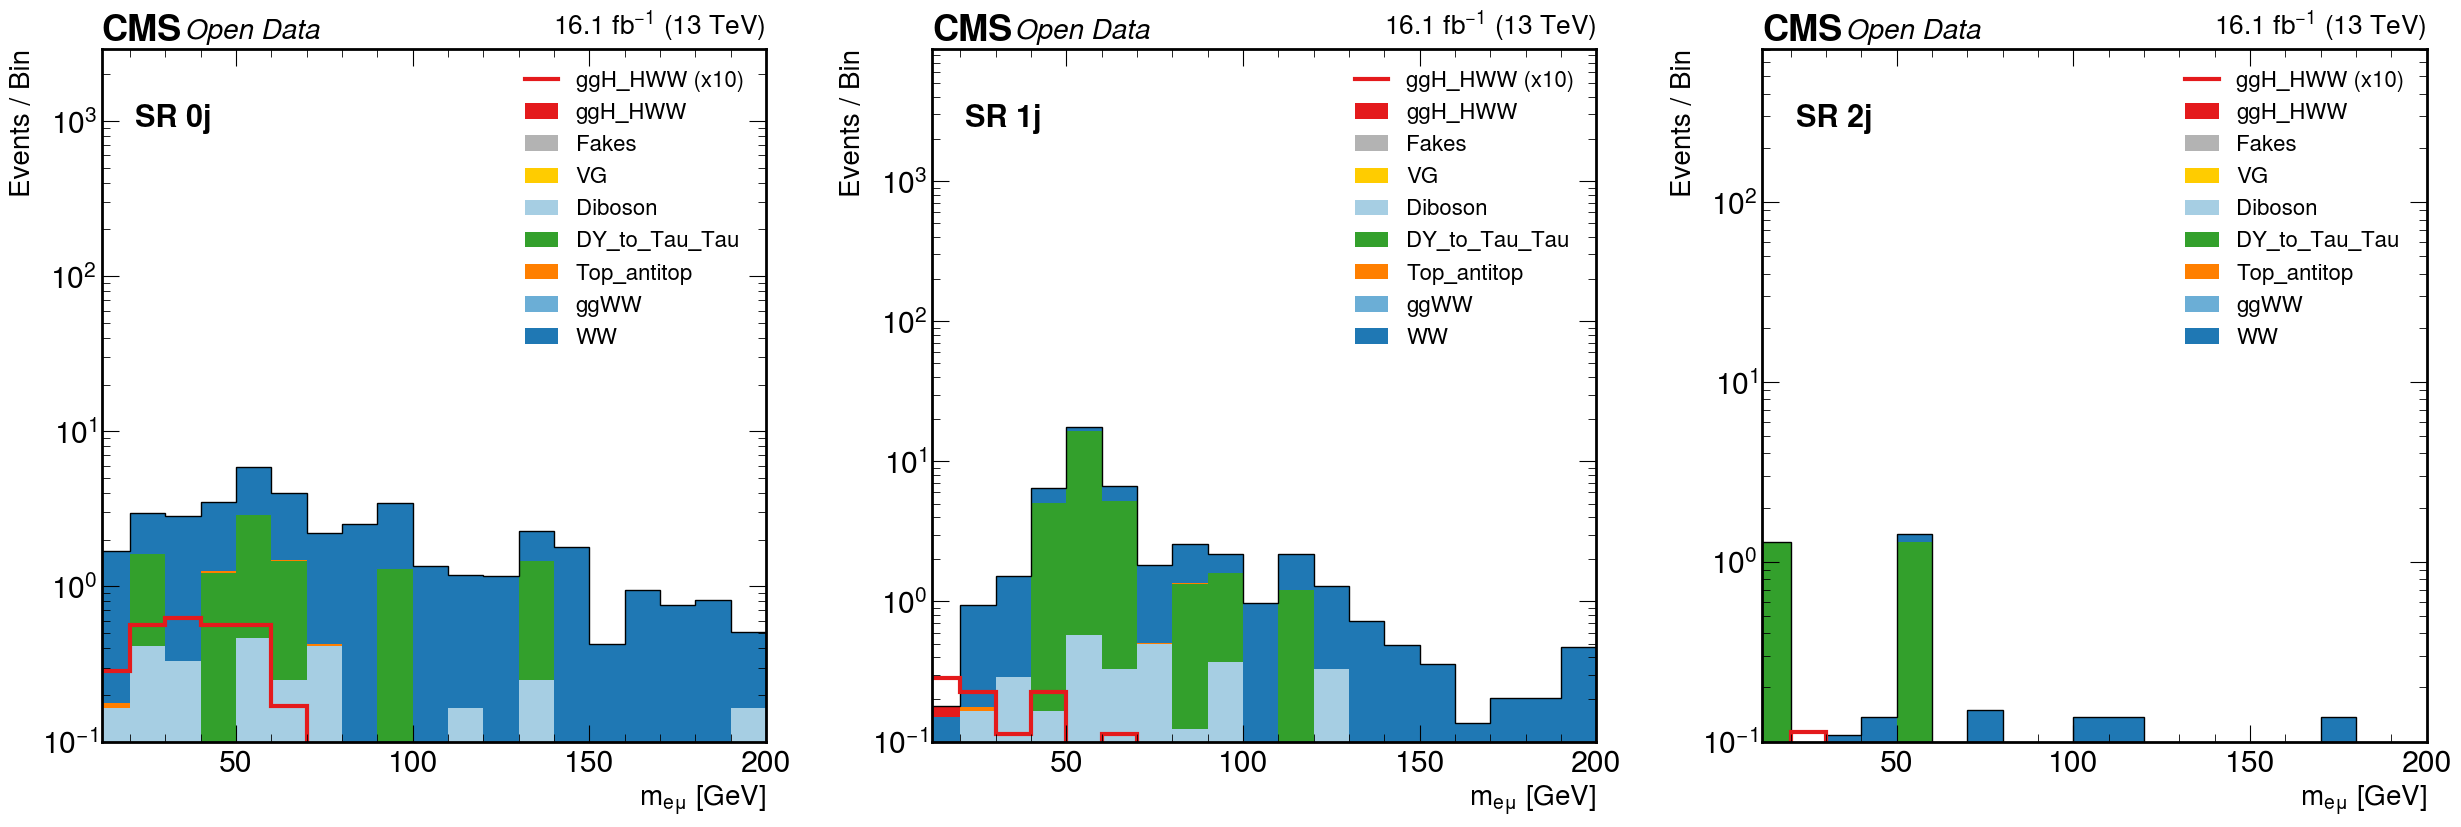

Plotting mass in Control_Region_Top...
Saved: plots_mplhep/CMS_Control_Region_Top_mass.png


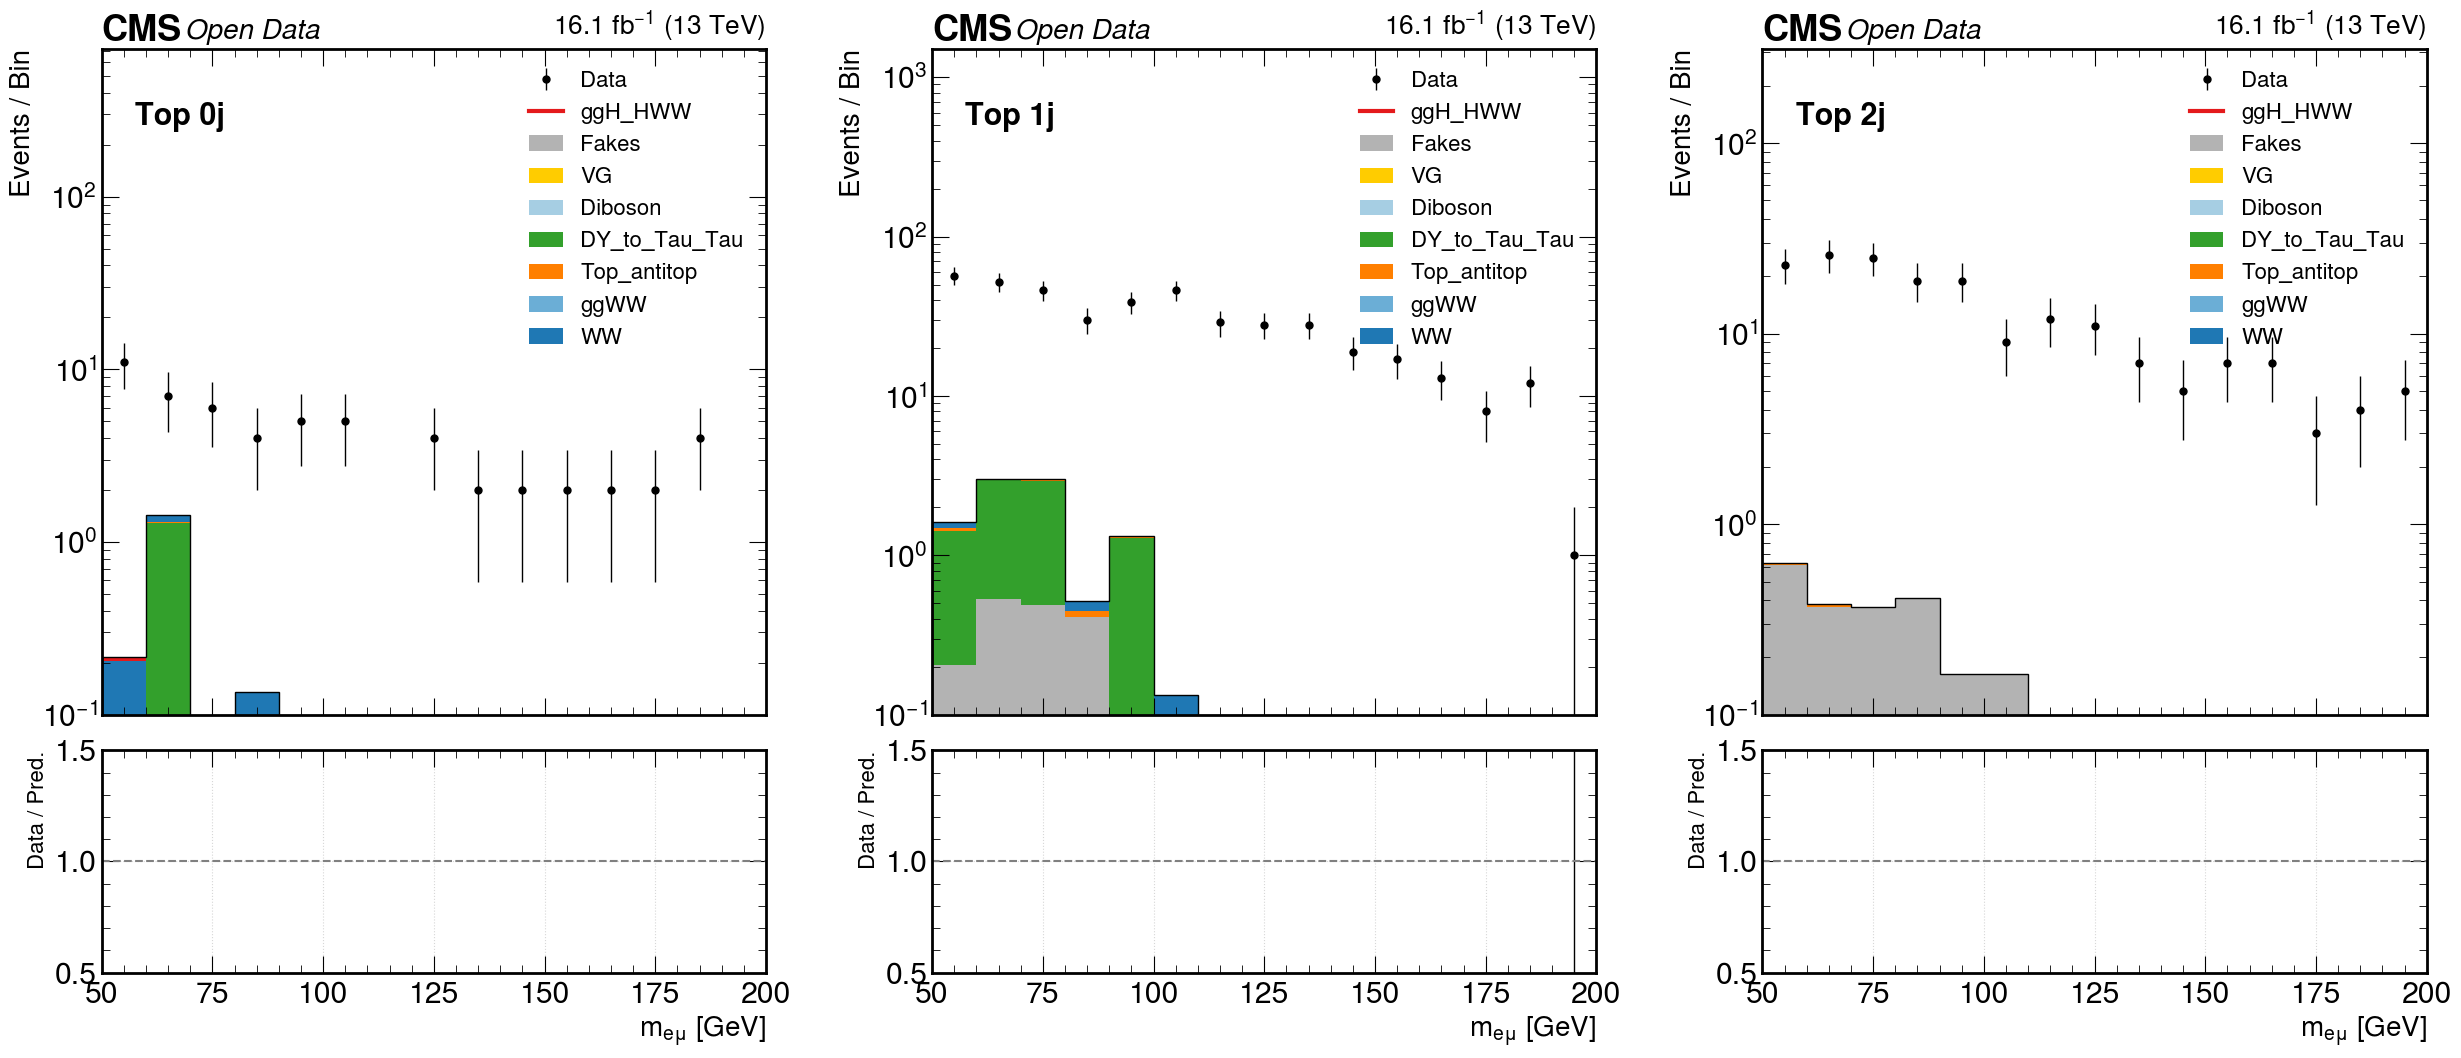

Plotting mass in Control_Region_Tau...


/tmp/ipykernel_287/3355168007.py:137: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: plots_mplhep/CMS_Control_Region_Tau_mass.png


Plotting met in Signal_Region...
Saved: plots_mplhep/CMS_Signal_Region_met.png


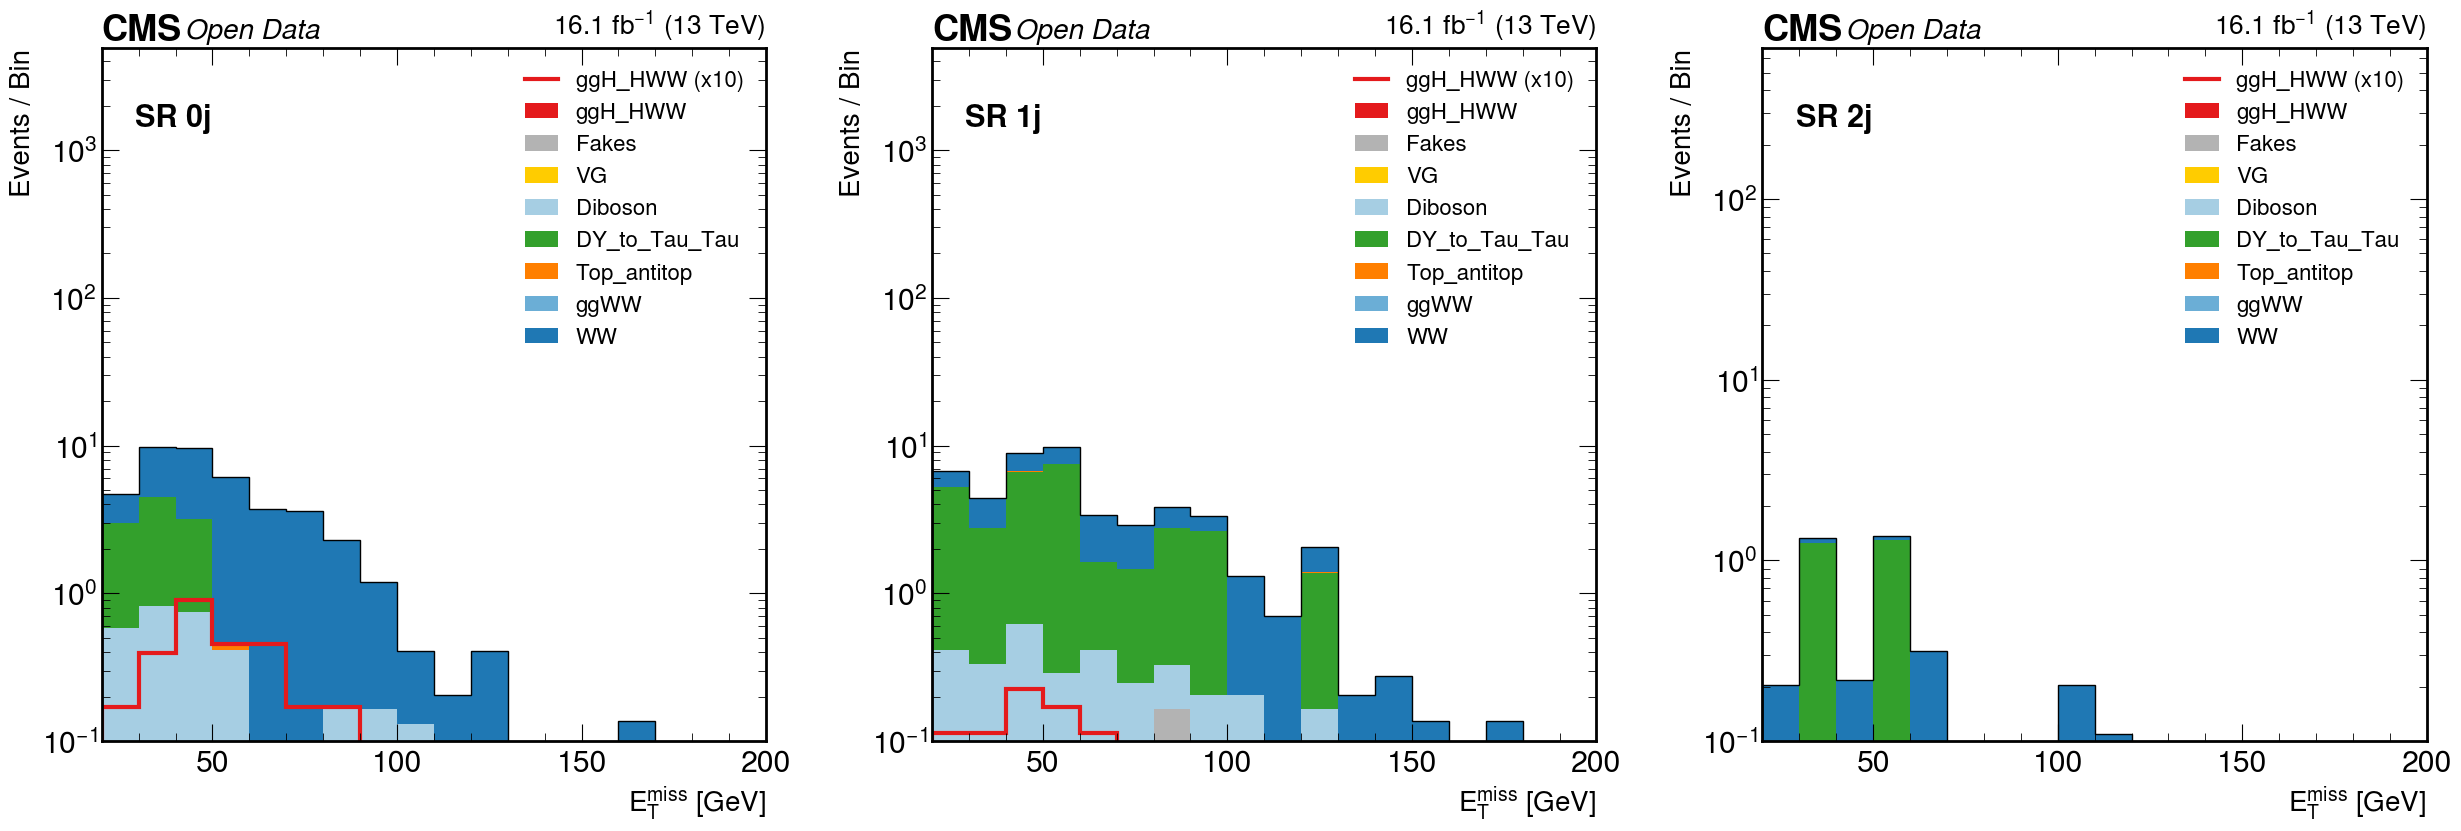

Plotting met in Control_Region_Top...
Saved: plots_mplhep/CMS_Control_Region_Top_met.png


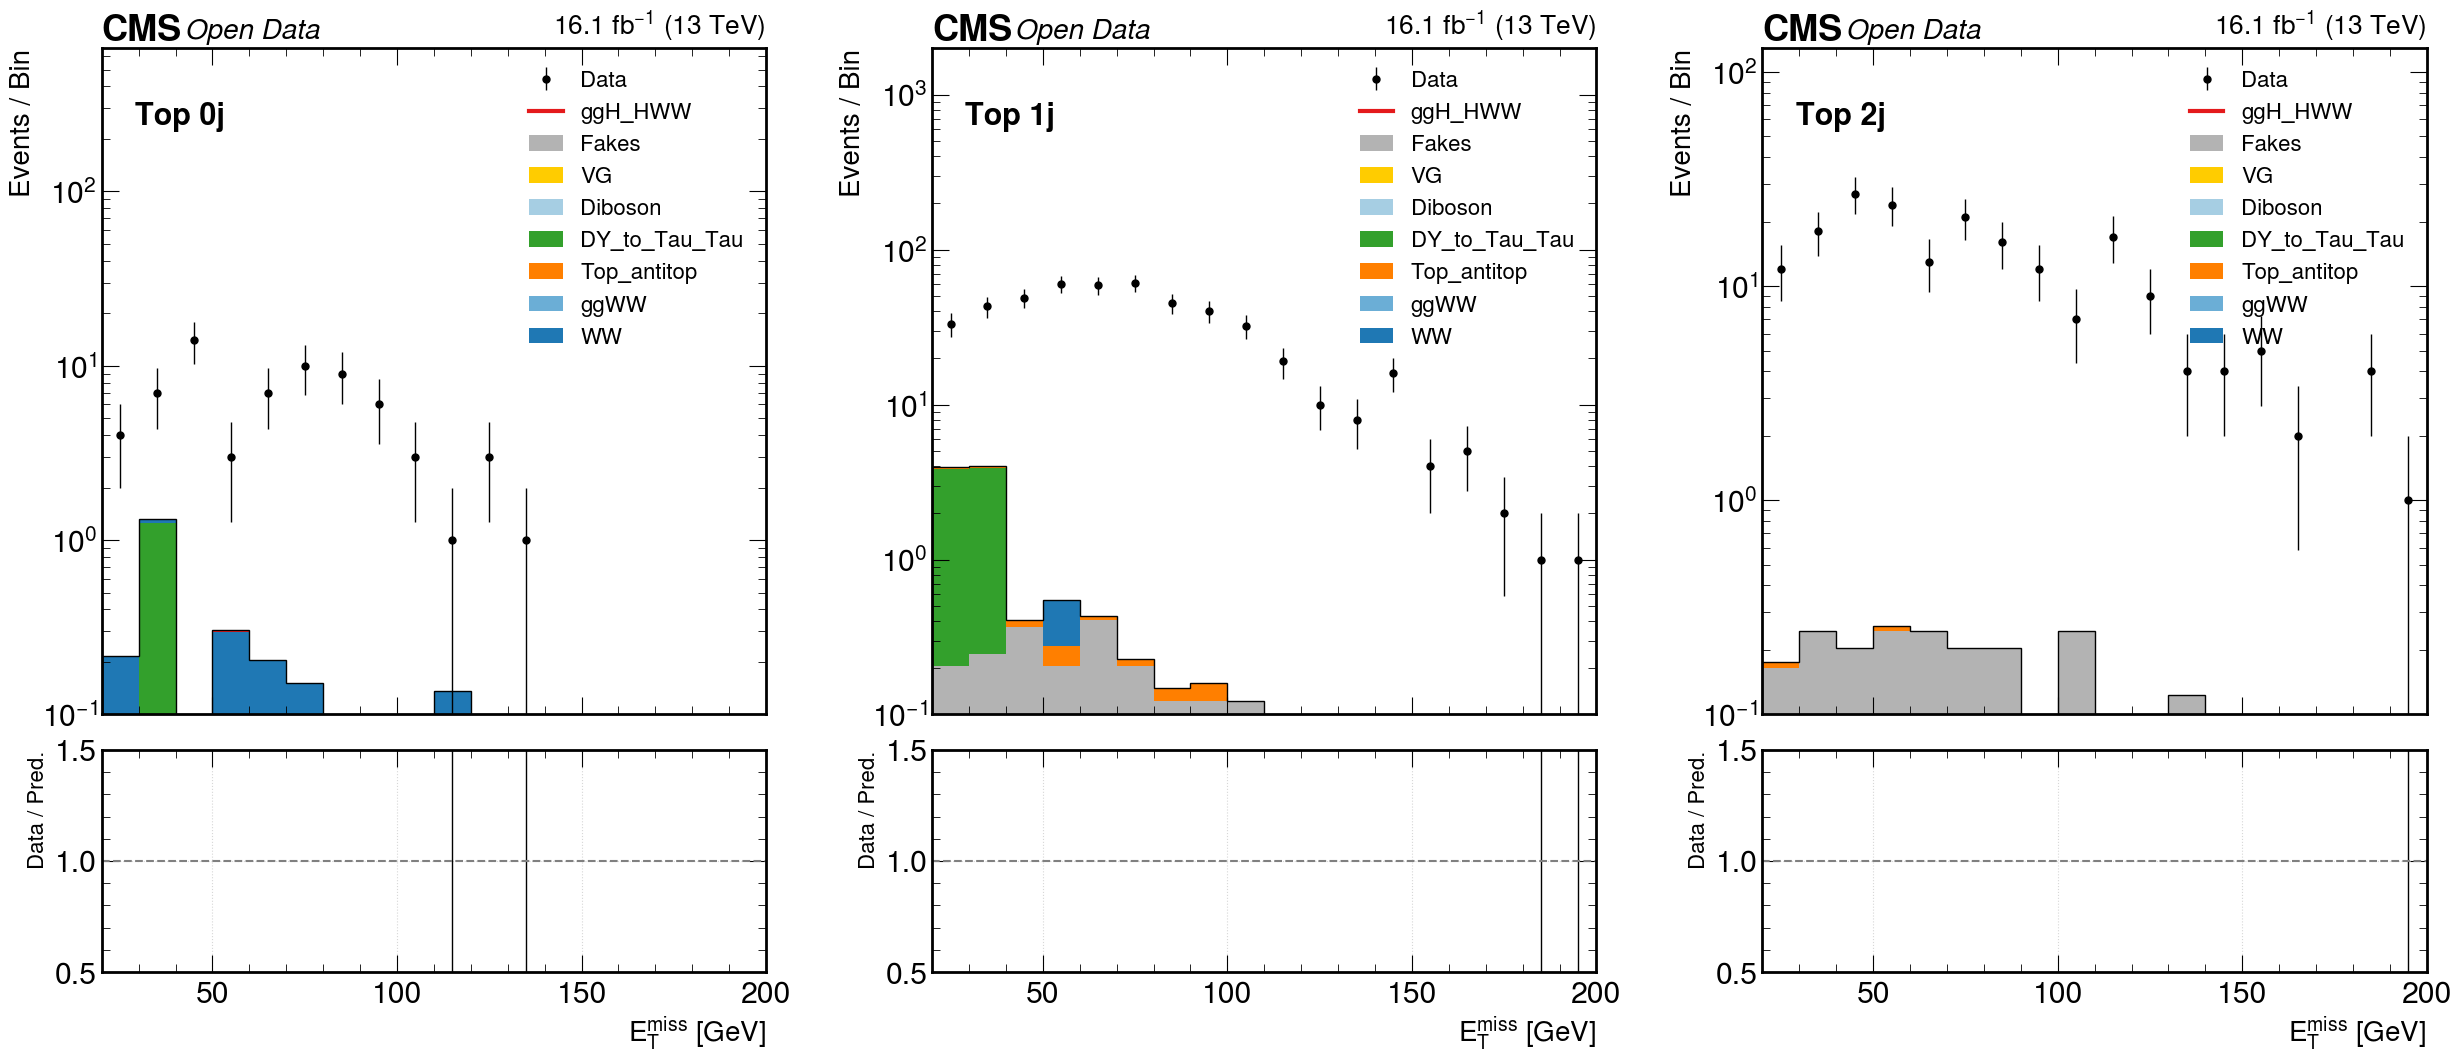

Plotting met in Control_Region_Tau...


/tmp/ipykernel_287/3355168007.py:137: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: plots_mplhep/CMS_Control_Region_Tau_met.png


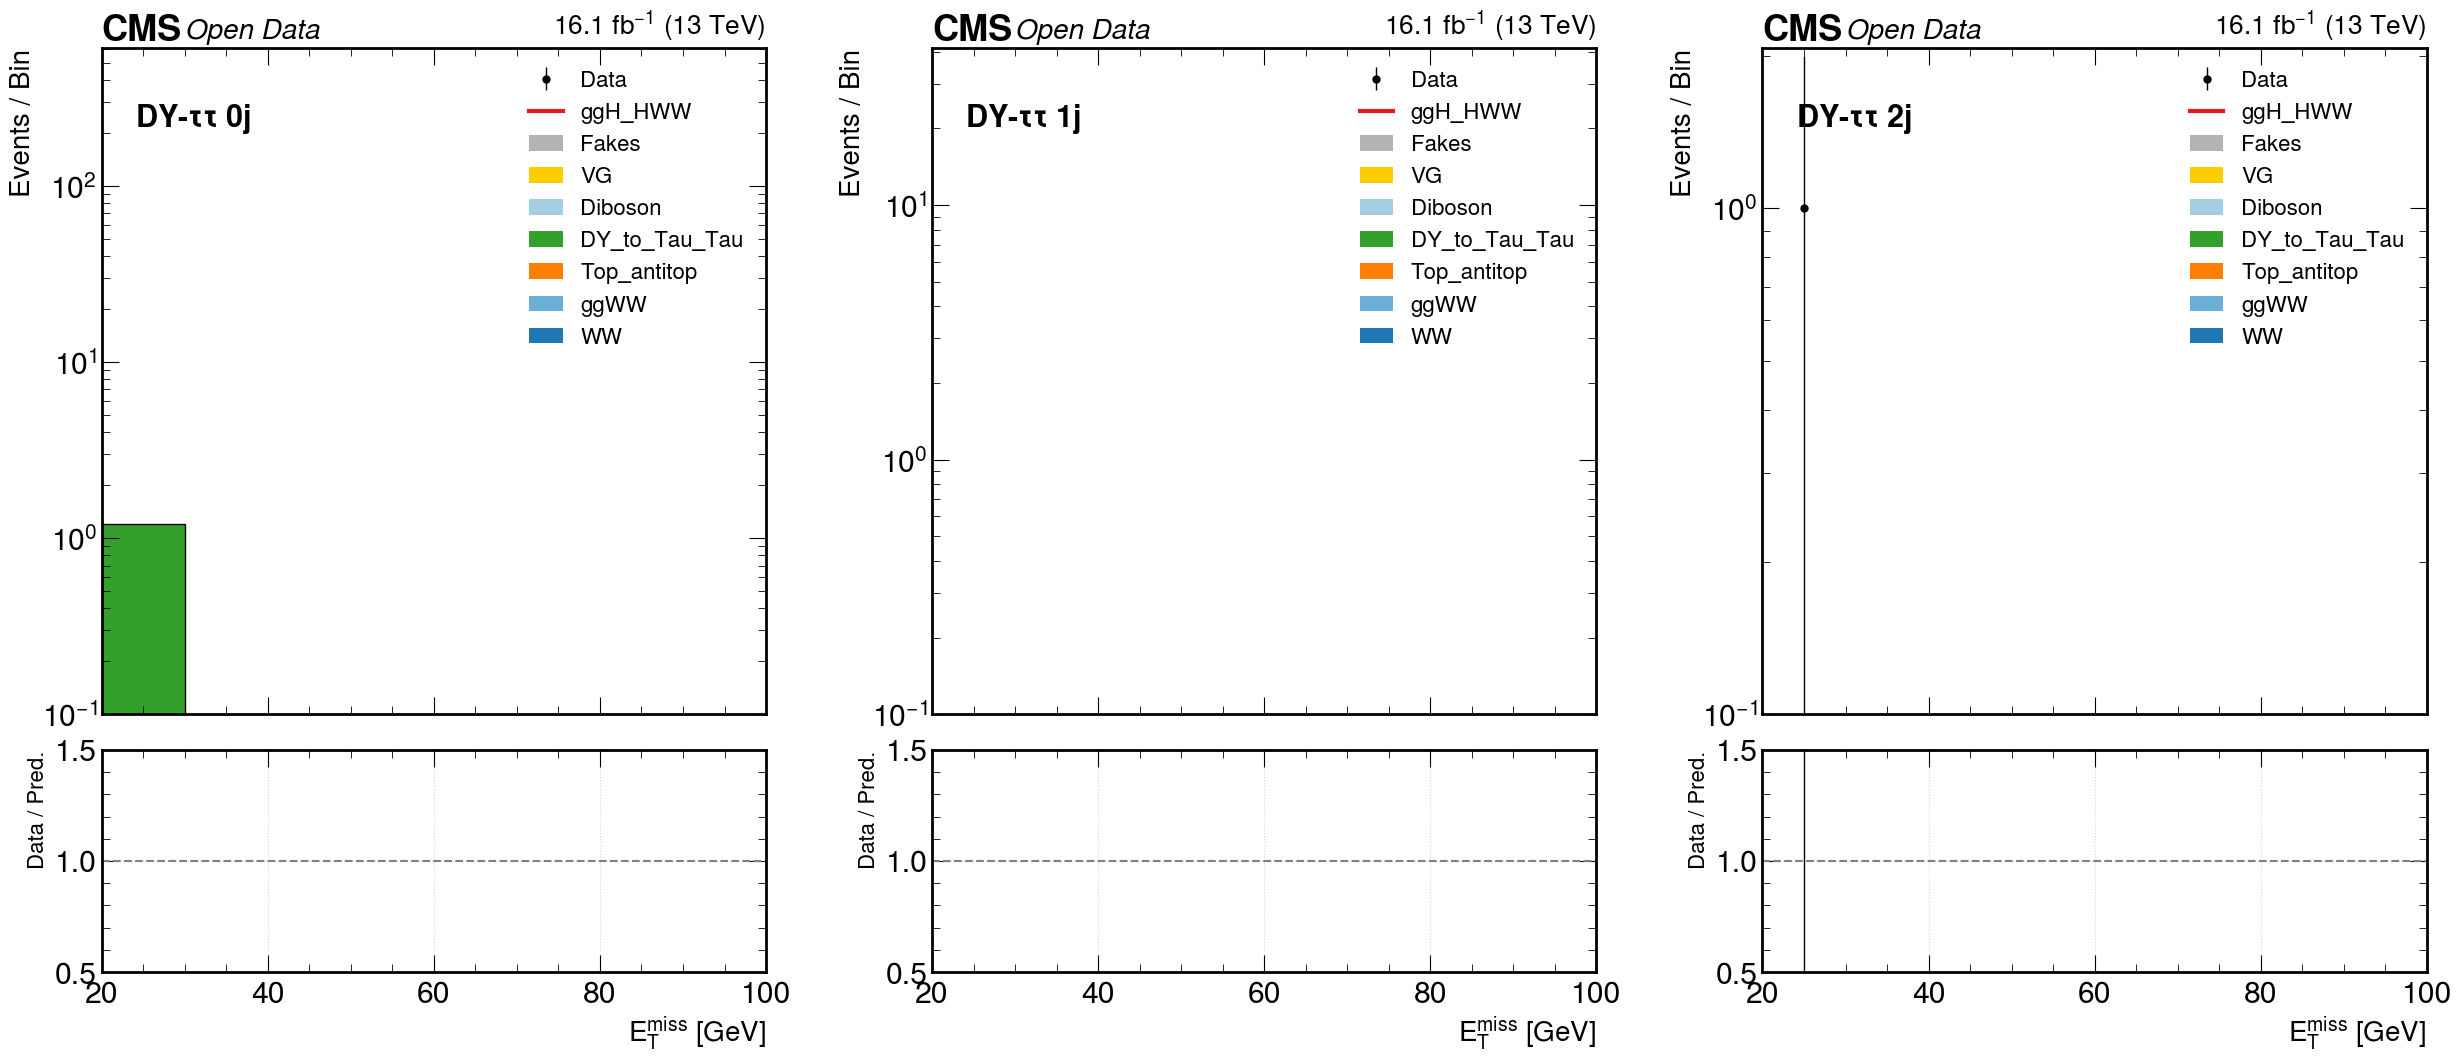

Plotting ptll in Signal_Region...
Saved: plots_mplhep/CMS_Signal_Region_ptll.png


Plotting ptll in Control_Region_Top...
Saved: plots_mplhep/CMS_Control_Region_Top_ptll.png


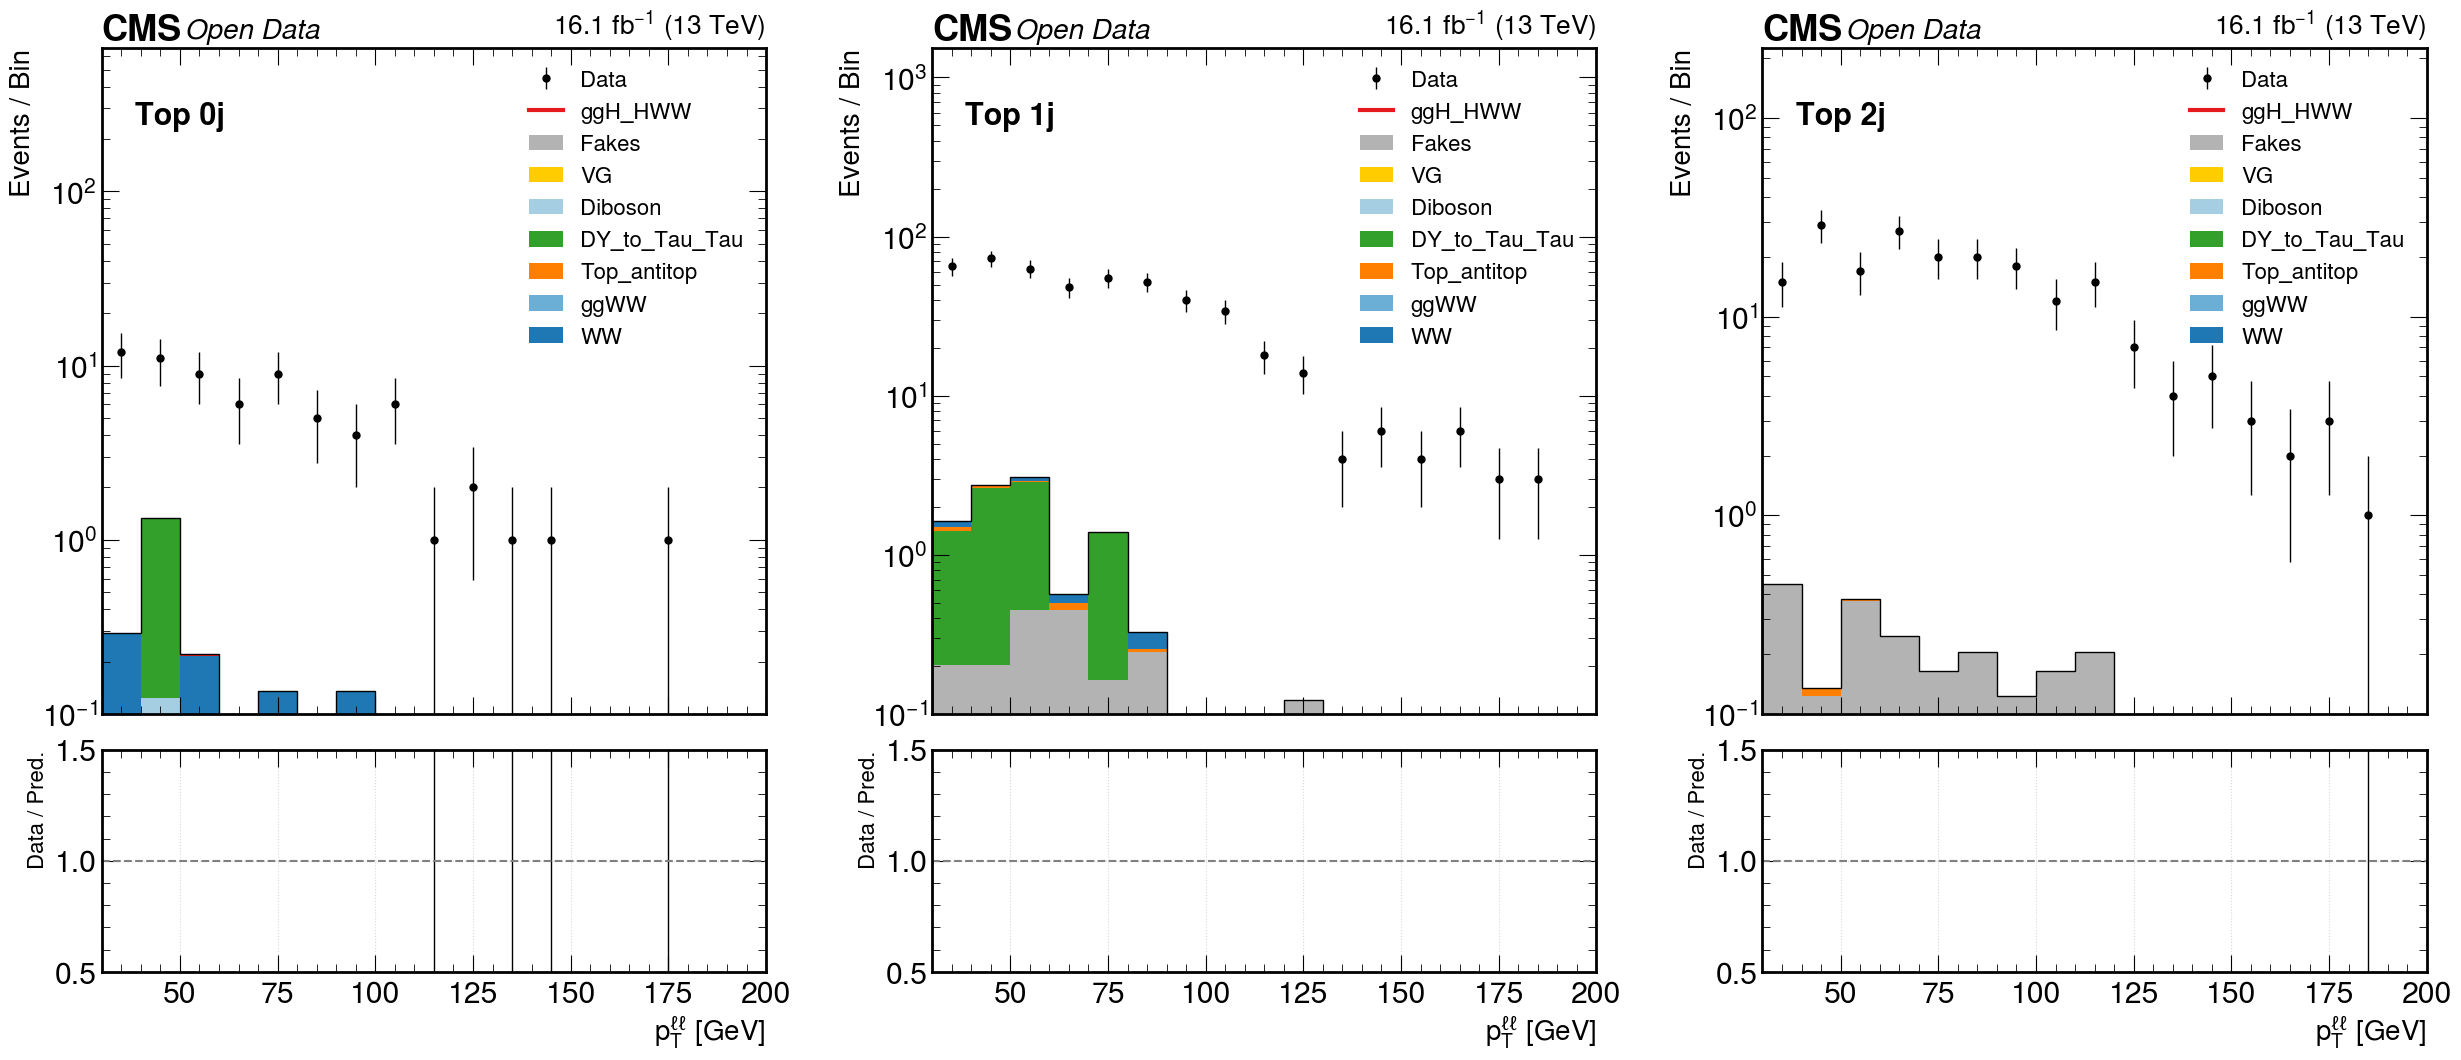

Plotting ptll in Control_Region_Tau...


/tmp/ipykernel_287/3355168007.py:137: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: plots_mplhep/CMS_Control_Region_Tau_ptll.png


Plotting dphi in Signal_Region...
Saved: plots_mplhep/CMS_Signal_Region_dphi.png


Plotting dphi in Control_Region_Top...
Saved: plots_mplhep/CMS_Control_Region_Top_dphi.png


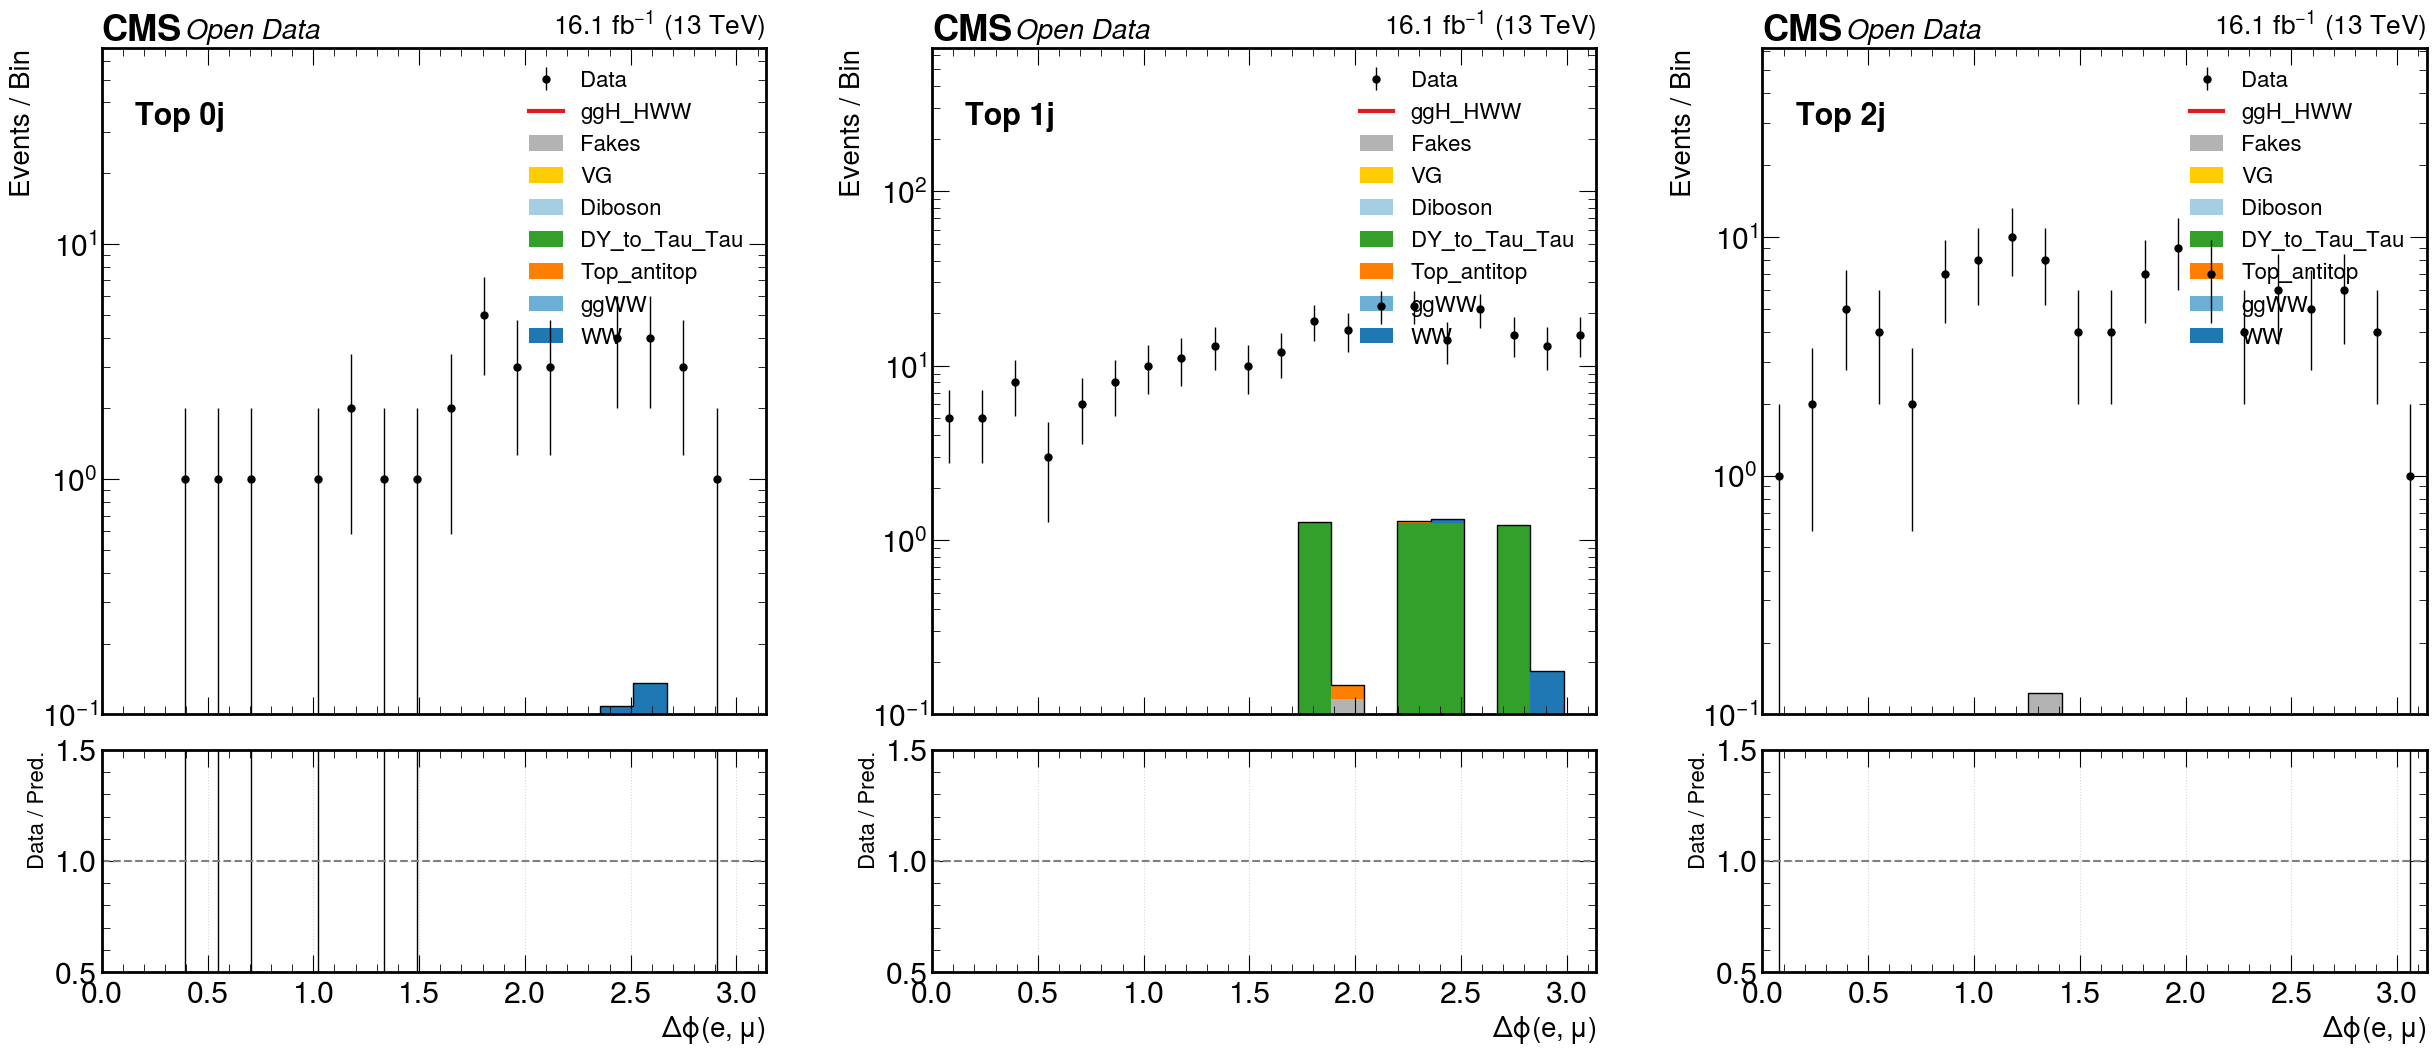

Plotting dphi in Control_Region_Tau...


/tmp/ipykernel_287/3355168007.py:135: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_main.set_yscale('log')
/tmp/ipykernel_287/3355168007.py:137: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)
/tmp/ipykernel_287/3355168007.py:137: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: plots_mplhep/CMS_Control_Region_Tau_dphi.png


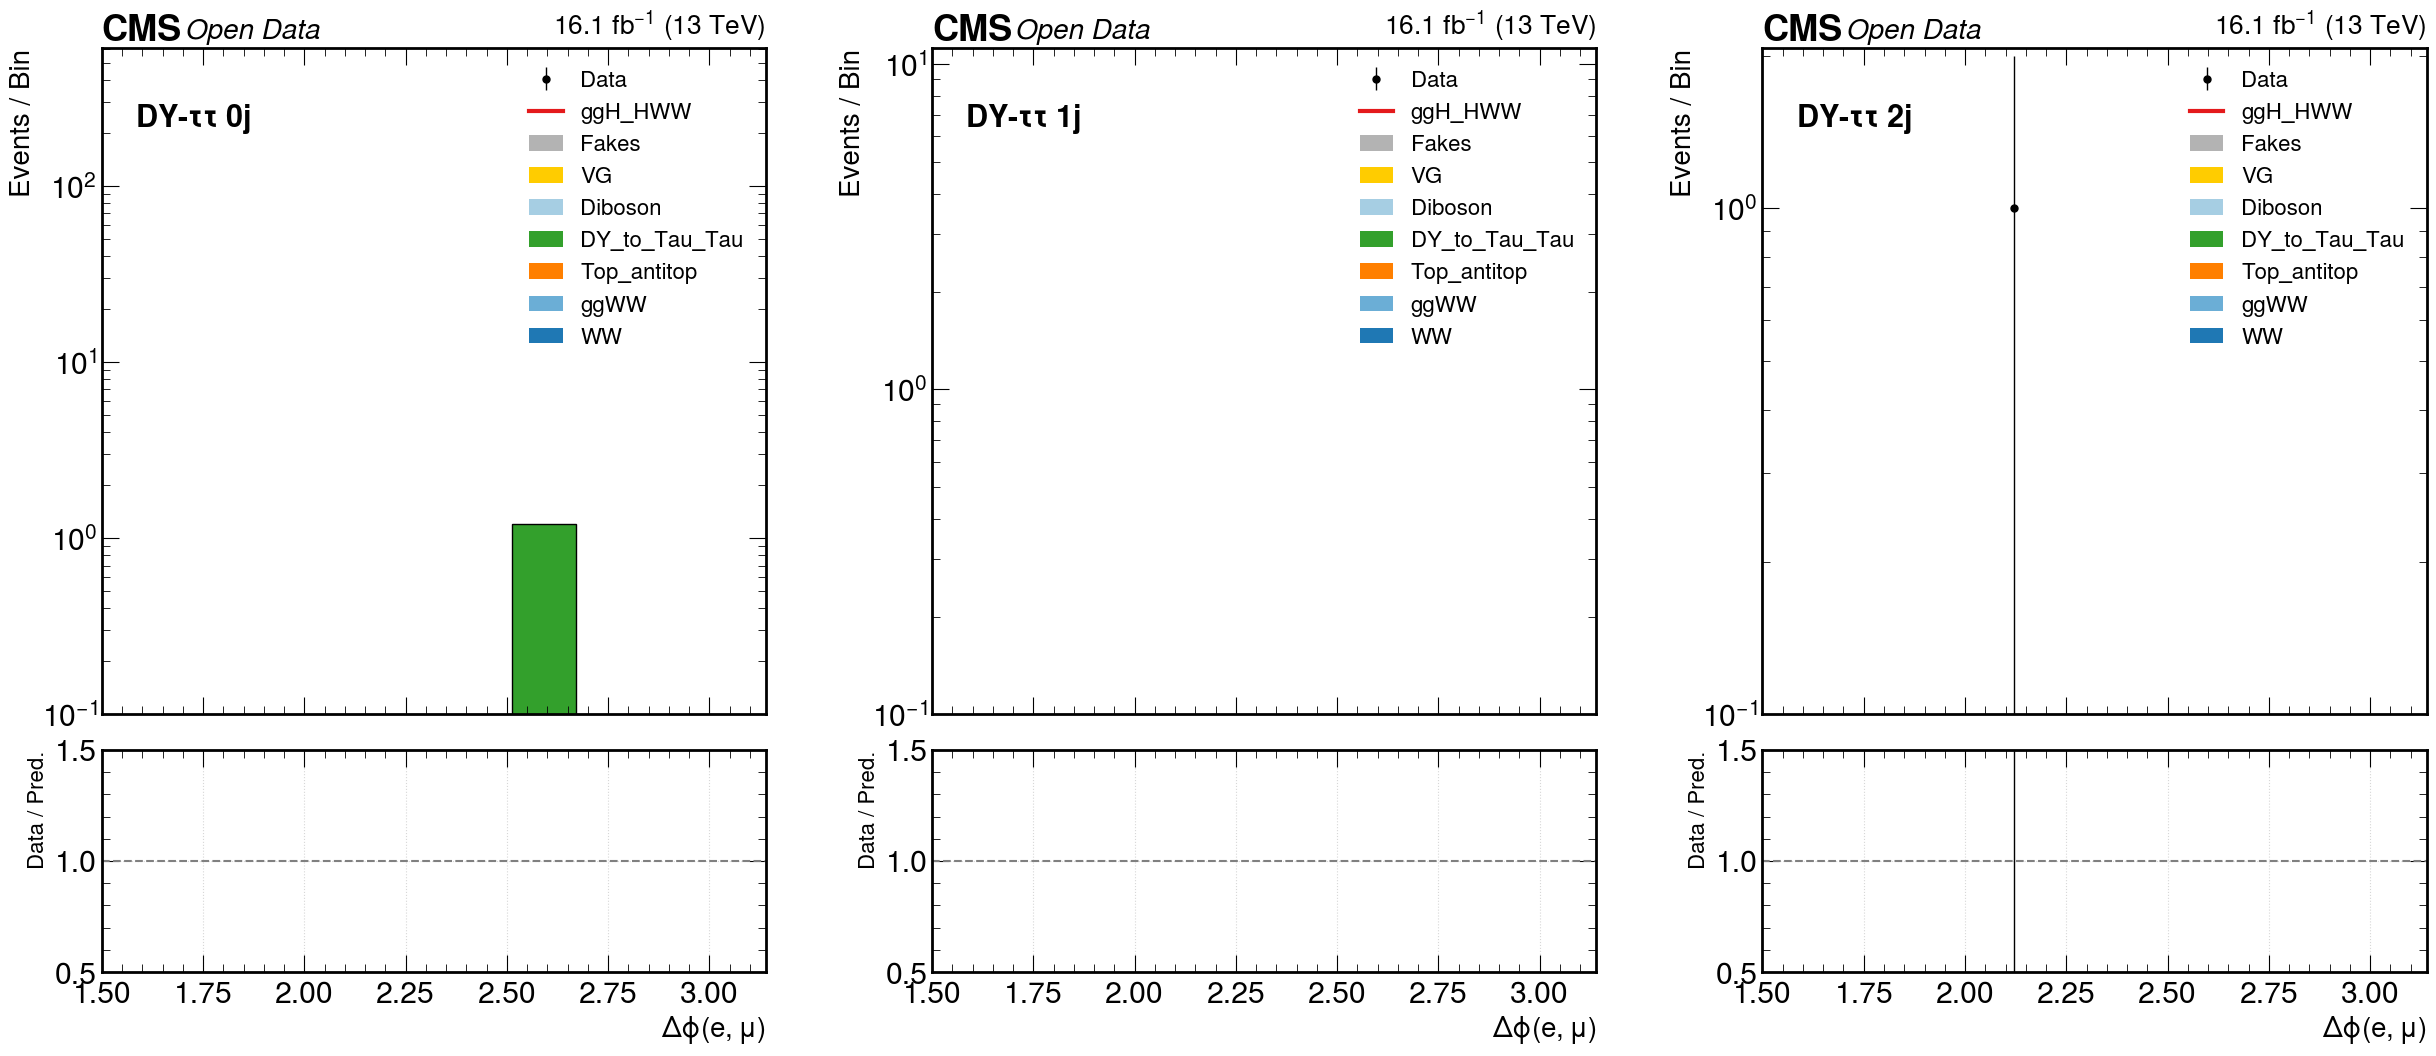

Plotting mt_higgs in Signal_Region...
Saved: plots_mplhep/CMS_Signal_Region_mt_higgs.png


Plotting mt_higgs in Control_Region_Top...
Saved: plots_mplhep/CMS_Control_Region_Top_mt_higgs.png


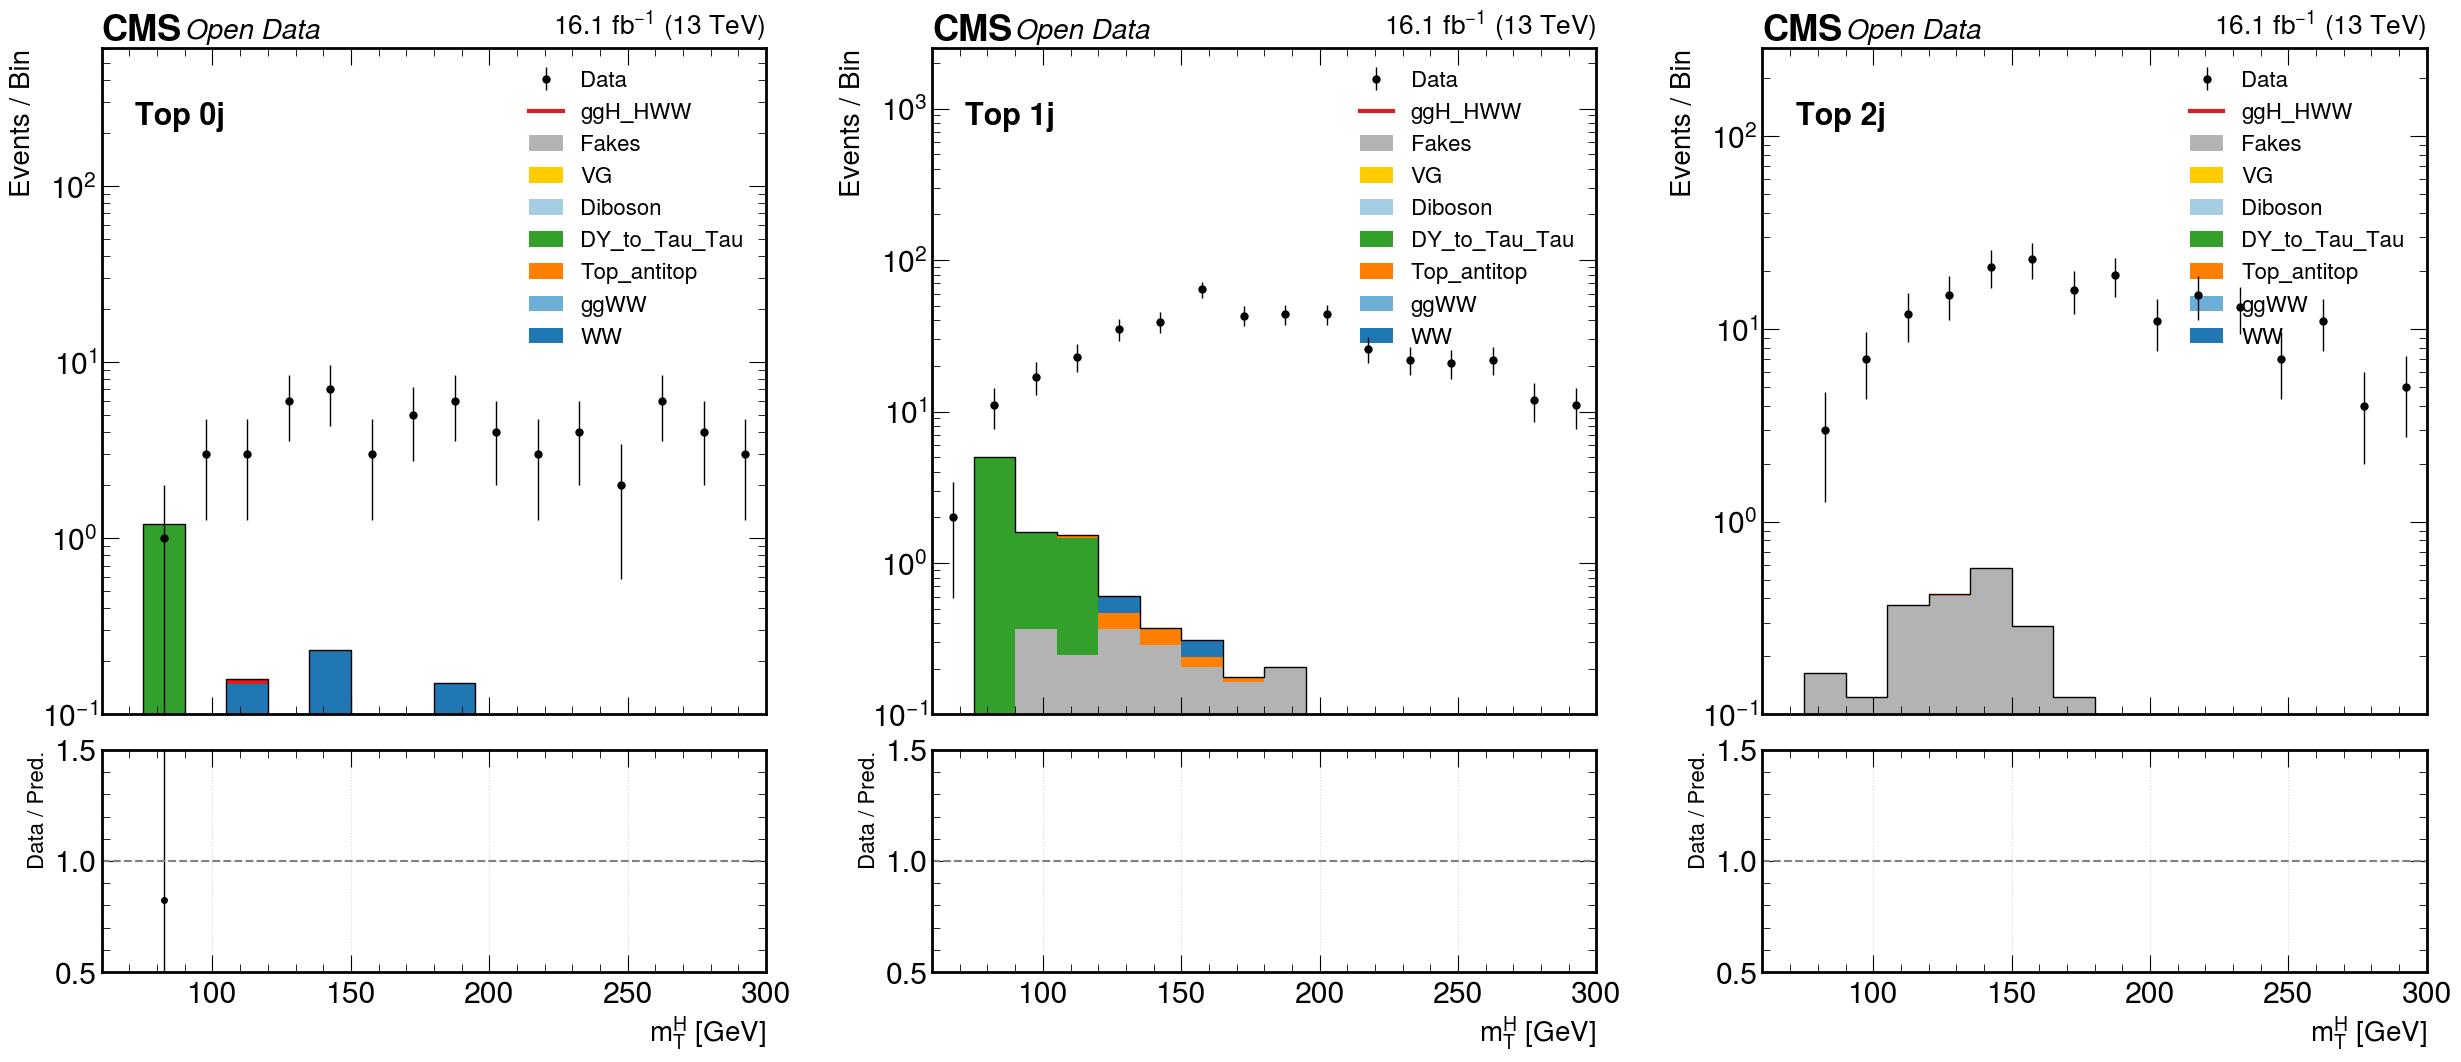

Plotting mt_higgs in Control_Region_Tau...


/tmp/ipykernel_287/3355168007.py:137: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: plots_mplhep/CMS_Control_Region_Tau_mt_higgs.png


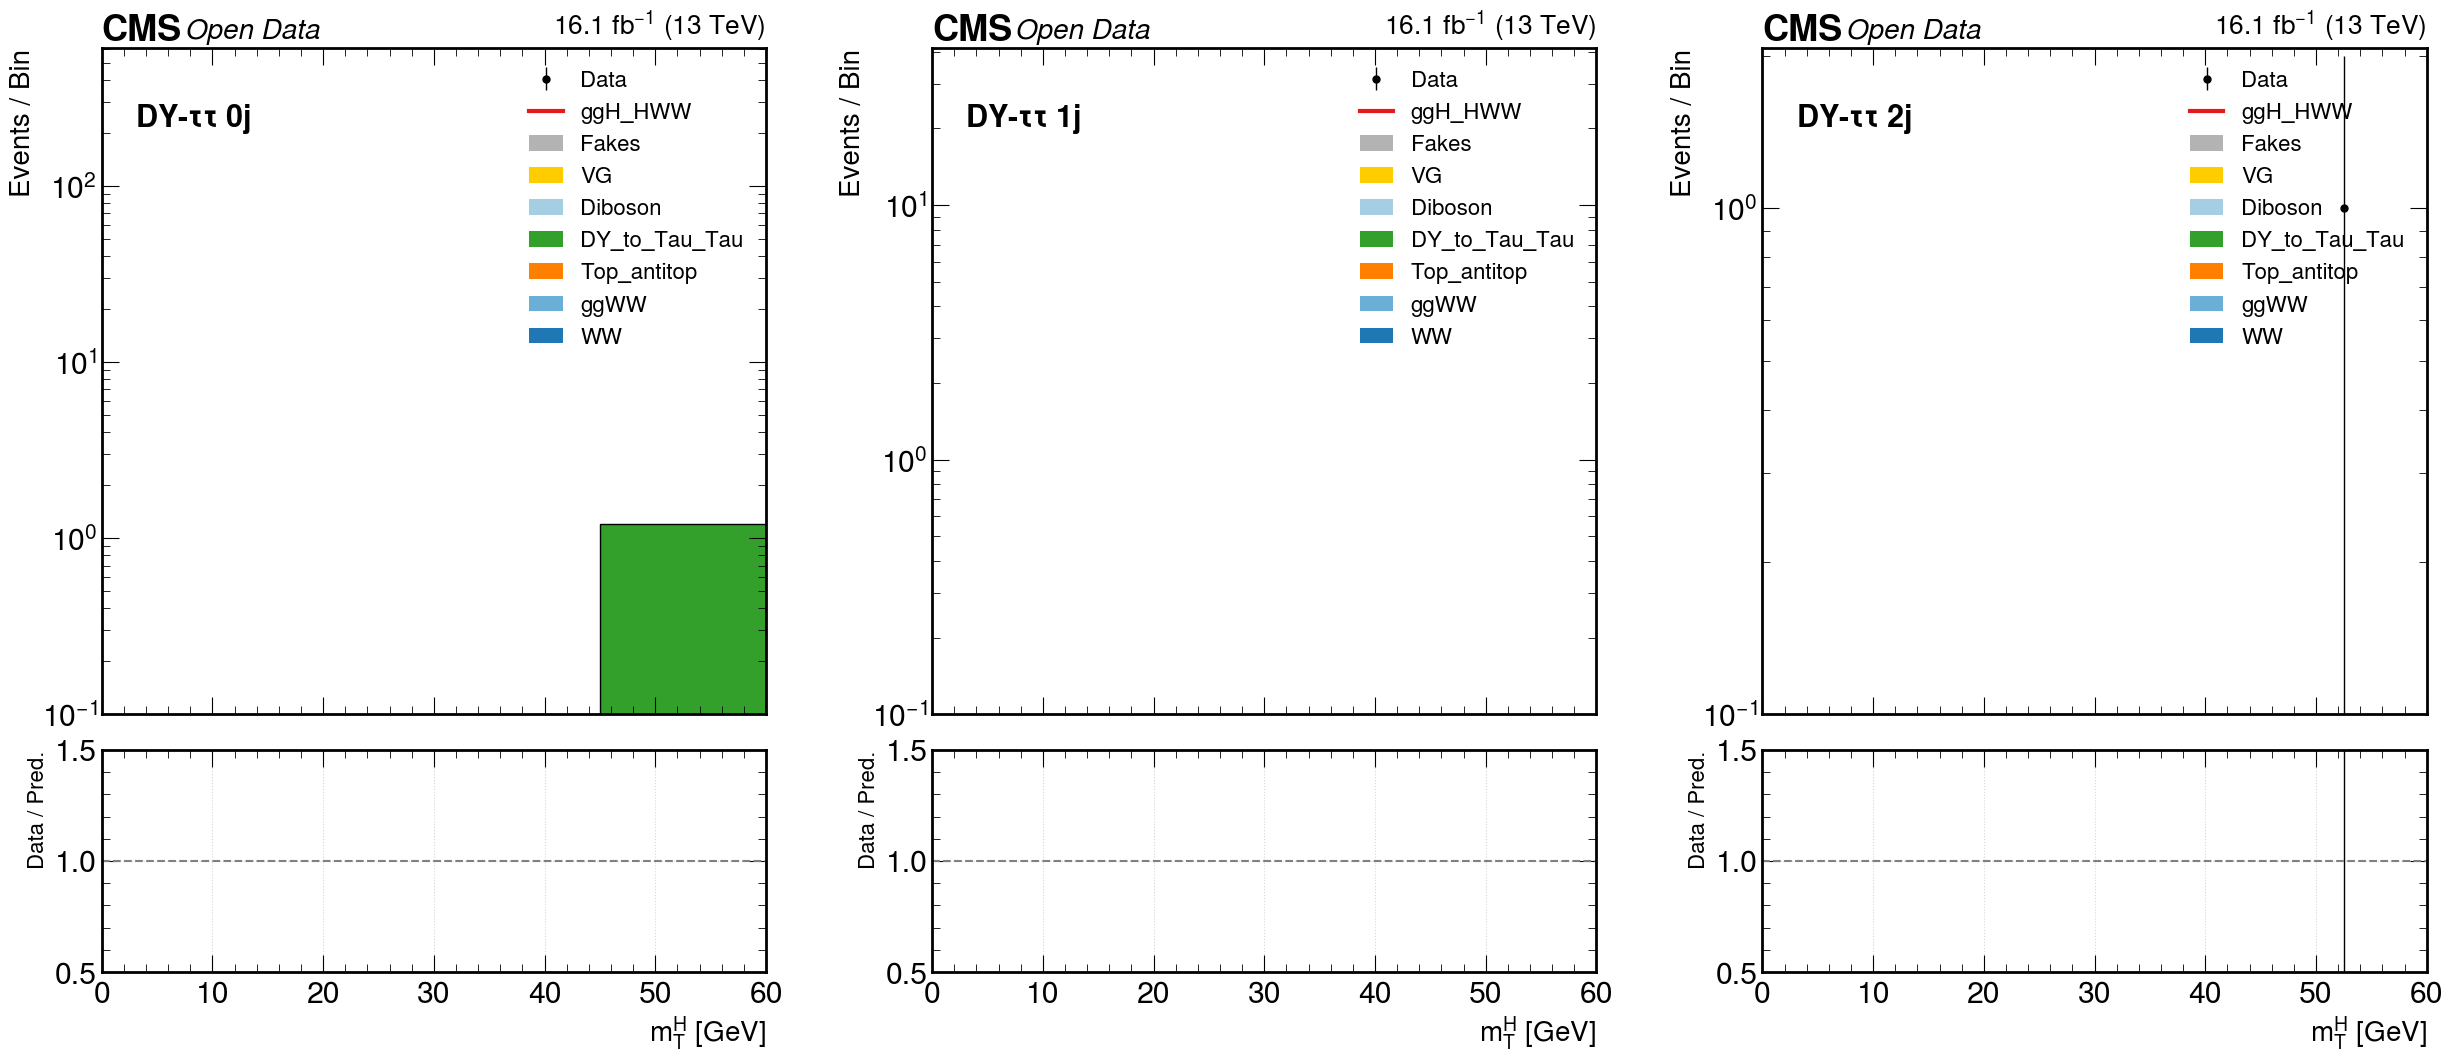

Plotting mt_l2_met in Signal_Region...
Saved: plots_mplhep/CMS_Signal_Region_mt_l2_met.png


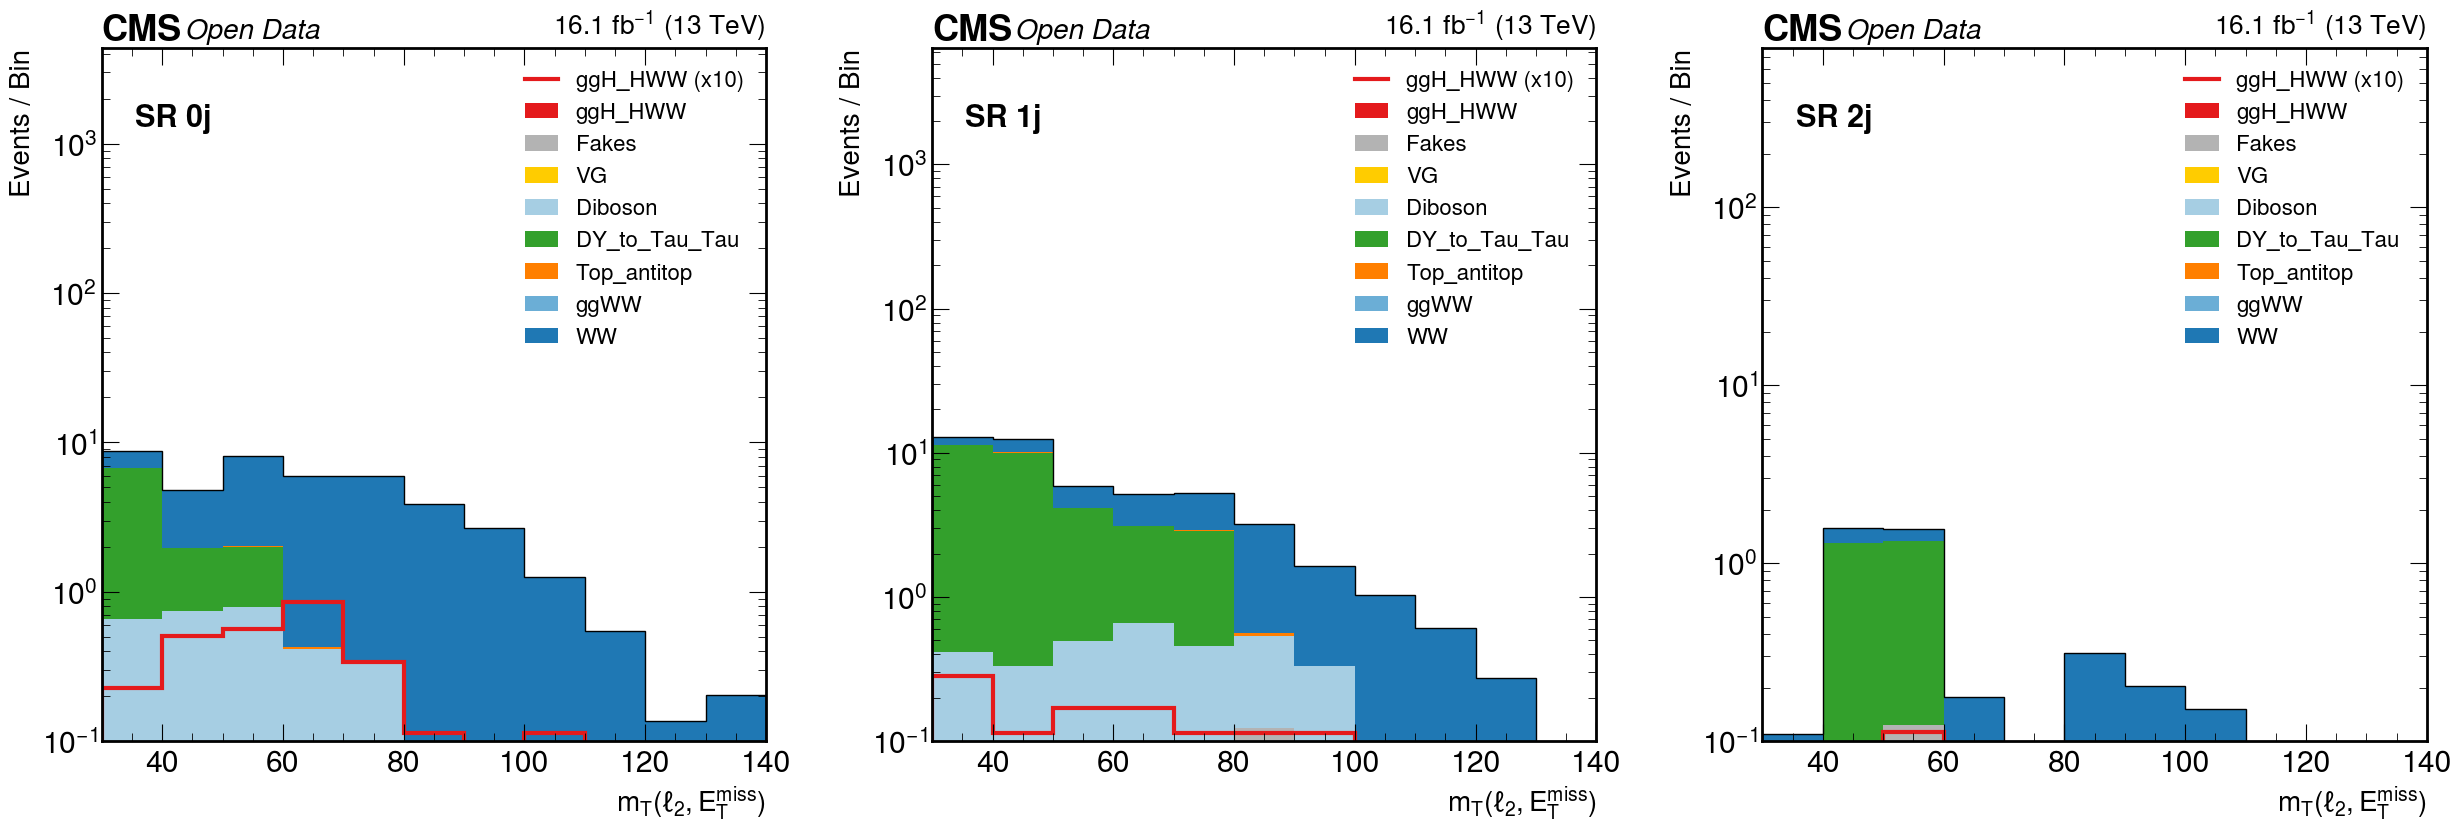

Plotting mt_l2_met in Control_Region_Top...
Saved: plots_mplhep/CMS_Control_Region_Top_mt_l2_met.png


Plotting mt_l2_met in Control_Region_Tau...


/tmp/ipykernel_287/3355168007.py:137: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: plots_mplhep/CMS_Control_Region_Tau_mt_l2_met.png


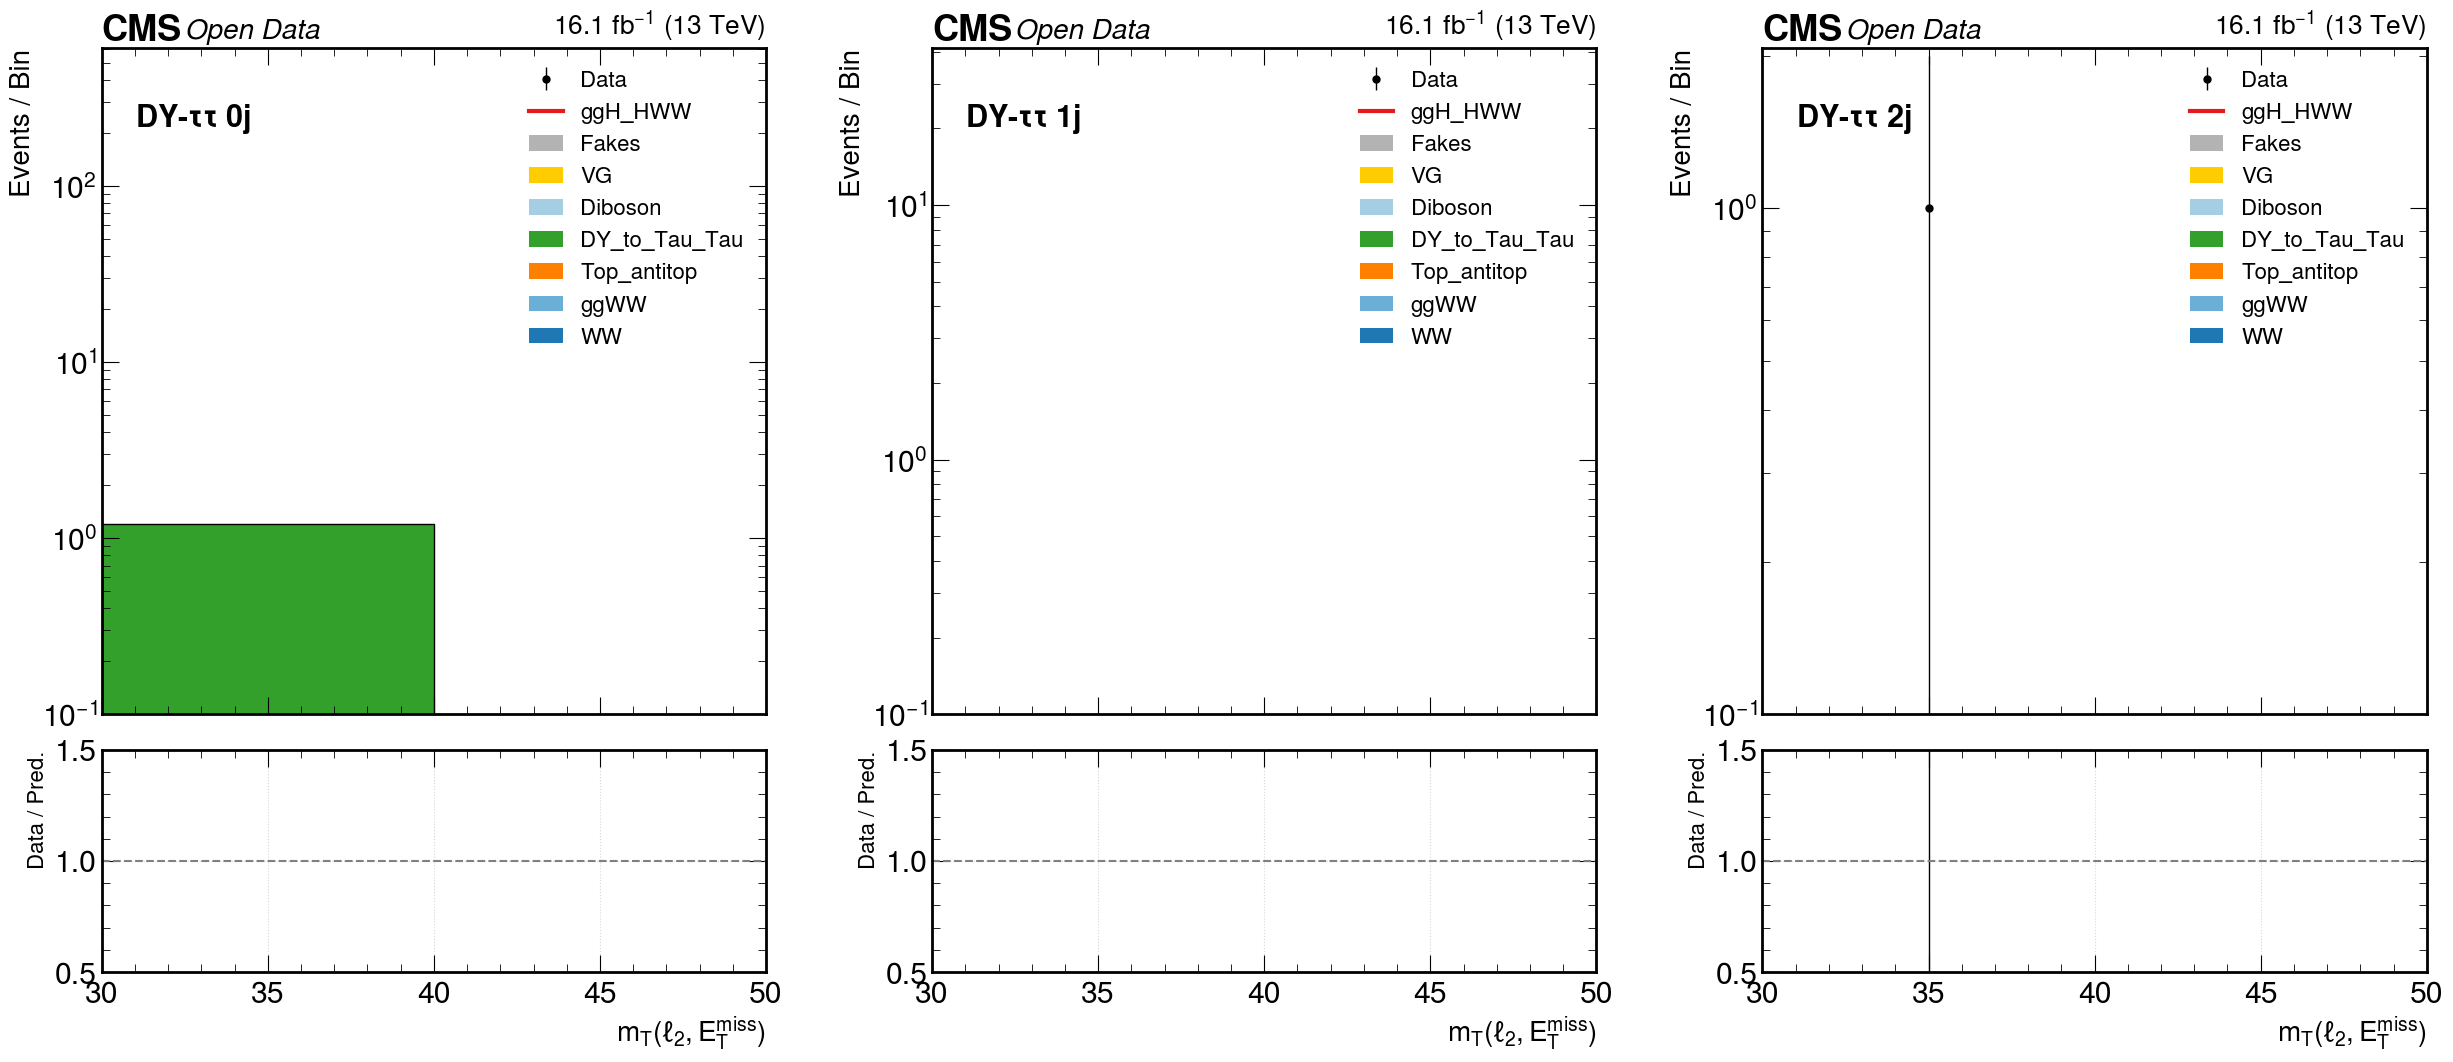

Plotting mjj in Signal_Region...
Saved: plots_mplhep/CMS_Signal_Region_mjj.png


Plotting mjj in Control_Region_Top...
Saved: plots_mplhep/CMS_Control_Region_Top_mjj.png


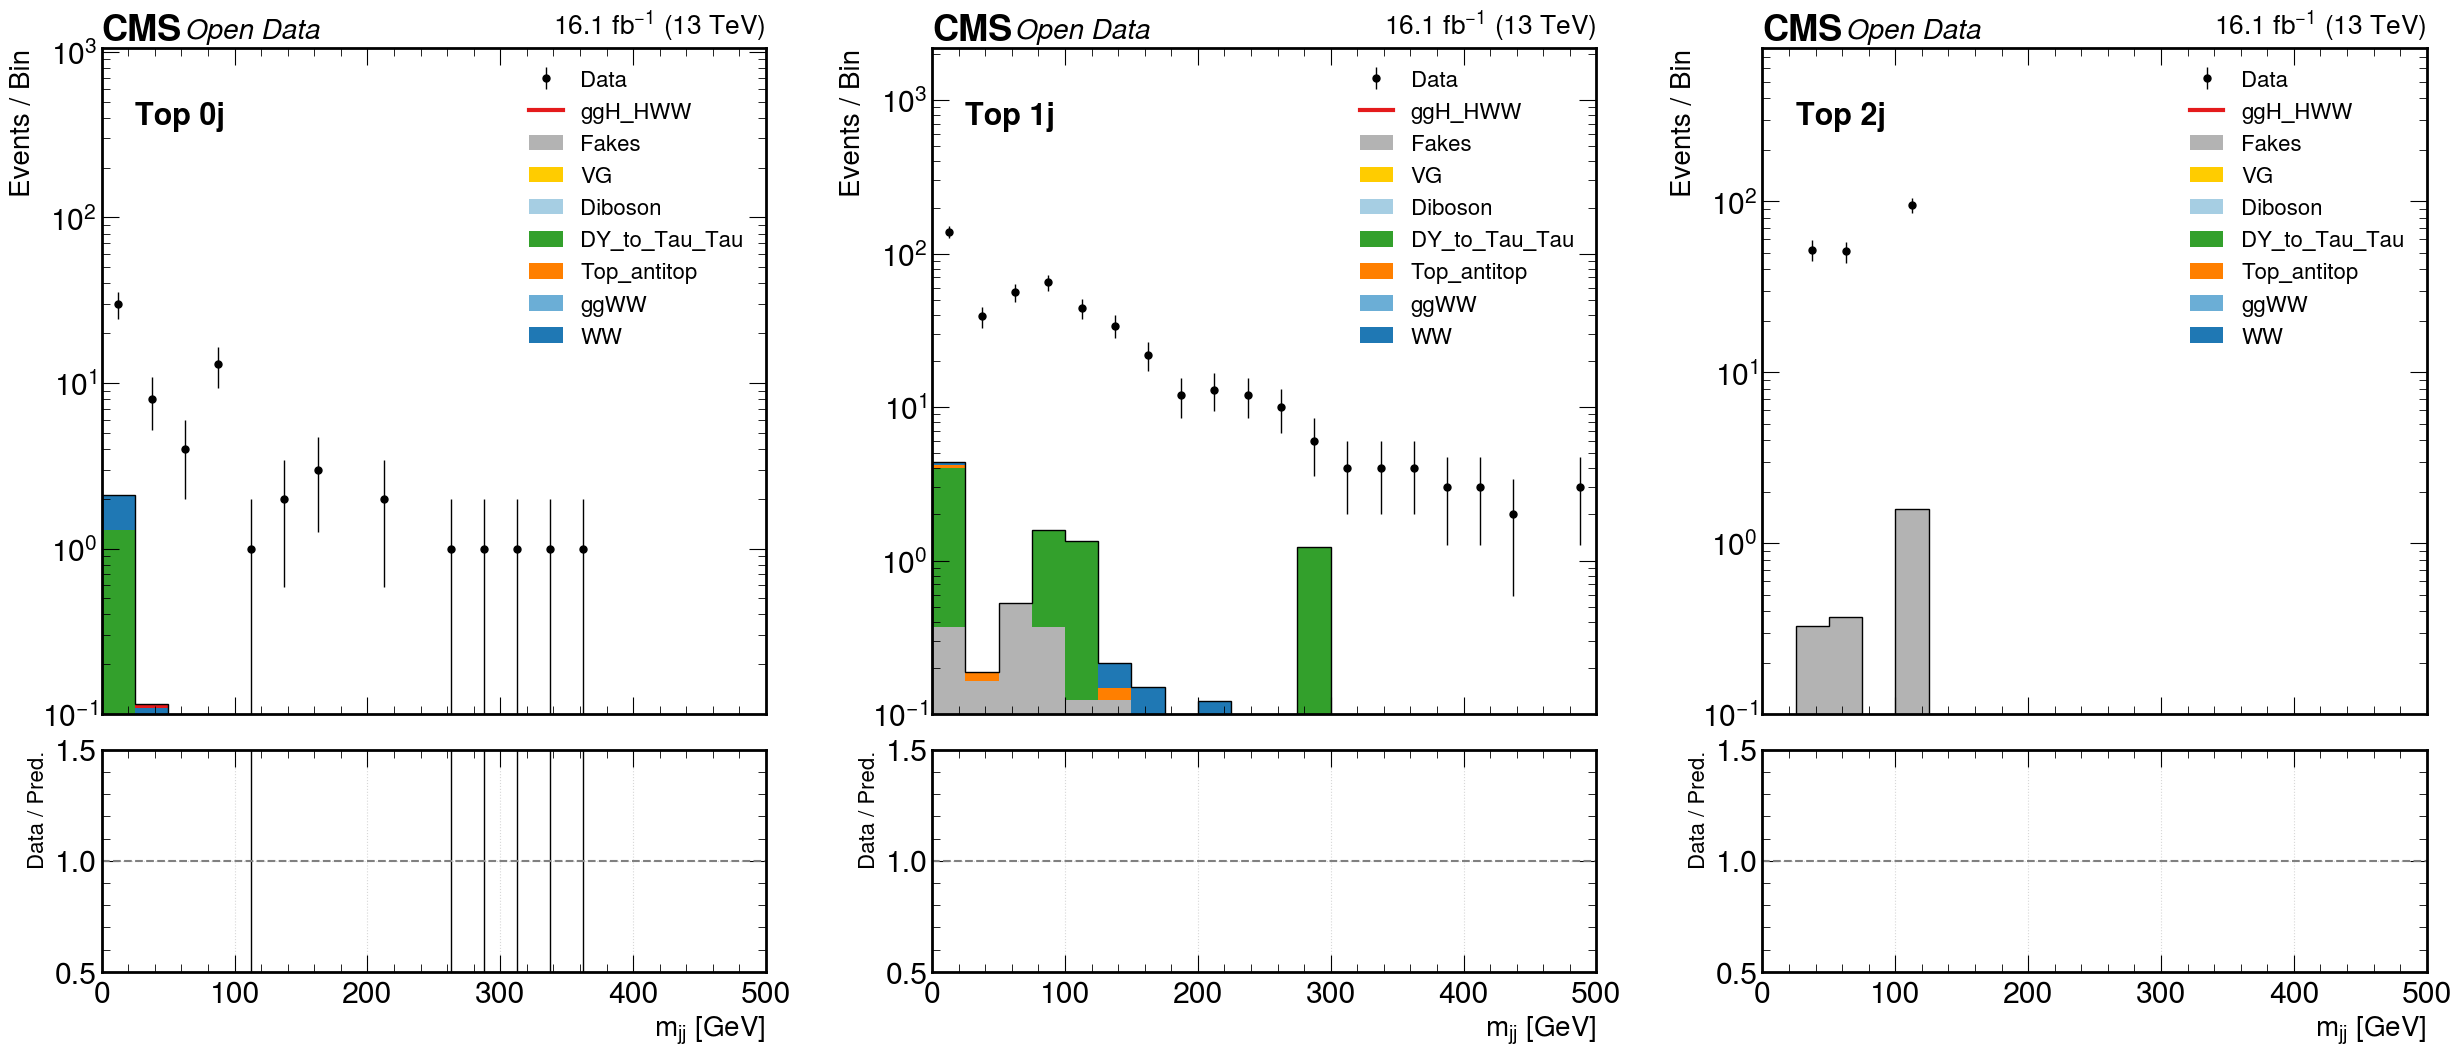

Plotting mjj in Control_Region_Tau...


/tmp/ipykernel_287/3355168007.py:137: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: plots_mplhep/CMS_Control_Region_Tau_mjj.png


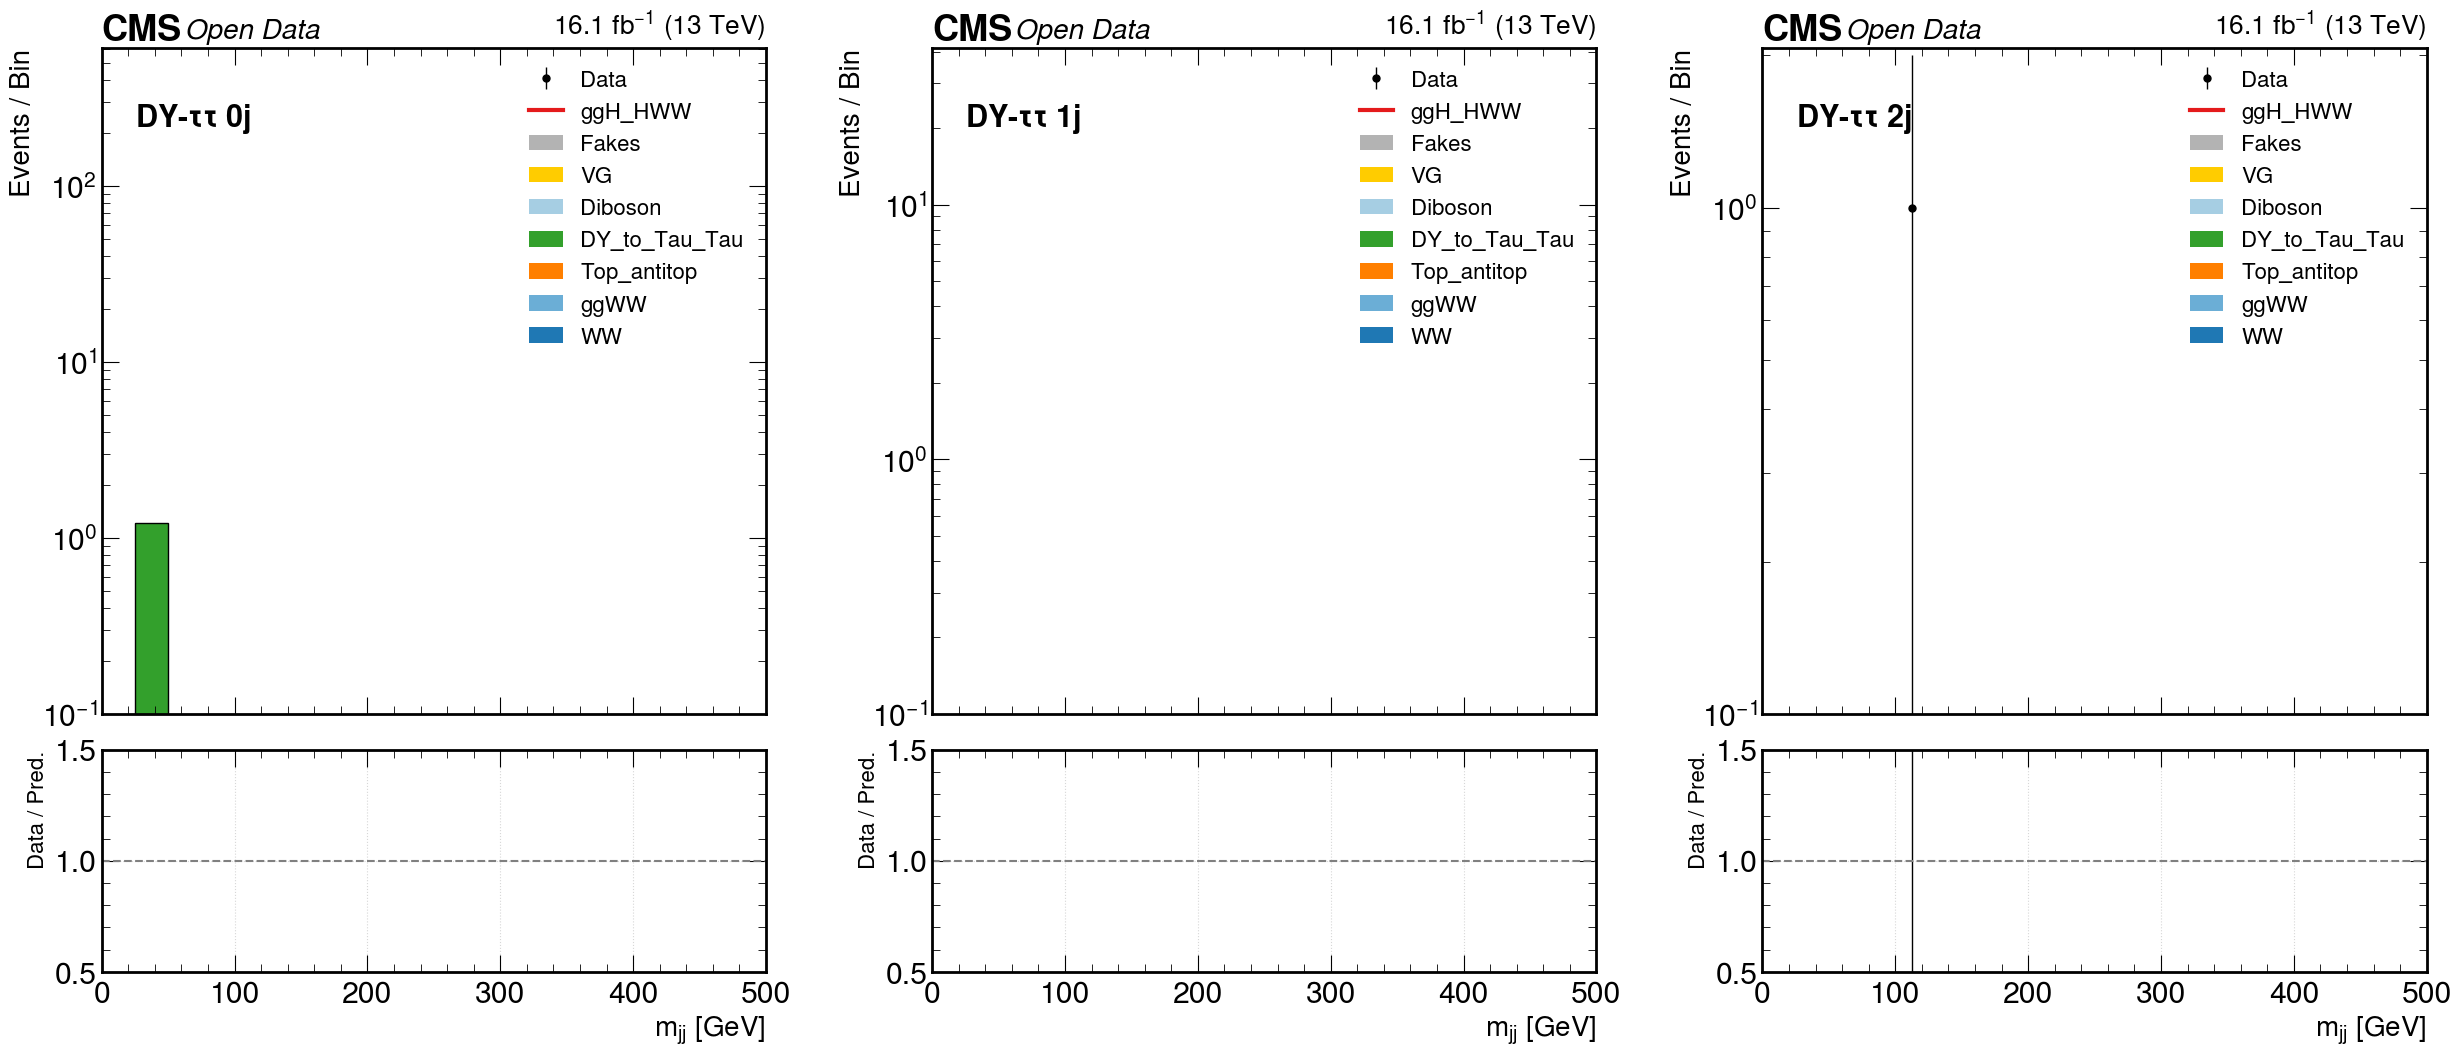

Plotting leading_pt in Signal_Region...
Saved: plots_mplhep/CMS_Signal_Region_leading_pt.png


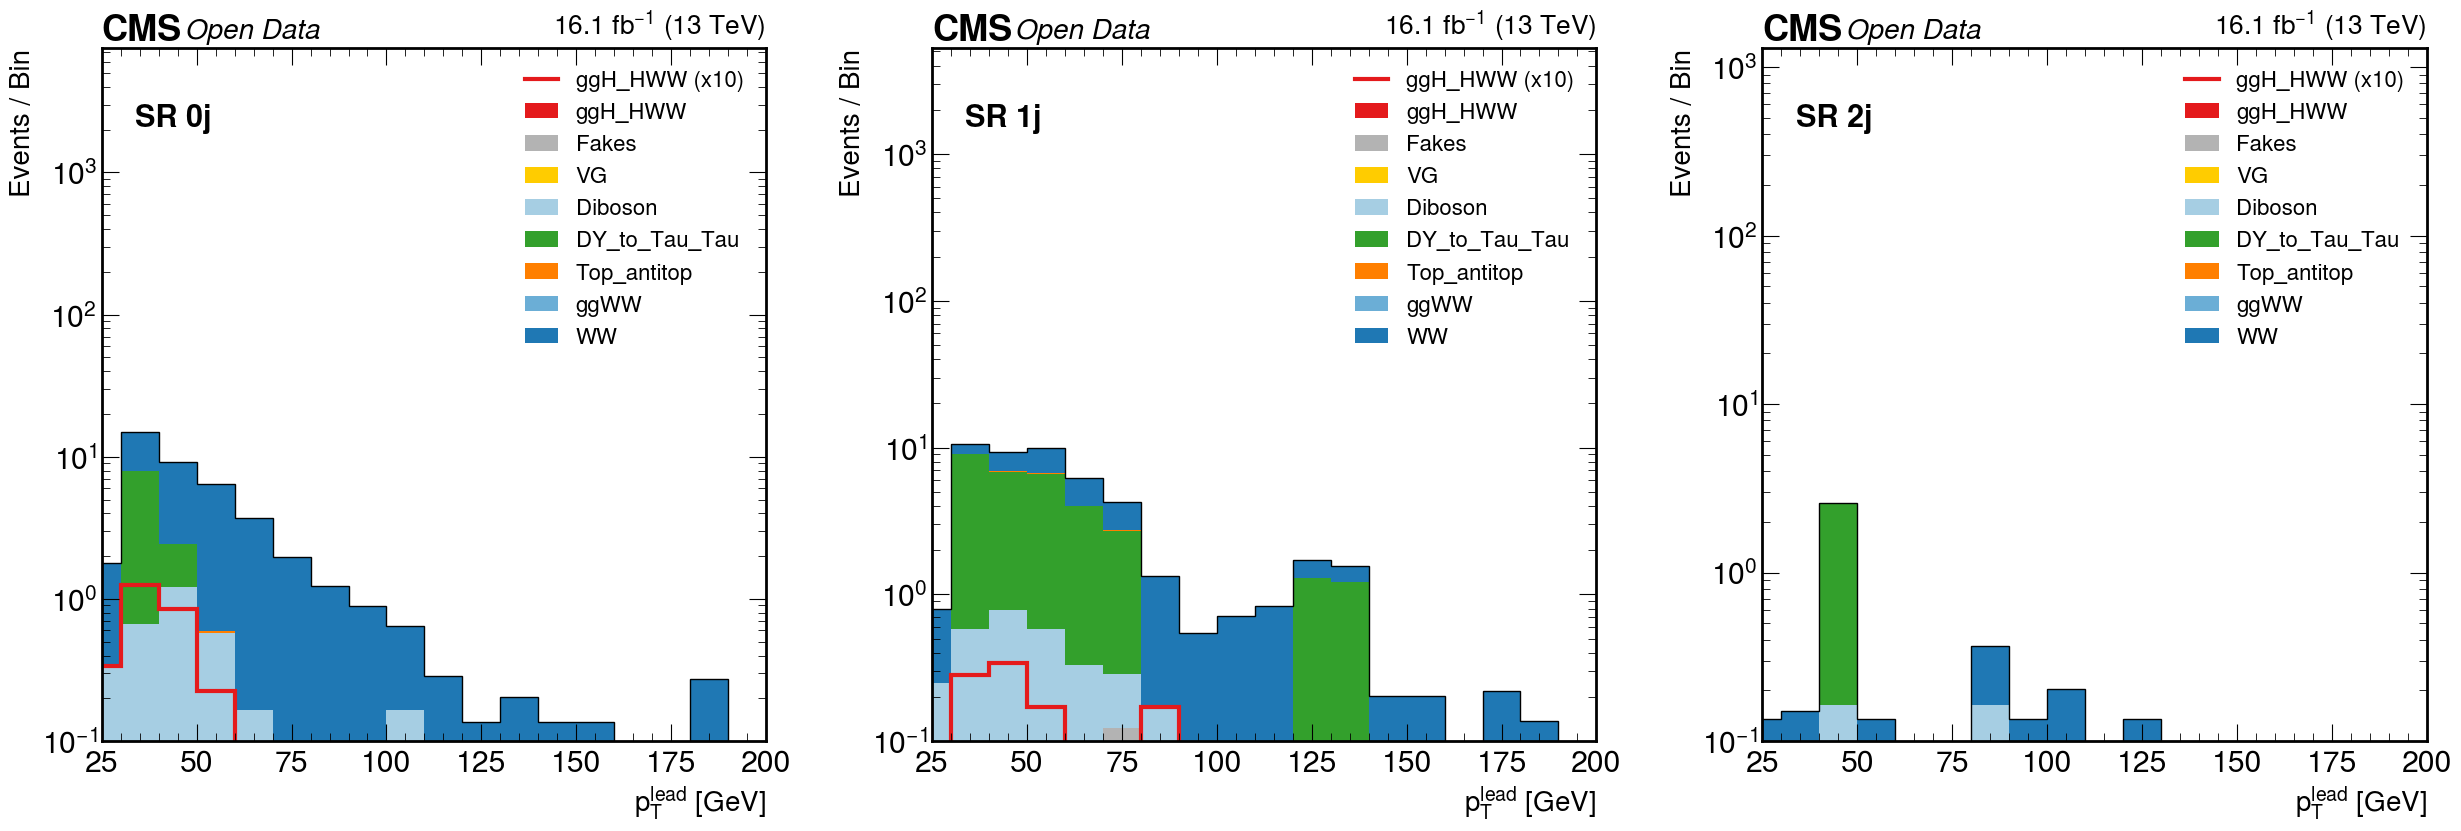

Plotting leading_pt in Control_Region_Top...
Saved: plots_mplhep/CMS_Control_Region_Top_leading_pt.png


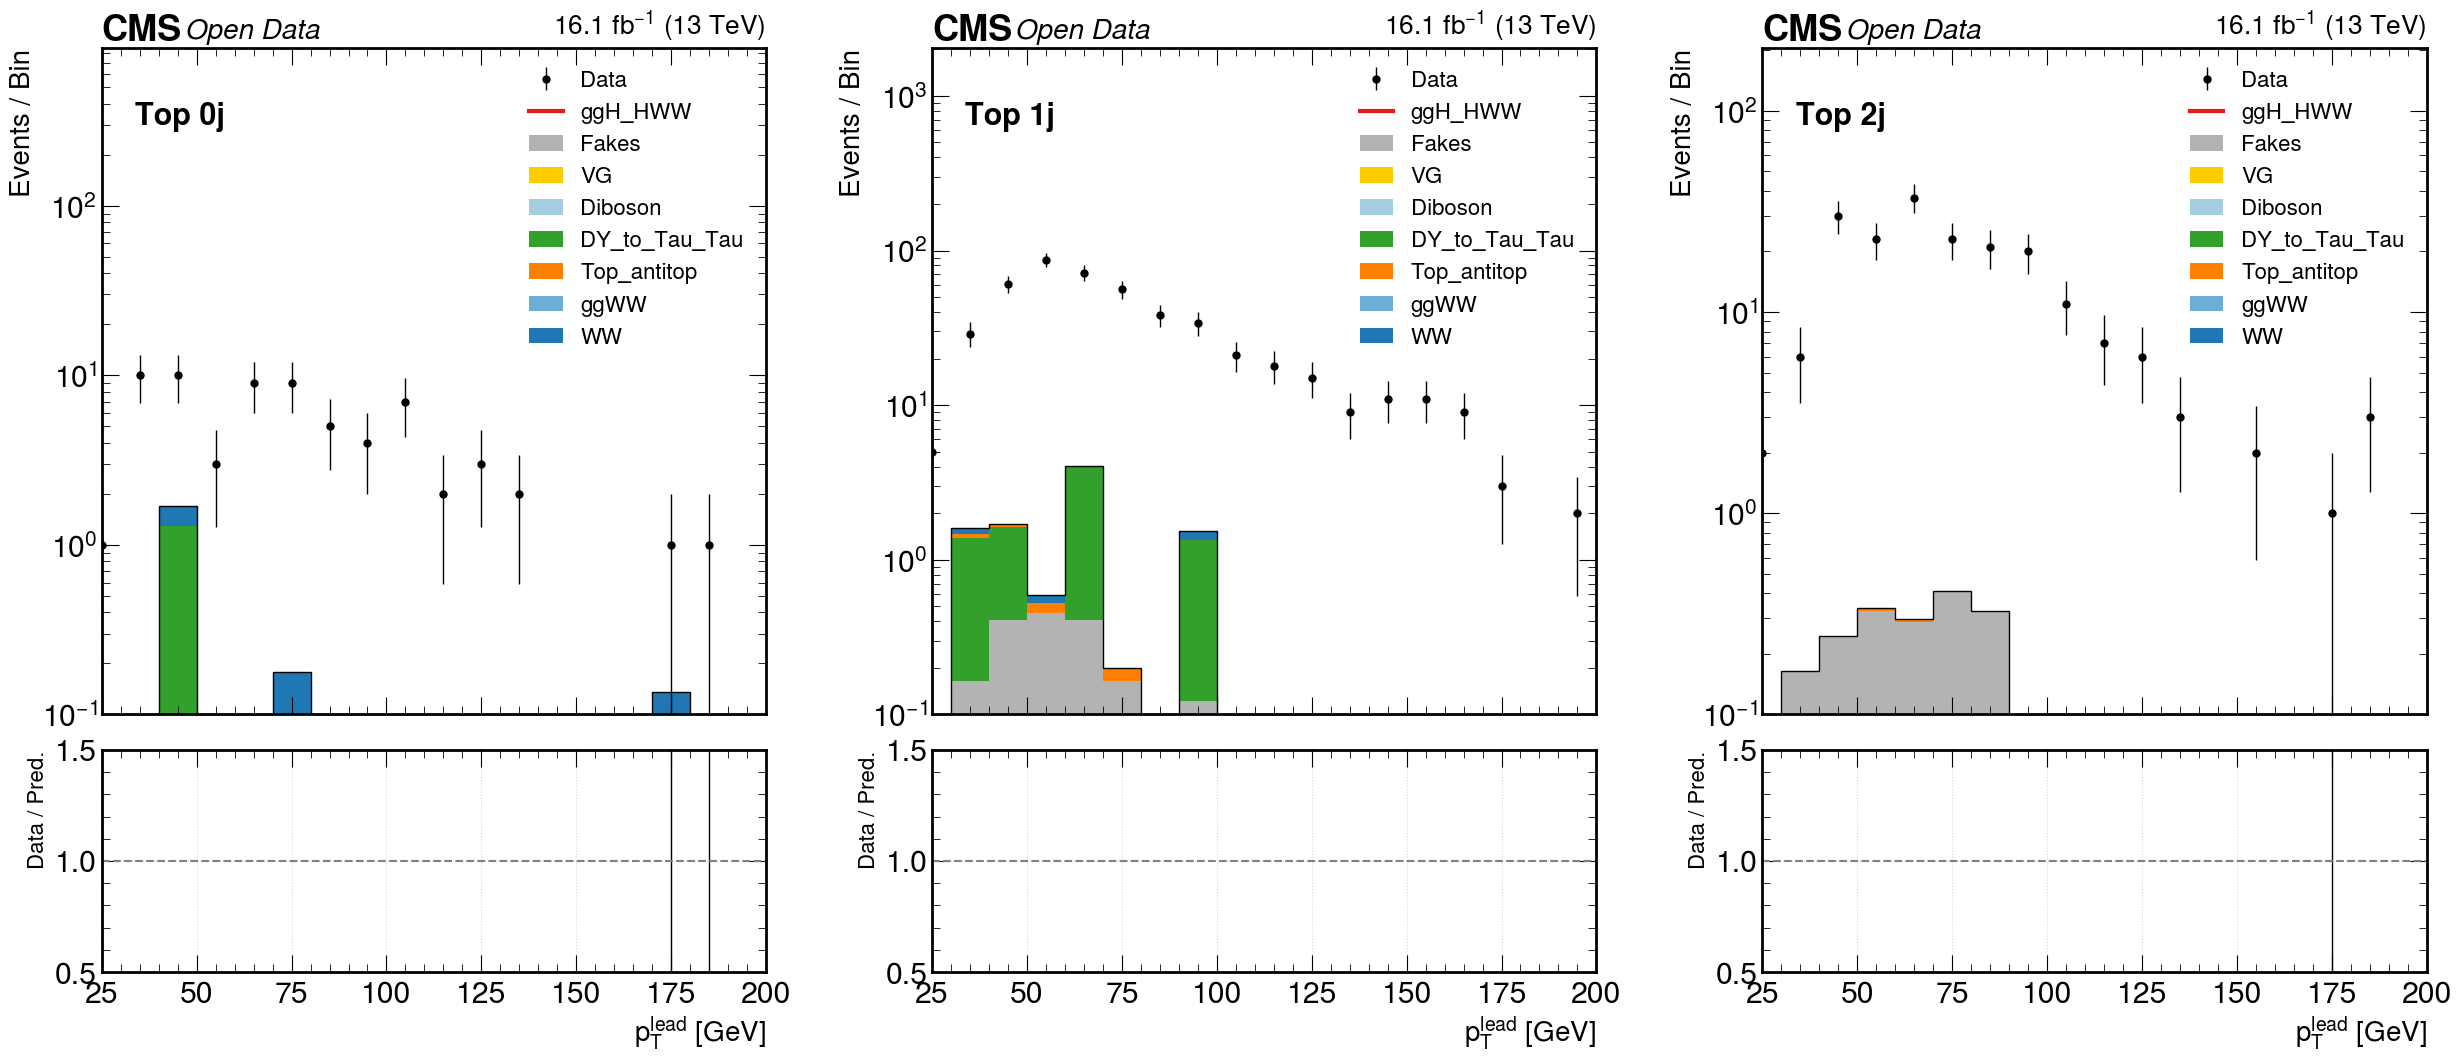

Plotting leading_pt in Control_Region_Tau...


/tmp/ipykernel_287/3355168007.py:137: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: plots_mplhep/CMS_Control_Region_Tau_leading_pt.png


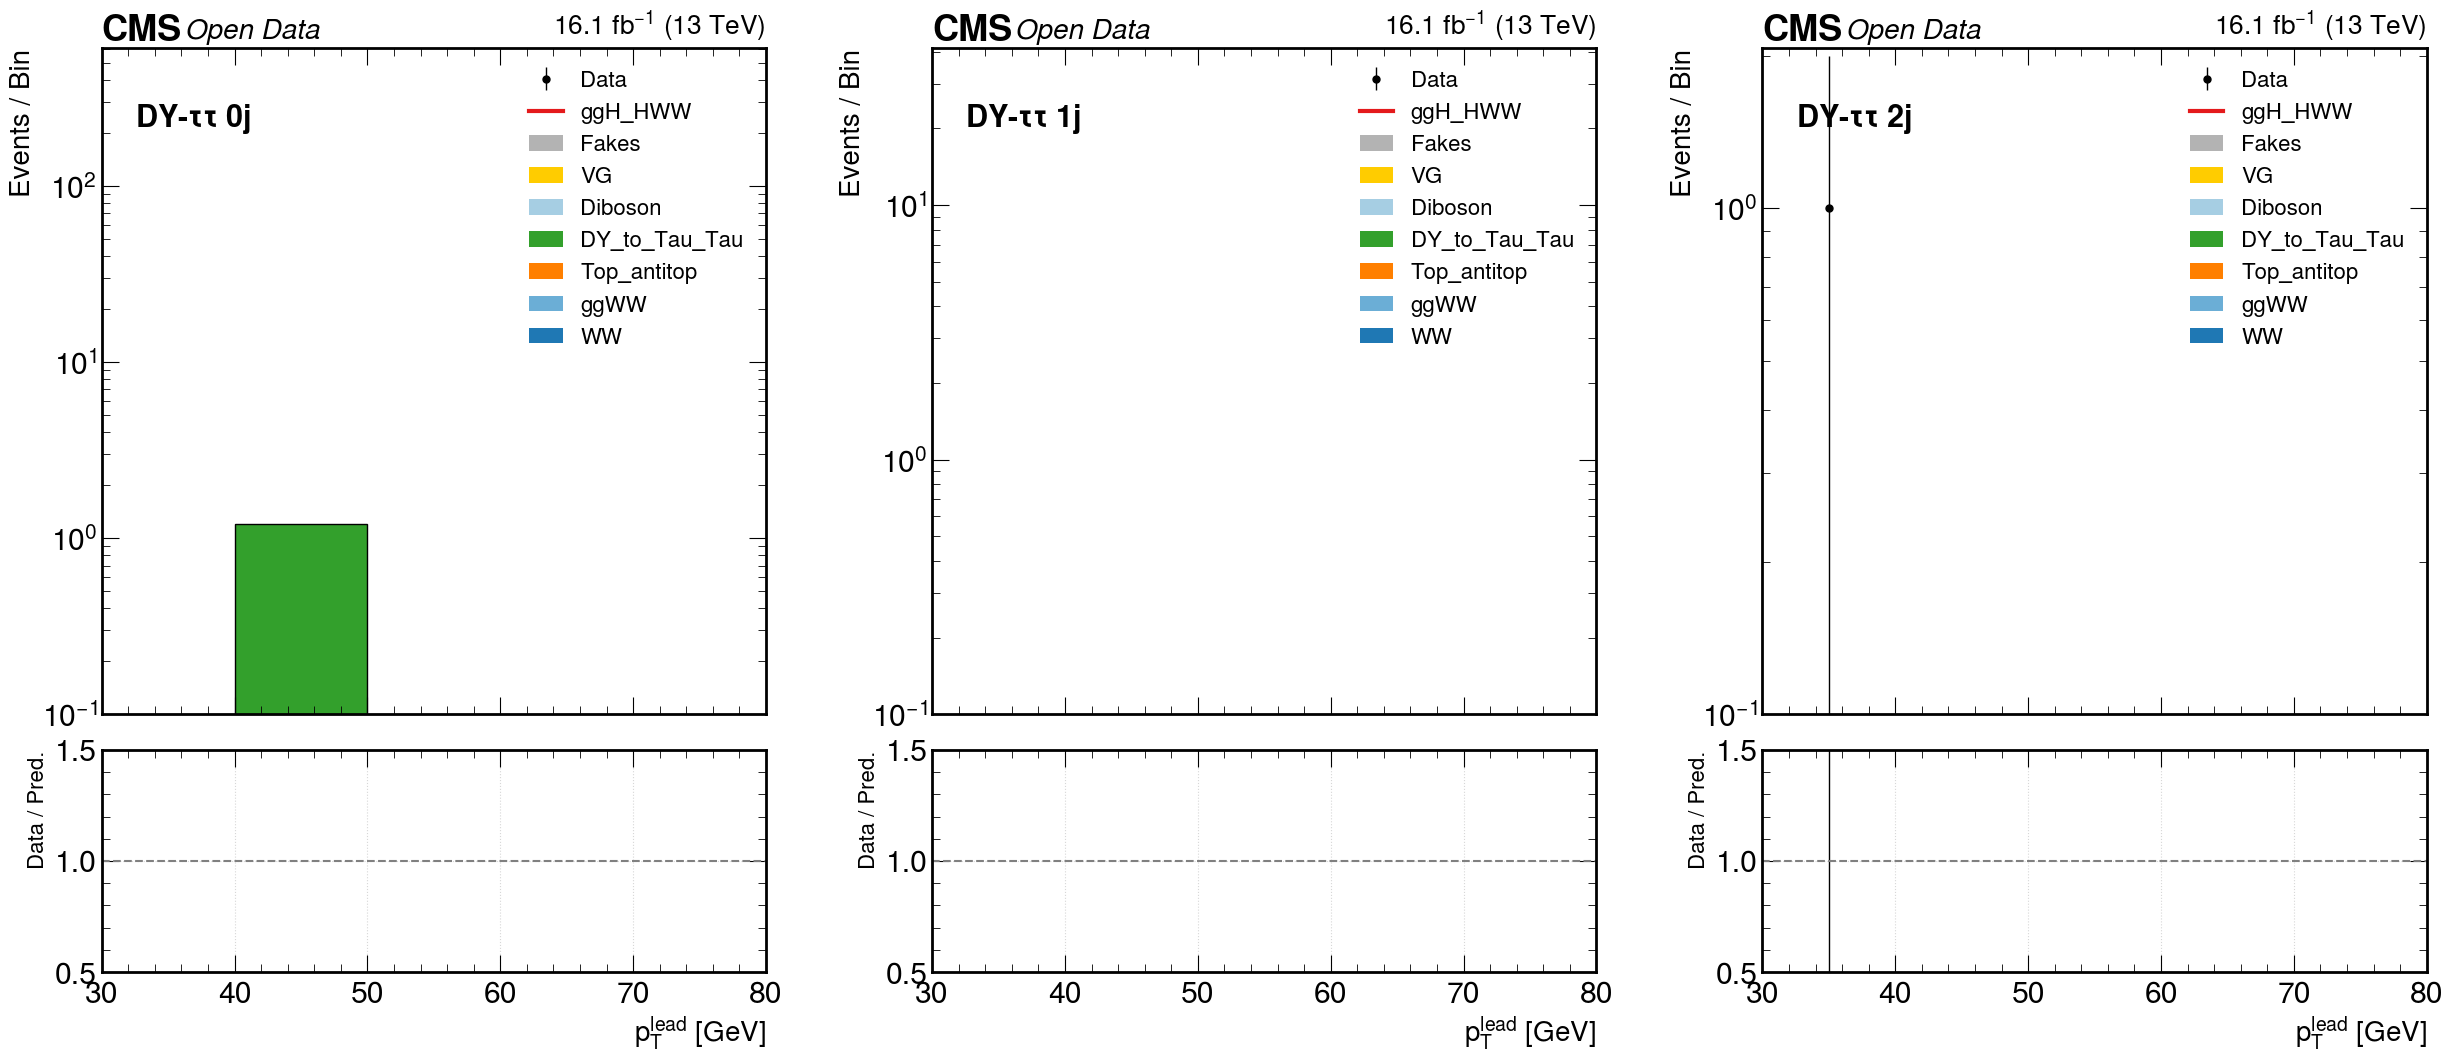

Plotting subleading_pt in Signal_Region...
Saved: plots_mplhep/CMS_Signal_Region_subleading_pt.png


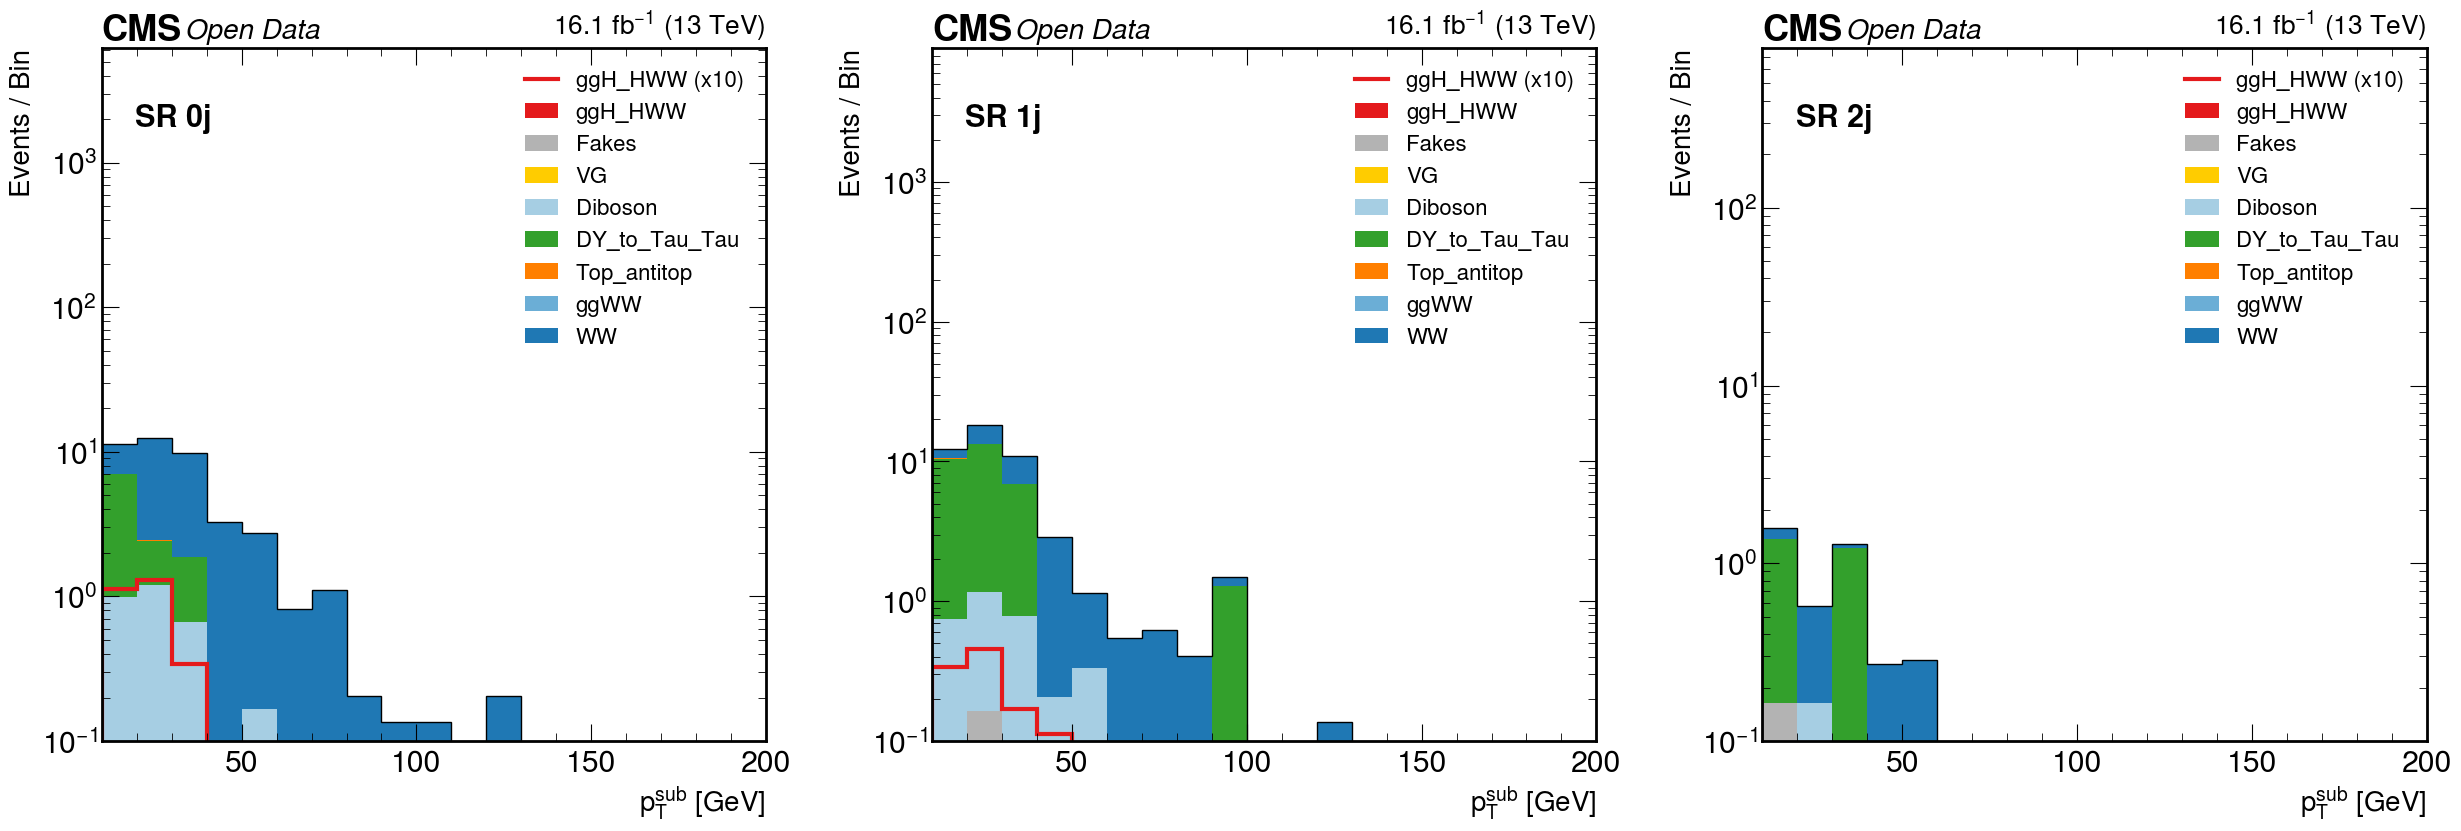

Plotting subleading_pt in Control_Region_Top...
Saved: plots_mplhep/CMS_Control_Region_Top_subleading_pt.png


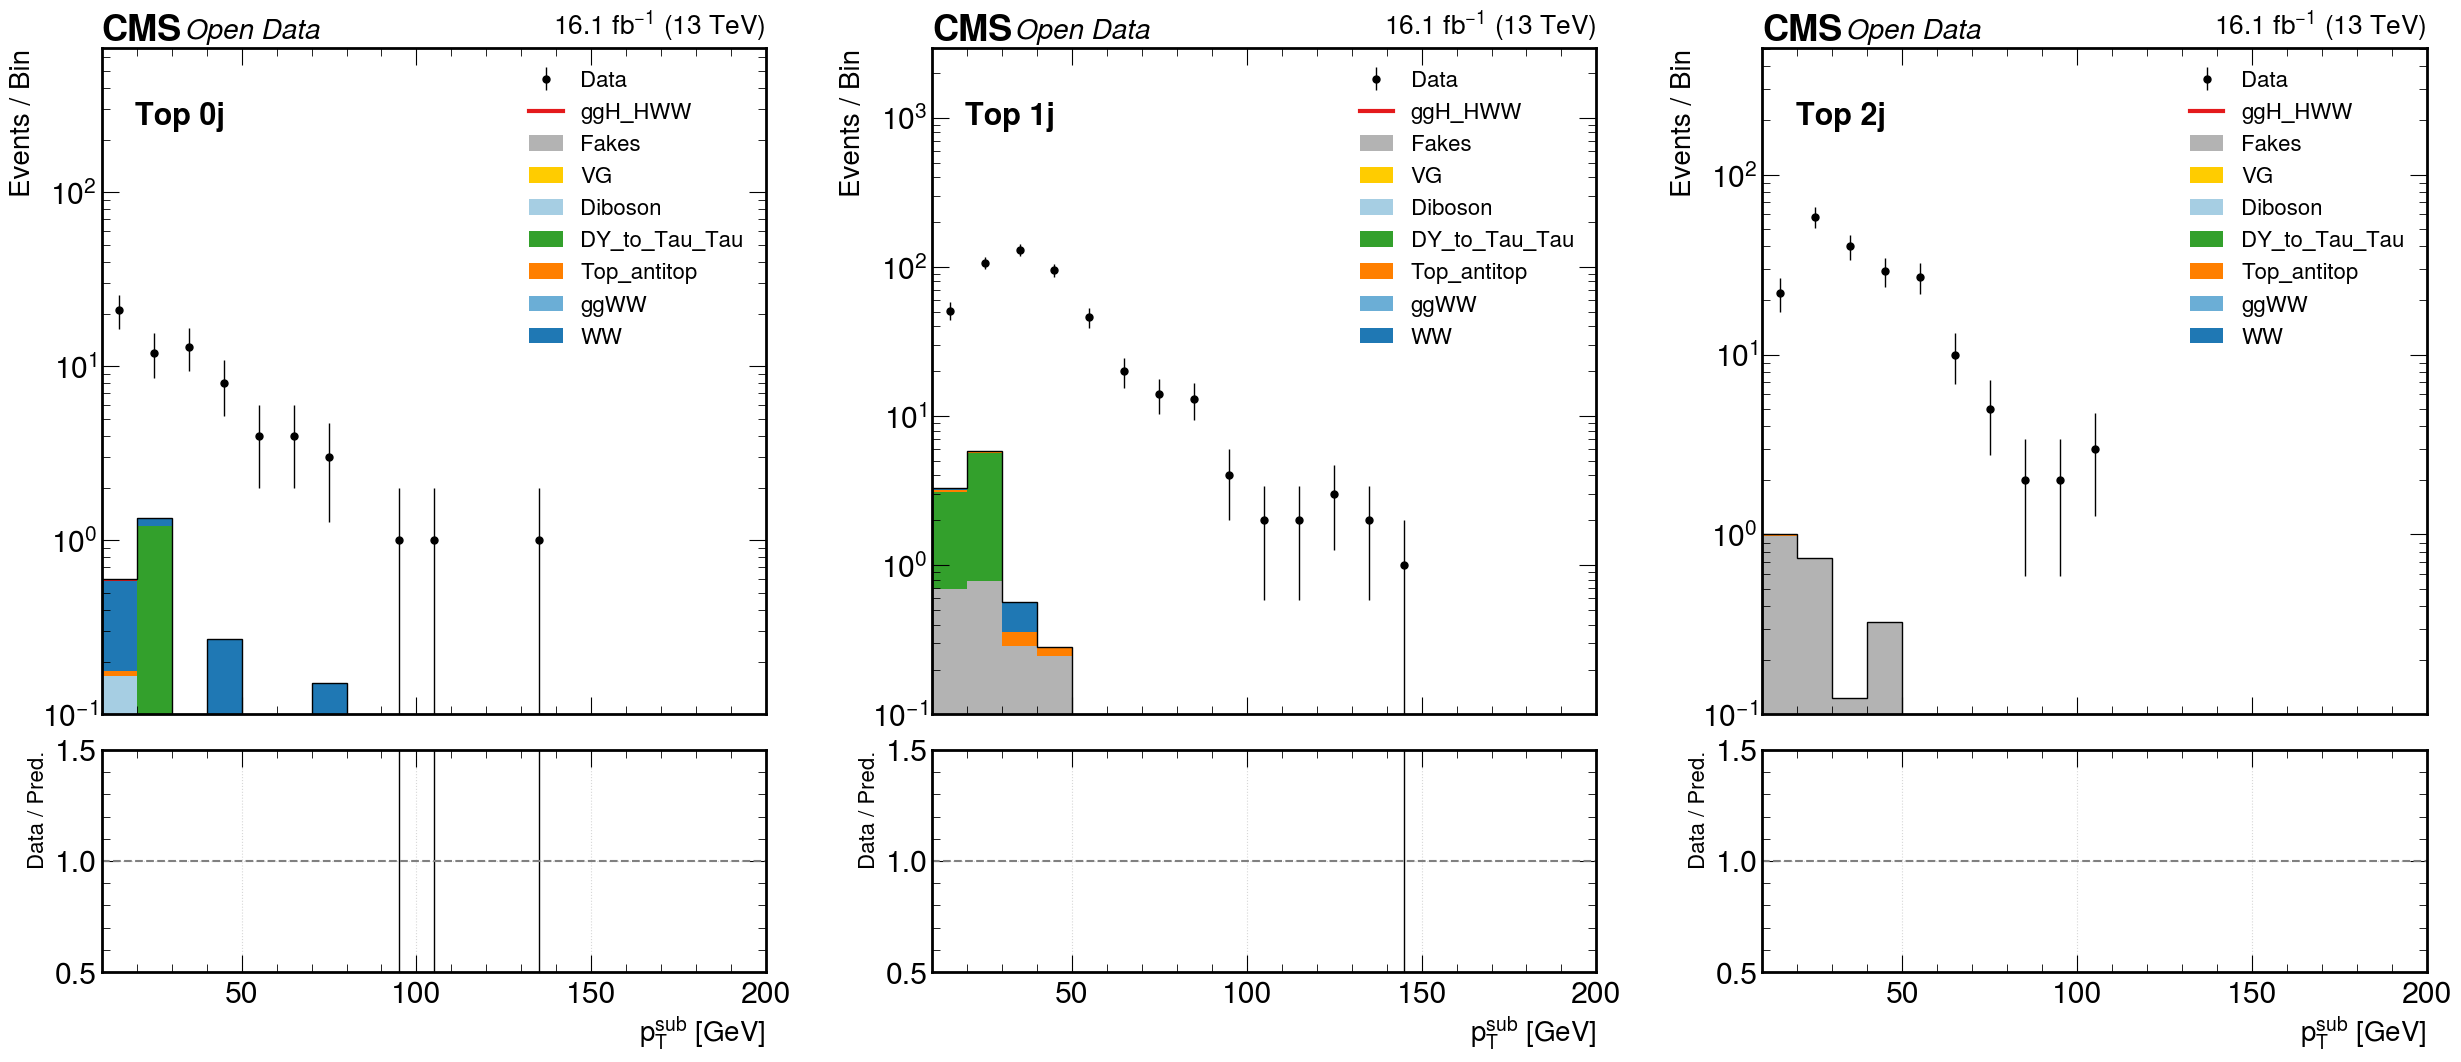

Plotting subleading_pt in Control_Region_Tau...


/tmp/ipykernel_287/3355168007.py:137: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: plots_mplhep/CMS_Control_Region_Tau_subleading_pt.png


In [30]:
hep.style.use("CMS")

def stacked_plots(variable, hist_data_all, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)
    xlabel = VAR_LABELS.get(variable, variable)
    
    backgrounds = [s for s in SAMPLES if not SAMPLES[s]['is_signal'] and s != 'Data']
    backgrounds.sort(key=lambda s: SAMPLES[s].get("stack_order", 0))
    signal = next((s for s in SAMPLES if SAMPLES[s]['is_signal']), None)
    data_sample = 'Data'

    #  MAIN LOOP OVER REGIONS 
    for region_name, config in PLOT_SETTINGS.items():
        var_config = config['variables'].get(variable)
        if not var_config: continue

        print(f"Plotting {variable} in {region_name}...")
        
        stages = config['stages']
        use_log = var_config.get('log', False)
        set_xlim = var_config.get('xlim', None)
        set_ylim = var_config.get('ylim', None)
        
        is_signal_region = "Signal" in region_name
        plot_data = False if is_signal_region else config.get('plot_data', True)

        # CANVAS SETUP 
        if plot_data:
            # 2 Rows (Main + Ratio)
            fig, axes = plt.subplots(2, 3, figsize=(30, 12), 
                                     gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.08, 'wspace': 0.25},
                                     sharex='col')
            row_axes = axes[0]
            ratio_axes = axes[1]
        else:
            #  Row (Main only)
            fig, axes = plt.subplots(1, 3, figsize=(30, 9), 
                                     gridspec_kw={'wspace': 0.25},
                                     sharex='col')
            row_axes = axes
            ratio_axes = [None] * 3

        # LOOP OVER JET CATEGORIES 
        for col_idx, (stage_key, stage_label) in enumerate(stages):
            ax_main = row_axes[col_idx]
            ax_ratio = ratio_axes[col_idx]
            
            # DATA COLLECTION 
            stack_vals, stack_colors, stack_labels = [], [], []
            edges = None
            
            # 1. Load Backgrounds 
            for s in backgrounds:
                vals, e = get_histogram_data(hist_data_all, s, stage_key, variable)
                if vals is not None:
                    stack_vals.append(vals)
                    stack_colors.append(SAMPLES[s].get("color", "gray"))
                    stack_labels.append(s)
                    if edges is None: edges = e
            
            # 2. Load Signal (for Stack AND Overlay)
            sig_vals = None
            if signal:
                sig_vals, _ = get_histogram_data(hist_data_all, signal, stage_key, variable)
                
                if sig_vals is not None and edges is not None:
                    stack_vals.append(sig_vals)
                    stack_colors.append(SAMPLES[signal].get("color", "red"))
                    stack_labels.append(signal)

            if edges is None:
                ax_main.text(0.5, 0.5, "No Data", ha='center', transform=ax_main.transAxes)
                continue

            # 3. Load Data
            data_vals = None
            if plot_data:
                data_vals, _ = get_histogram_data(hist_data_all, data_sample, stage_key, variable)

            # PLOT MAIN 
            
            # A. Draw Full Stack 
            if stack_vals:
                hep.histplot(stack_vals, bins=edges, stack=True, histtype='fill',
                             color=stack_colors, label=stack_labels, ax=ax_main)
                
                total_stack = np.sum(stack_vals, axis=0)
                hep.histplot(total_stack, bins=edges, histtype='step', color='black', linewidth=1, ax=ax_main)
            
            # B. Draw Signal Overlay 
            if sig_vals is not None:
                
                sig_scale = 10 if is_signal_region else 1
                
                # Create label
                if sig_scale > 1:
                    sig_lbl = f"{signal} (x{sig_scale})"
                else:
                    sig_lbl = f"{signal}" 

                hep.histplot(sig_vals * sig_scale, bins=edges, histtype='step',
                             color=SAMPLES[signal].get("color", "red"), 
                             linewidth=3, label=sig_lbl, ax=ax_main)

            # C. Draw Data Points
            if data_vals is not None:
                yerr = np.sqrt(data_vals); yerr[data_vals == 0] = 0
                hep.histplot(data_vals, bins=edges, histtype='errorbar', color='black', 
                             label='Data', yerr=yerr, marker='o', markersize=5, ax=ax_main, zorder=10)

            # PLOT RATIO 
            if plot_data and data_vals is not None and stack_vals:
                safe_denom = np.where(total_stack == 0, 1e-9, total_stack)
                ratio = data_vals / safe_denom
                ratio_err = np.abs(np.sqrt(data_vals) / safe_denom) 
                
                hep.histplot(ratio, bins=edges, histtype='errorbar', yerr=ratio_err,
                             color='black', marker='o', markersize=4, ax=ax_ratio)
                ax_ratio.axhline(1, color='gray', linestyle='--')
                
                ax_ratio.set_ylim(0.5, 1.5)
                ax_ratio.set_ylabel("Data / Pred.", fontsize=16)
                ax_ratio.set_xlabel(xlabel, fontsize=20)
                ax_ratio.grid(True, linestyle=':', alpha=0.5)
            # --- STYLING ---
            #  CMS Logo & Lumi 
            hep.cms.label(ax=ax_main, loc=0, data=True, label="Open Data", 
                          lumi=16.1, fontsize=20)

            ax_main.text(0.05, 0.92, stage_label, transform=ax_main.transAxes, fontsize=22, fontweight='bold', va='top')
            ax_main.set_ylabel("Events / Bin", fontsize=20)
            
            # Scales
            if use_log:
                ax_main.set_yscale('log')
                max_val = np.max(total_stack) if len(total_stack)>0 else 1
                ax_main.set_ylim(0.1, max_val * 500)
            else:
                max_val = np.max(total_stack) if len(total_stack)>0 else 1
                ax_main.set_ylim(0, max_val * 1.5)

            if set_xlim: ax_main.set_xlim(set_xlim)
            if set_ylim and not use_log: ax_main.set_ylim(set_ylim)

            if not plot_data:
                ax_main.set_xlabel(xlabel, fontsize=20)

            #  LEGEND 
            handles, labels = ax_main.get_legend_handles_labels()
            
            by_label = dict(zip(labels, handles))
            
            final_h, final_l = [], []
            if 'Data' in by_label: 
                final_h.append(by_label['Data']); final_l.append('Data')
            
            # Check for magnified signal label
            for lbl in by_label:
                if "(x" in lbl: 
                    final_h.append(by_label[lbl]); final_l.append(lbl)
            
            if signal in by_label and signal not in final_l:
                 final_h.append(by_label[signal]); final_l.append(signal)

            for lbl in reversed(list(by_label.keys())):
                
                if lbl not in final_l: 
                    final_h.append(by_label[lbl]); final_l.append(lbl)
            
            ax_main.legend(final_h, final_l, loc='upper right', ncol=1, frameon=False, fontsize=16)

        # --- SAVE & SHOW ---
        fname = f"{output_dir}/CMS_{region_name}_{variable}.png"
        plt.savefig(fname, bbox_inches='tight', dpi=150)
        print(f"Saved: {fname}")
        plt.show()
        plt.close(fig)

# 3. RUN
for var in VAR_LABELS:
    stacked_plots(var, hist_data_final, output_dir="plots_mplhep")